<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/time_series/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


df_agg_clusters_4_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_4.csv"
df_agg_clusters_8_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_8.csv"
df_agg_clusters_12_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_12.csv"
df_agg_clusters_18_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_18.csv"

df_agg_clusters_4 = pd.read_csv(df_agg_clusters_4_url)
df_agg_clusters_4 = df_agg_clusters_4.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_4['HOSPI_CODE_UCD'] = df_agg_clusters_4['HOSPI_CODE_UCD'].astype(str)


df_agg_clusters_8 = pd.read_csv(df_agg_clusters_8_url)
df_agg_clusters_8 = df_agg_clusters_8.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_8['HOSPI_CODE_UCD'] = df_agg_clusters_8['HOSPI_CODE_UCD'].astype(str)

df_agg_clusters_12 = pd.read_csv(df_agg_clusters_12_url)
df_agg_clusters_12 = df_agg_clusters_12.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_12['HOSPI_CODE_UCD'] = df_agg_clusters_12['HOSPI_CODE_UCD'].astype(str)

df_agg_clusters_18 = pd.read_csv(df_agg_clusters_18_url)
df_agg_clusters_18 = df_agg_clusters_18.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_18['HOSPI_CODE_UCD'] = df_agg_clusters_18['HOSPI_CODE_UCD'].astype(str)

medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [2]:
df_agg_clusters_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HOSPI_CODE_UCD  2479 non-null   object 
 1   QUANTITY        2479 non-null   float64
 2   N_UFS           2479 non-null   float64
 3   DATE            2479 non-null   object 
 4   N_ETB           2479 non-null   float64
 5   POPULATION      2479 non-null   float64
 6   P_MEDICAL       2479 non-null   float64
 7   PN_MEDICAL      2479 non-null   float64
 8   LIT_HC          2479 non-null   float64
 9   LIT_HP          2479 non-null   float64
 10  SEJ_MCO         2479 non-null   float64
 11  SEJ_HAD         2479 non-null   float64
 12  SEJ_PSY         2479 non-null   float64
 13  SEJ_SSR         2479 non-null   float64
 14  SEJ_SLD         2479 non-null   float64
 15  MONTH_1         2479 non-null   int64  
 16  MONTH_2         2479 non-null   int64  
 17  MONTH_3         2479 non-null   i

## 5.1 - New database composition based on clusters

## 5.2 - Building forecasting models based on clusters

In [3]:
def plot_pred(y_pred, y_test, medicine):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for y_pred
    axes[0].scatter(np.arange(len(y_pred)), y_pred, marker='o', label='Predicted', color='blue')

    # Scatter plot for y_test
    axes[0].scatter(np.arange(len(y_test)), y_test, marker='x', label='Actual', color='red')

    # Set axes labels and title
    axes[0].set_xlabel('Test samples')
    axes[0].set_ylabel('Quantity')
    axes[0].set_title(f'Predicted vs Actual: {medicine}')
    axes[0].legend()

    epsilon = 0.001
    mape_array = np.abs(y_test - y_pred) / np.maximum(epsilon, np.abs(y_test))

    # Stem plot for MAPE
    stem = axes[1].stem(np.arange(len(y_pred)), mape_array, markerfmt='bo', linefmt='b-', basefmt='r-', label='MAPE')
    axes[1].set_xlabel('Test samples')
    axes[1].set_ylabel('MAPE')
    axes[1].set_title(f'MAPE for: {medicine}')
    axes[1].set_ylim([0, 1])

    mape_target = 0.3
    axes[1].axhline(y=mape_target, color='g', linestyle='--', label=f'Target MAPE ({mape_target:.2f})')

    # Adjust layout
    plt.tight_layout()

    # Add a legend
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles=handles, labels=labels, loc='best')

    # Adjust width of subplots and margins
    fig.subplots_adjust(wspace=0.4, left=0.1, right=0.9)

    plt.show()

In [4]:
def test_1_baseline(df, medicine, df_scores):
  print()
  print(100*'-')
  print('Medicine:' + str(medicine))

  X = df[df['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD',
                                                 'DATE'], axis=1).values

  y = df[df['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].values

  if m.ceil(len(X) * 0.1) == 1:
    print('Dataset too small')
    test_size = 2
  else:
    test_size = 0.2

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = test_size,
                                                      random_state = 42)
  print(f'Size of data set: {len(X)}')
  print(f'Size of training set: {len(X_train)}')
  print(f'Size of test set: {len(X_test)}')

  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt', 1, 2]
  }
  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             param_grid=param_grid,
                             scoring = 'neg_mean_absolute_percentage_error',
                             cv = 5,
                             n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''
  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best estimator
  best_estimator = grid_search.best_estimator_

  # Make predictions using the best estimator
  y_pred = best_estimator.predict(X_test)

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)

  # Calculate MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Print the best parameters, best score, and evaluation metrics
  print('Best Parameters: ', grid_search.best_params_)
  print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
  print(10*'-' + 'Test scores' + 10*'-')
  print('R^2 Score:', round(r2, 3))
  print('MAE:', round(mae, 3))
  print('MAPE:', round(mape, 3))
  print('RMSE:', round(rmse, 3))
  print()


  # Create the new row as a DataFrame
  new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                          'R2': [r2],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'MAPE': [mape]})

  # Append the new row to the DataFrame
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)

  # plot pred x test
  plot_pred(y_pred, y_test, medicine)
  print()
  plt.close()



  # Return the updated DataFrame
  return df_scores


In [5]:
'''df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

for medicine in medicines:
  if medicine == '3400891996128':
    # Create the new row as a DataFrame
    new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                            'R2': [0],
                            'RMSE': [0],
                            'MAE': [0],
                            'MAPE': [0]})

    # Append the new row to the DataFrame
    df_prediction_scores = pd.concat([df_prediction_scores, new_row], ignore_index=True)

  else:
    df_prediction_scores = test_1_baseline(df_agg_clusters_4.drop(['CLUSTER'], axis = 1), medicine, df_prediction_scores)

df_prediction_scores'''

"df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])\n\nfor medicine in medicines:\n  if medicine == '3400891996128':\n    # Create the new row as a DataFrame\n    new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],\n                            'R2': [0],\n                            'RMSE': [0],\n                            'MAE': [0],\n                            'MAPE': [0]})\n\n    # Append the new row to the DataFrame\n    df_prediction_scores = pd.concat([df_prediction_scores, new_row], ignore_index=True)\n\n  else:\n    df_prediction_scores = test_1_baseline(df_agg_clusters_4.drop(['CLUSTER'], axis = 1), medicine, df_prediction_scores)\n\ndf_prediction_scores"

In [8]:
def test_2_clustering(df, df_scores, medicines):

  for cluster in df.CLUSTER.unique():
    print()
    print(100*'-')
    print(f'Cluster: {cluster}')

    # Perform the train-test split with shuffled samples
    X = df[df['CLUSTER'] == cluster].drop(['DATE', 'QUANTITY', 'CLUSTER'], axis=1).copy().values
    y = df[df['CLUSTER'] == cluster]['QUANTITY'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, shuffle = True)
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

    df_test = pd.DataFrame(X_test, columns = df.drop(['DATE', 'QUANTITY', 'CLUSTER'], axis=1).copy().columns)
    df_test['QUANTITY'] = y_test


    # Define the parameter distributions for RandomizedSearchCV
    param_grid = {
        'max_depth': np.arange(2, 8, 1),
        'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
        'max_features': ['sqrt', 1, 2]
    }

    depth_len = param_grid['max_depth'].size
    estimators_len = param_grid['n_estimators'].size

    print(f'Size of grid search: {depth_len * estimators_len}')

    # Create the RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              scoring = 'neg_mean_absolute_percentage_error',
                              cv = 5,
                              n_jobs = -1)

    ''' >3 : the fold and candidate parameter indexes
        are also displayed together with the starting time of the computation.
    '''


    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train[:,1:], y_train)

    print("Finished training")

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    for medicine in df_test.HOSPI_CODE_UCD.unique():
      print()
      print(100*'-')
      print('Medicine:' + str(medicine))

      X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD'], axis=1).copy().values

      scaler = StandardScaler()
      X_test_scaled = scaler.fit_transform(X_test_medicine)

      y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

      # Make predictions using the best estimator
      y_pred = best_estimator.predict(X_test_scaled)

      # Calculate R^2 score
      r2 = r2_score(y_test_medicine, y_pred)

      # Calculate MAE
      mae = mean_absolute_error(y_test_medicine, y_pred)

      # Calculate MAPE
      mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

      # Print the best parameters, best score, and evaluation metrics

      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print(10*'-' + 'Test scores' + 10*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()


      # Create the new row as a DataFrame
      new_row = pd.DataFrame({'CLUSTER': [cluster],
                              'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                              'R2': [r2],
                              'RMSE': [rmse],
                              'MAE': [mae],
                              'MAPE': [mape]})

      # Append the new row to the DataFrame
      df_scores = pd.concat([df_scores, new_row], ignore_index=True)

      plot_pred(y_pred, y_test_medicine, medicine)
      print()


  # Return the updated DataFrame
  return df_scores


----------------------------------------------------------------------------------------------------
Cluster: 3
Size of data set: 543
Size of training set: 434
Size of test set: 109
Size of grid search: 252
Finished training

----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -12.356
MAE: 951.994
MAPE: 0.386
RMSE: 1015.064



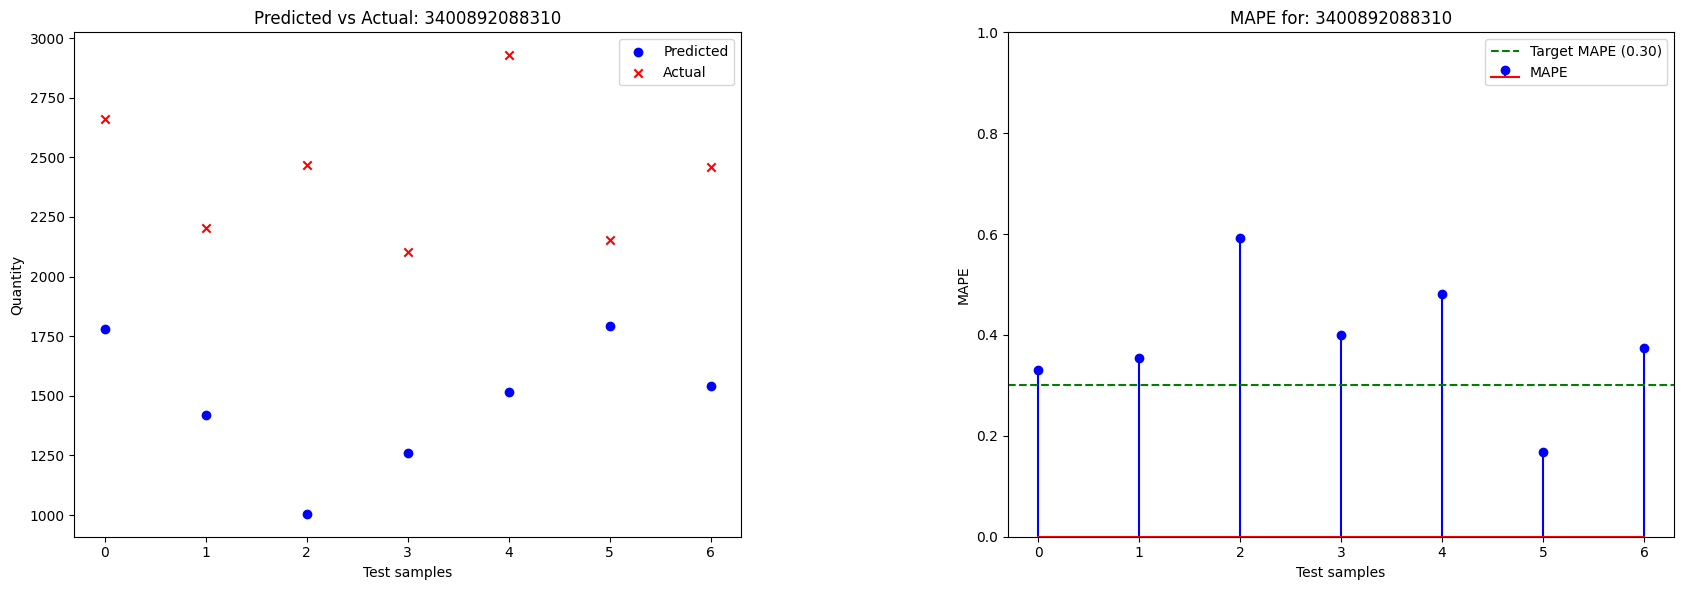



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -1.706
MAE: 213.173
MAPE: 0.129
RMSE: 248.588



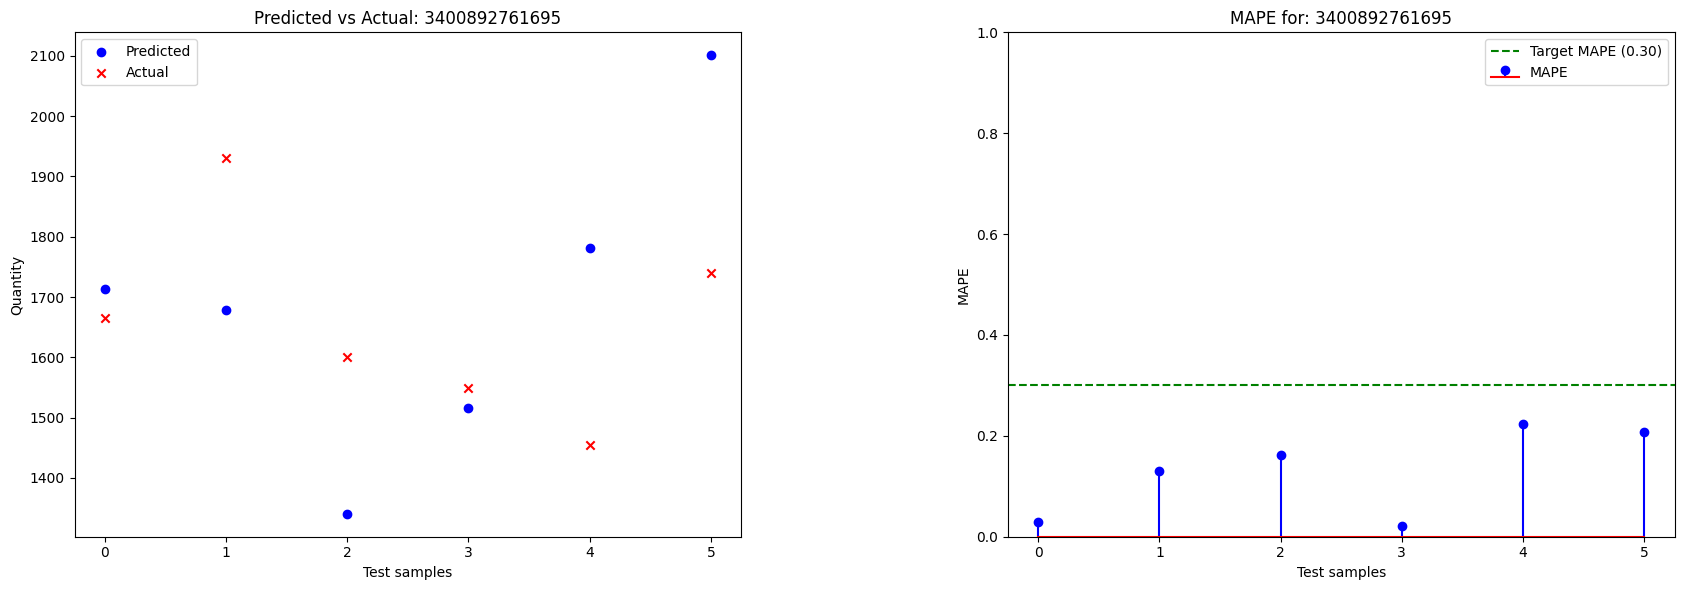



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -14.919
MAE: 860.273
MAPE: 0.909
RMSE: 1009.788



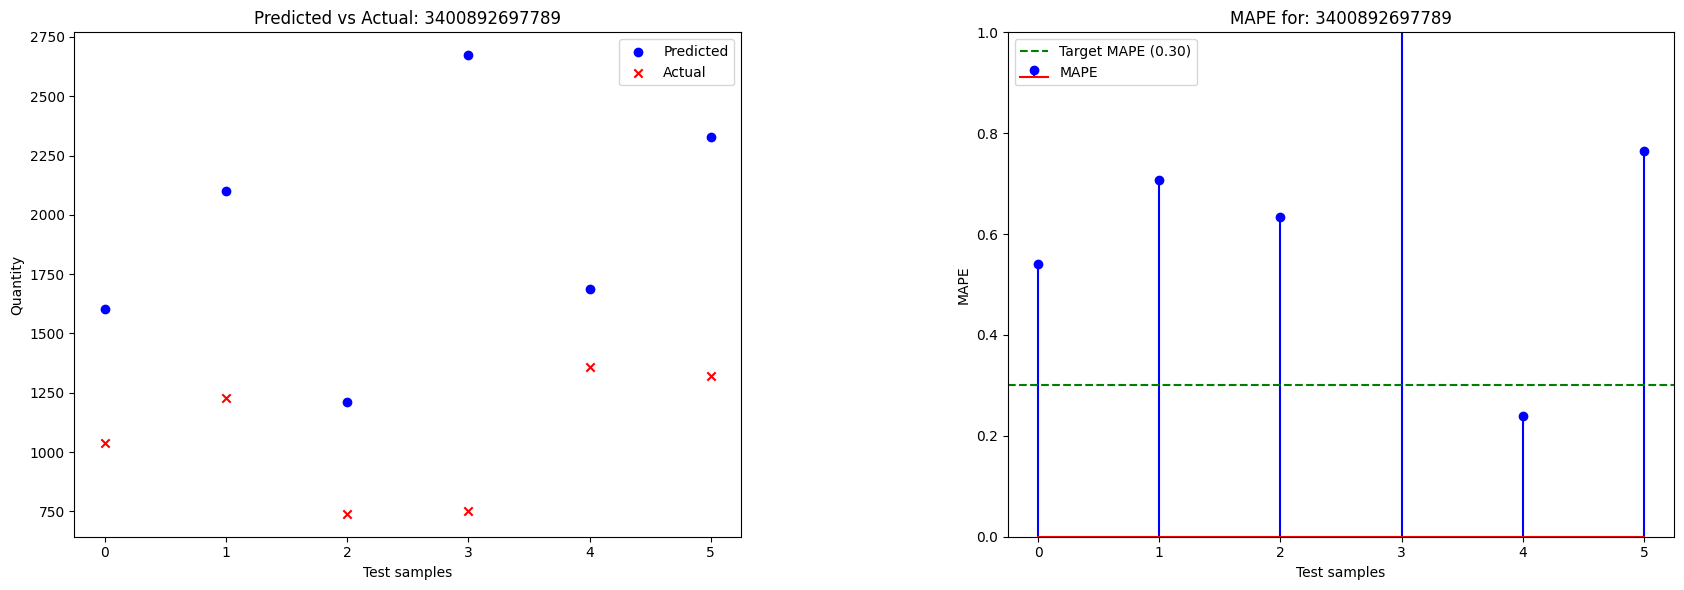



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -1.628
MAE: 253.244
MAPE: 0.2
RMSE: 314.061



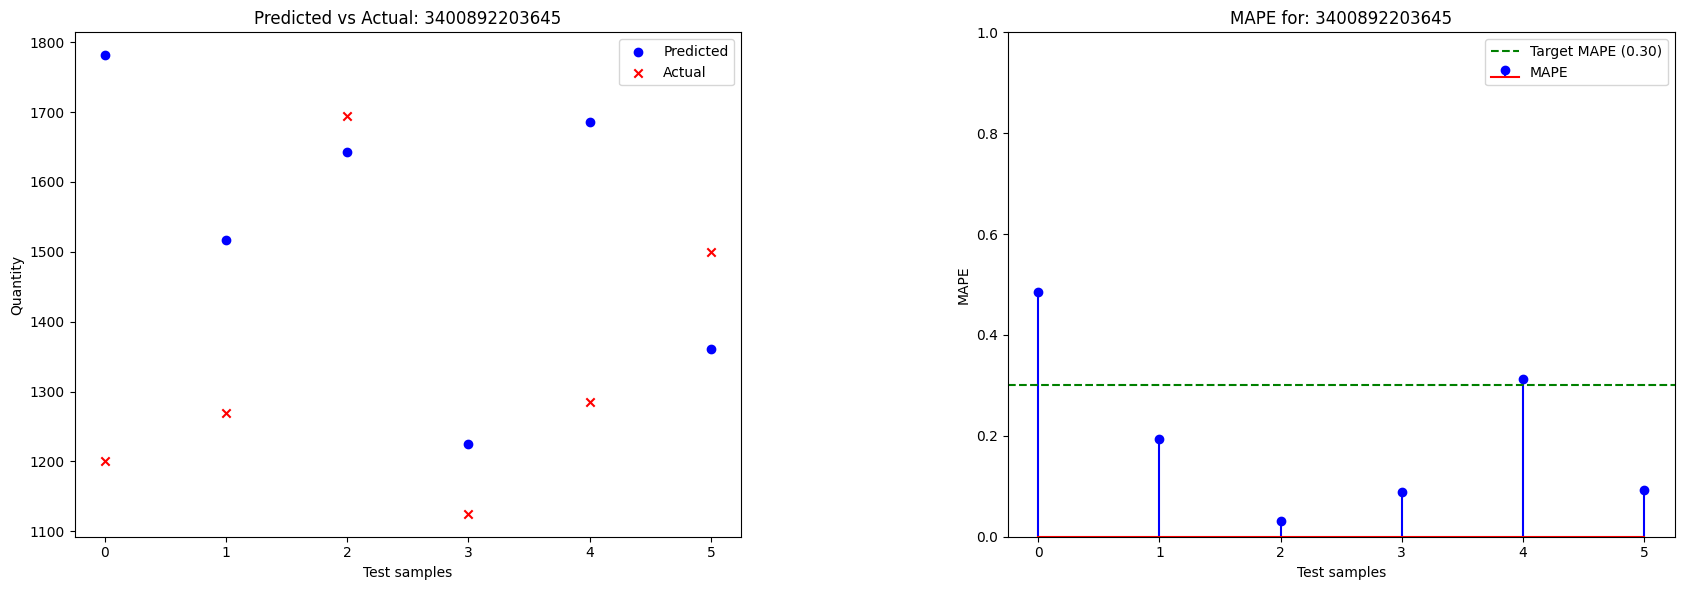



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -94.21
MAE: 8242.31
MAPE: 0.833
RMSE: 8285.875



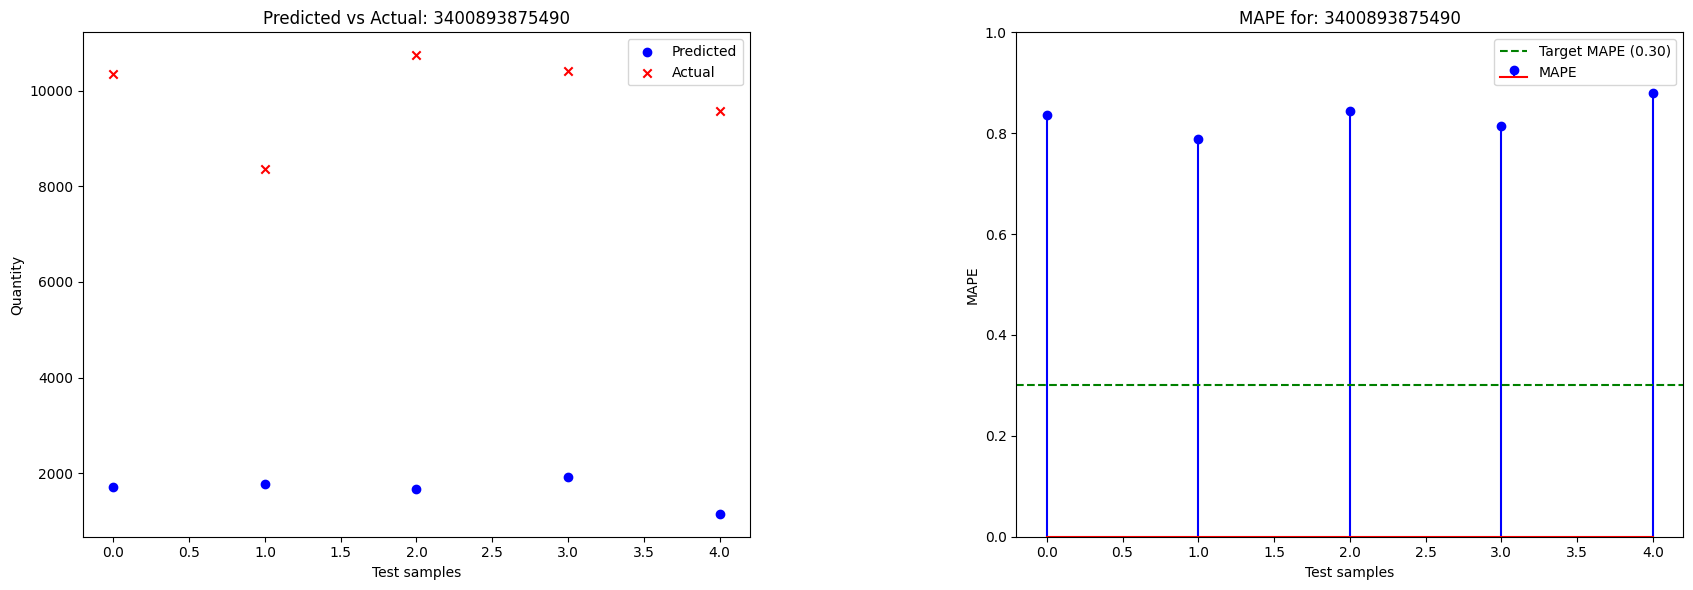



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -0.046
MAE: 552.878
MAPE: 1.09
RMSE: 777.609



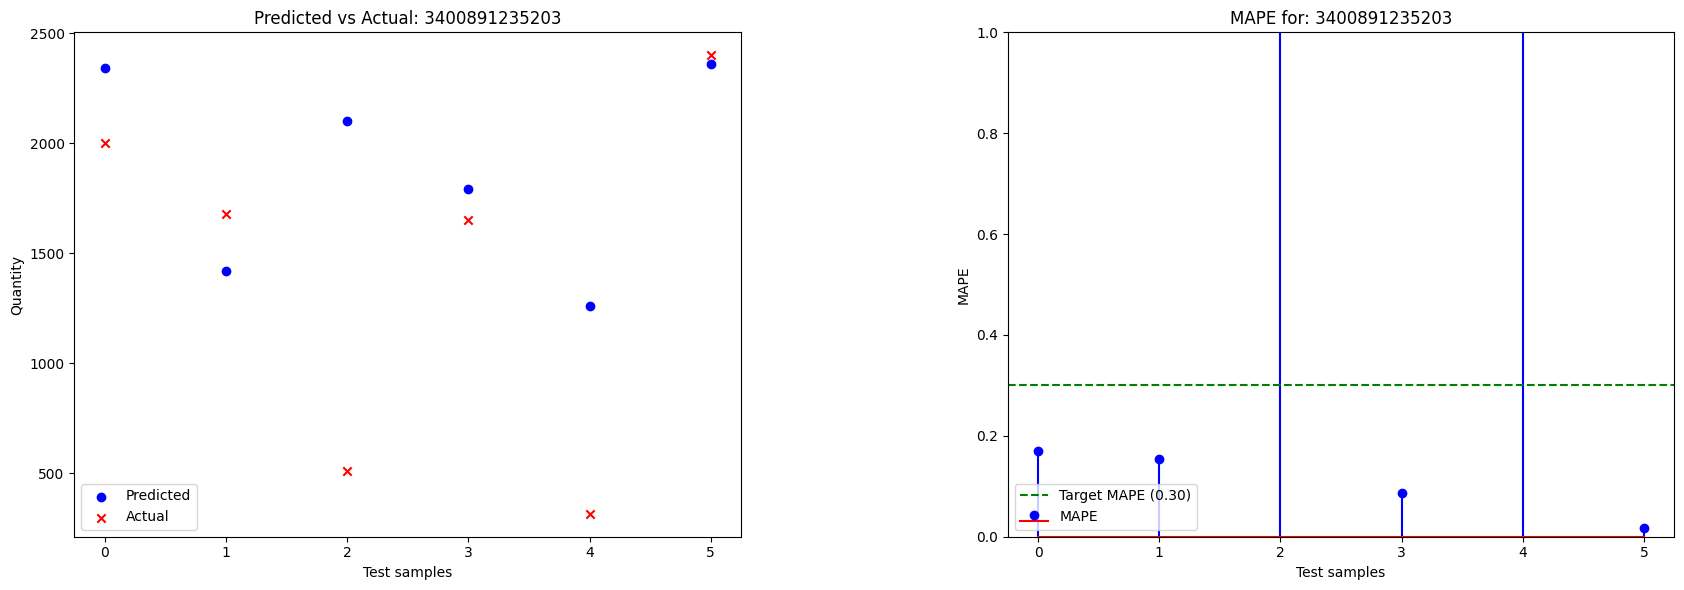



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -6.774
MAE: 2928.623
MAPE: 0.628
RMSE: 3086.853



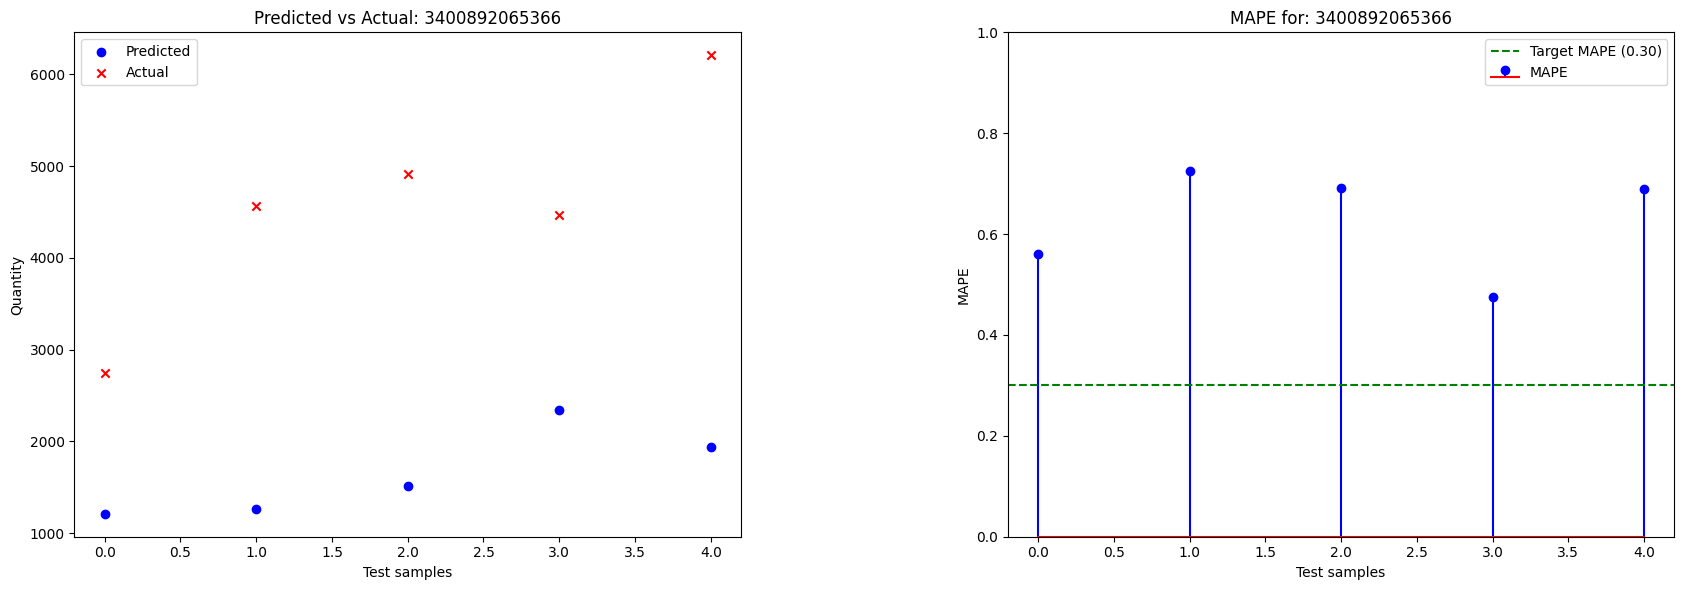



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -39.377
MAE: 12917.83
MAPE: 0.871
RMSE: 13123.802



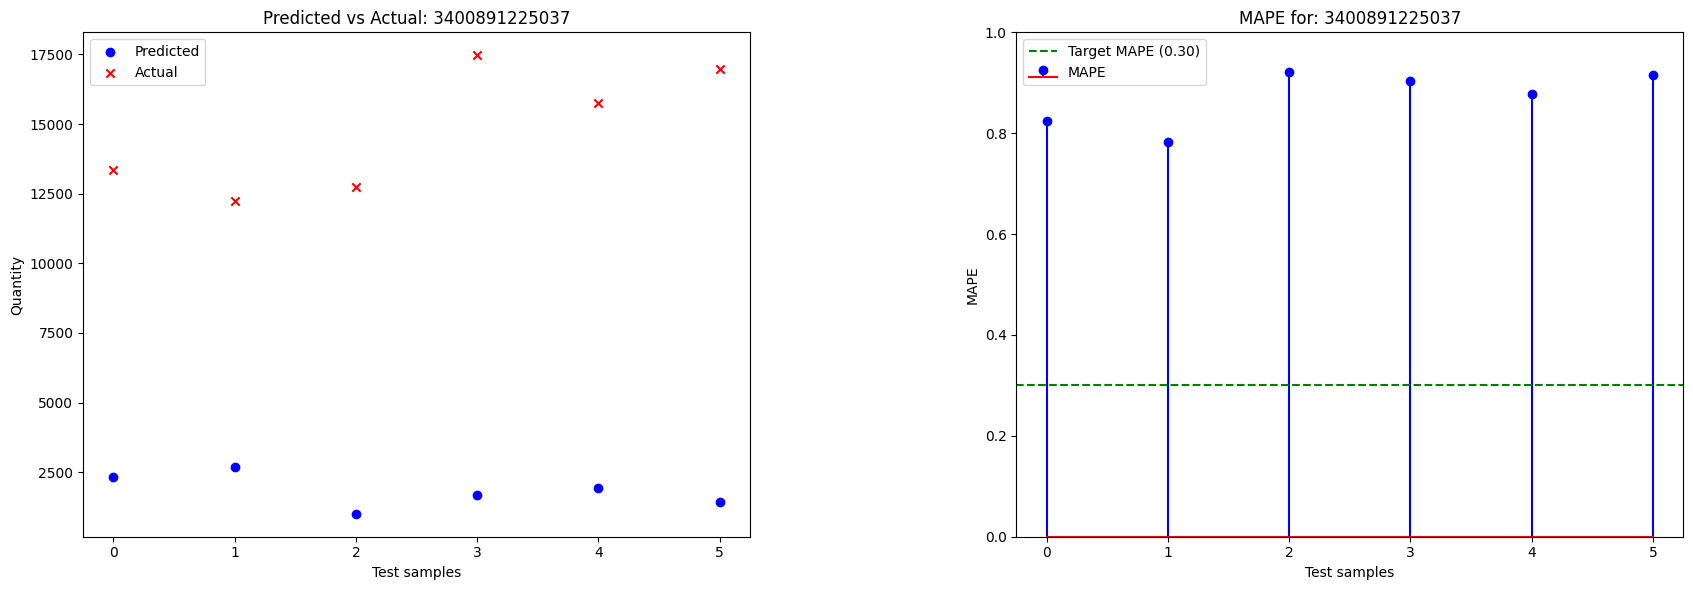



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -1.283
MAE: 2215.703
MAPE: 22.212
RMSE: 2423.573



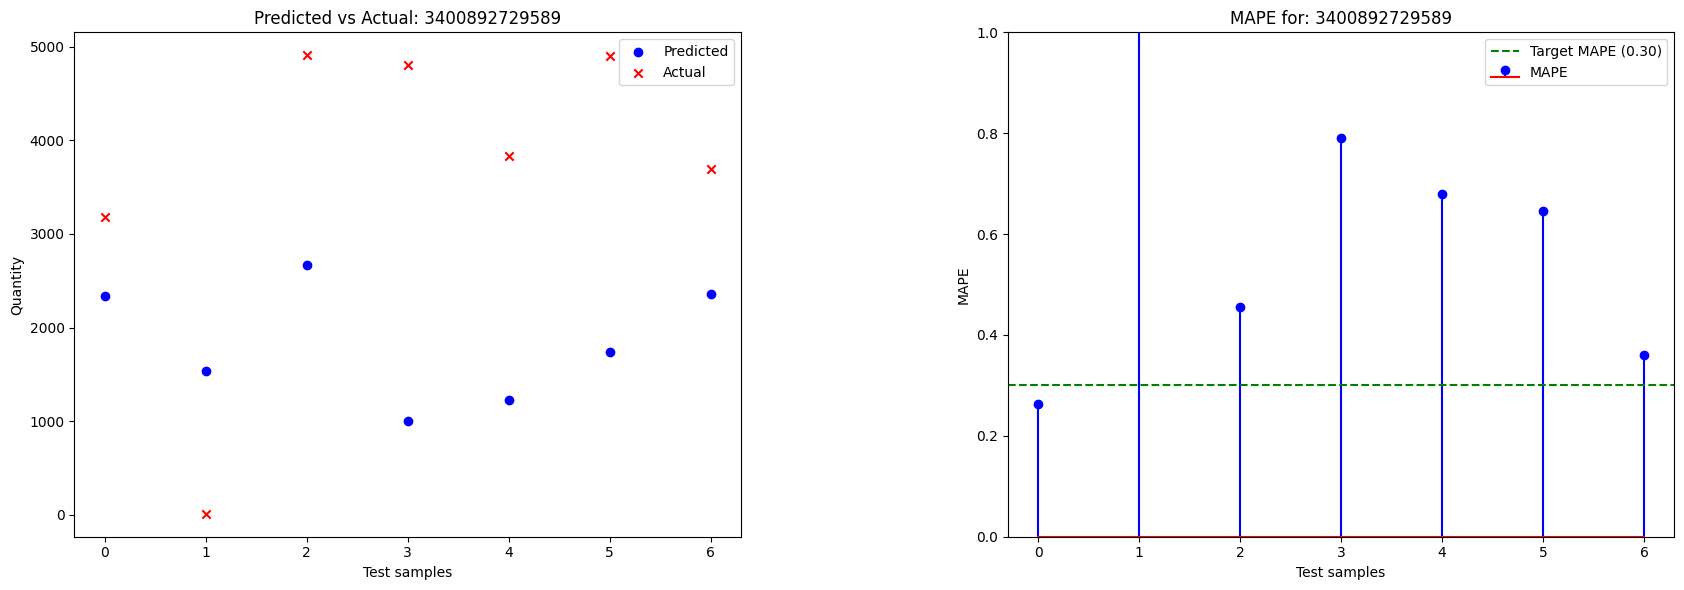



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -15.872
MAE: 5191.521
MAPE: 0.759
RMSE: 5278.146



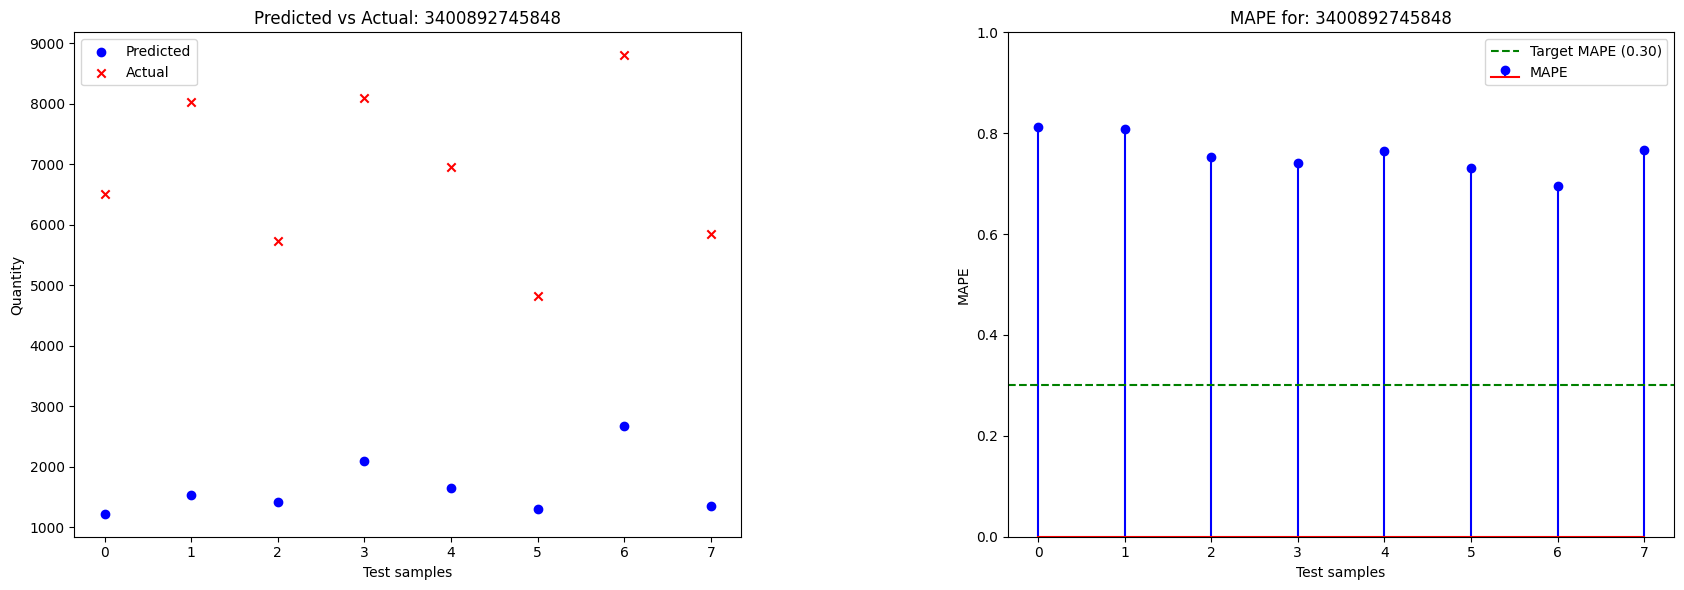



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -119.095
MAE: 552.394
MAPE: 0.49
RMSE: 835.946



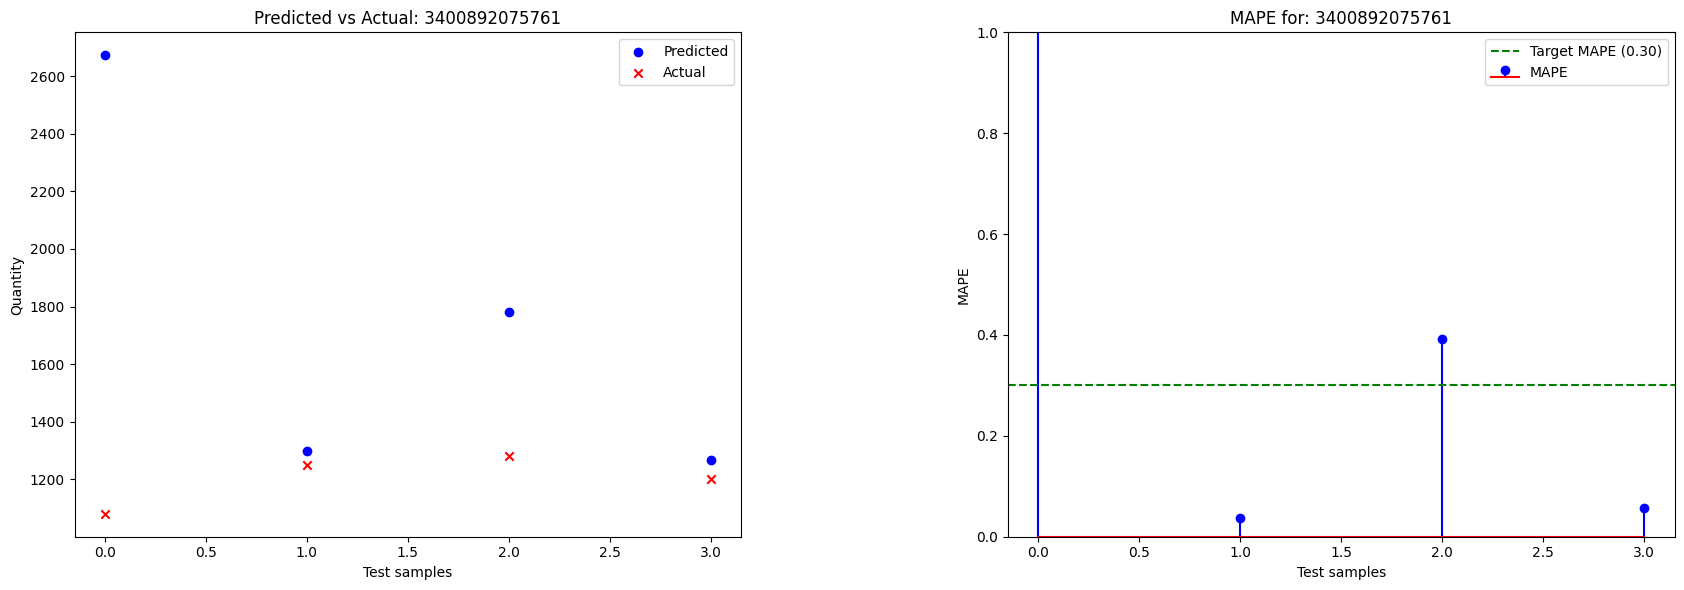



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -9.143
MAE: 1022.396
MAPE: 0.356
RMSE: 1164.68



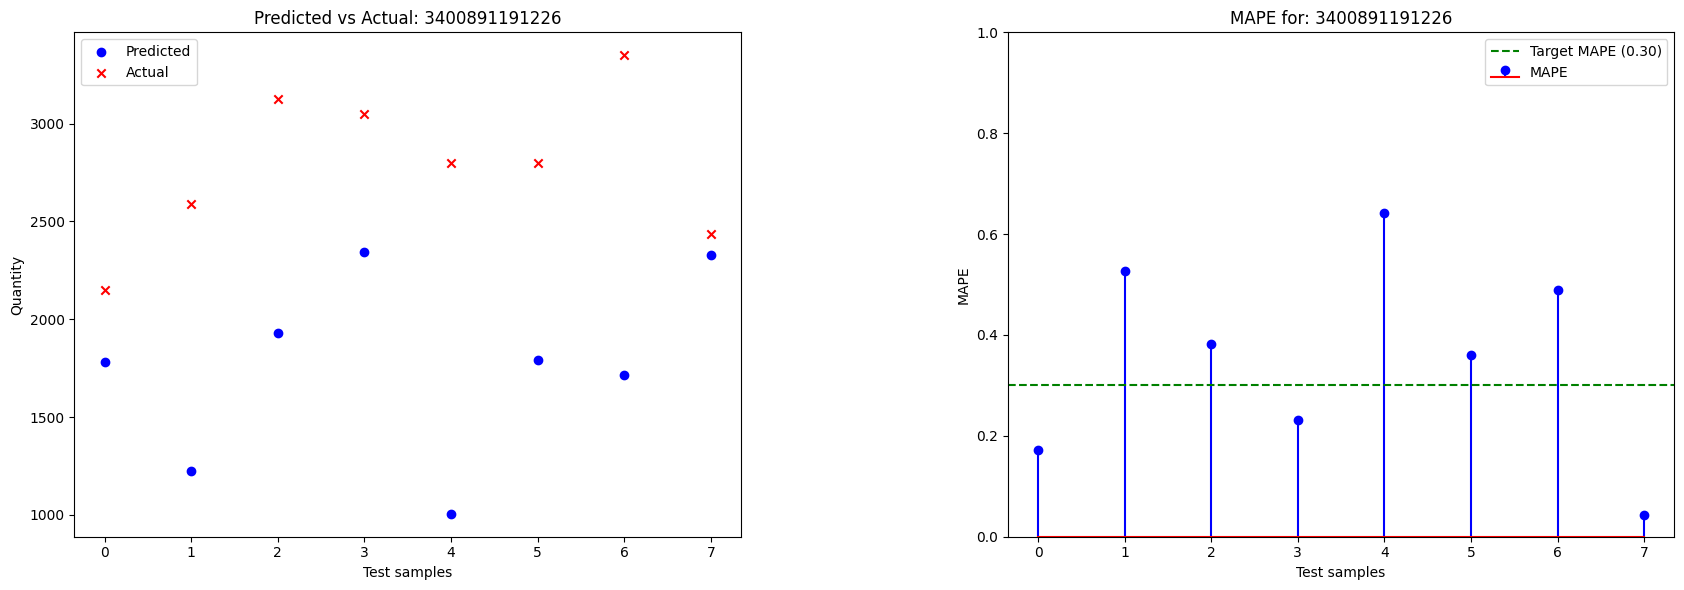



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -20.882
MAE: 1439.817
MAPE: 0.436
RMSE: 1574.95



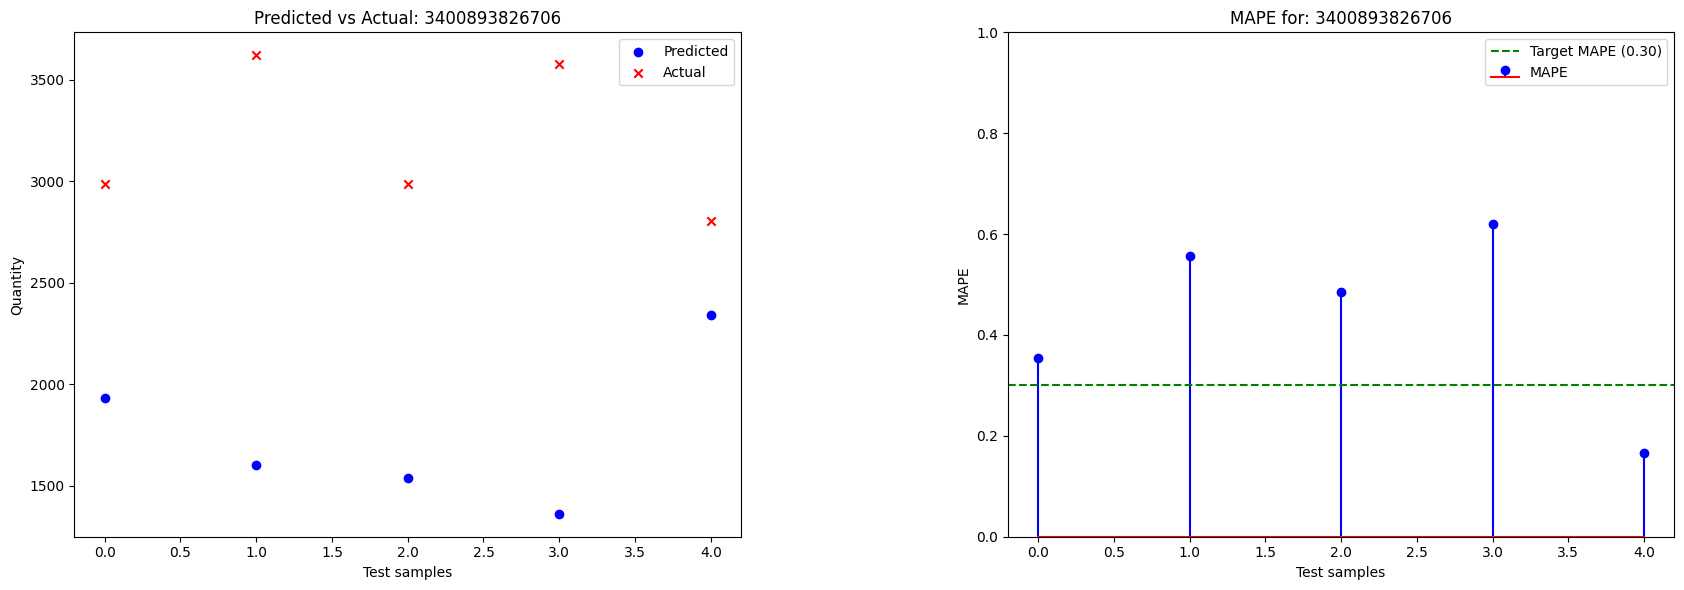



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -38.247
MAE: 1660.536
MAPE: 0.484
RMSE: 1745.63



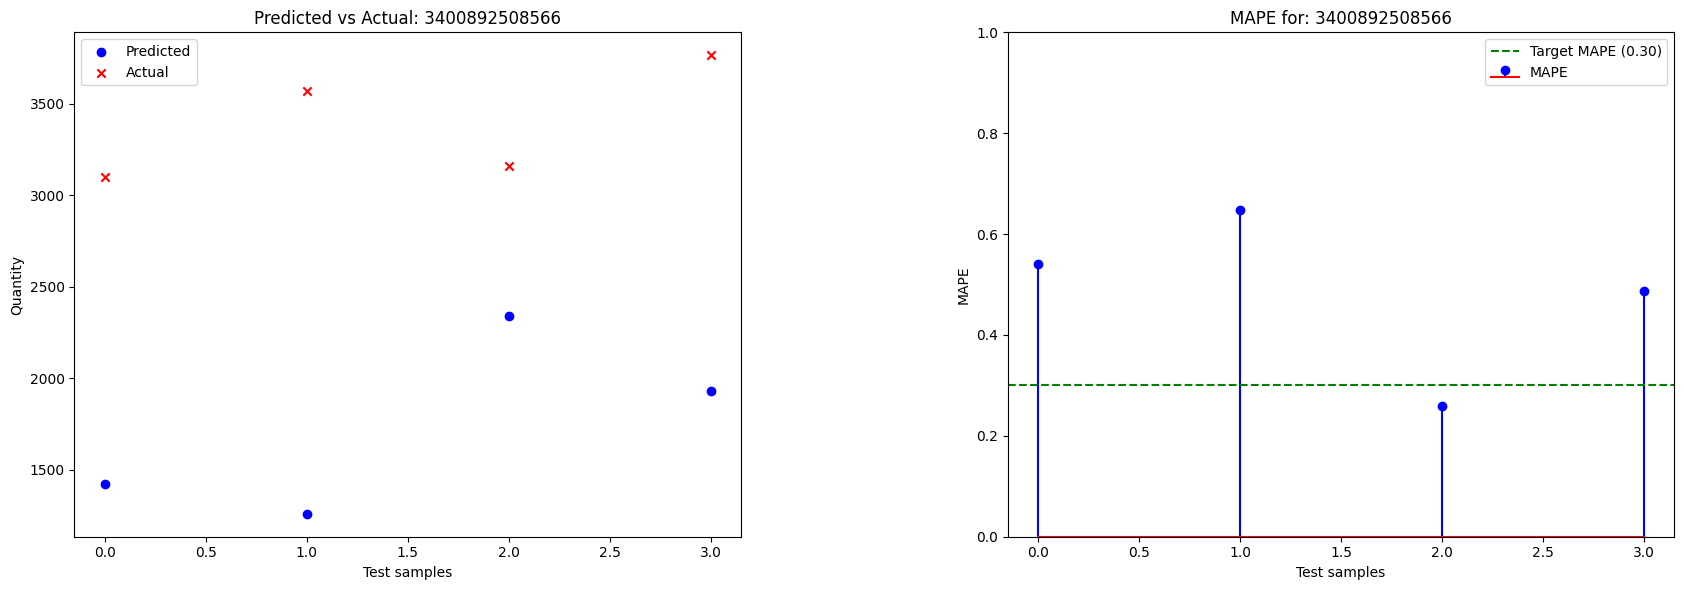



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -49.368
MAE: 1472.981
MAPE: 0.476
RMSE: 1491.825



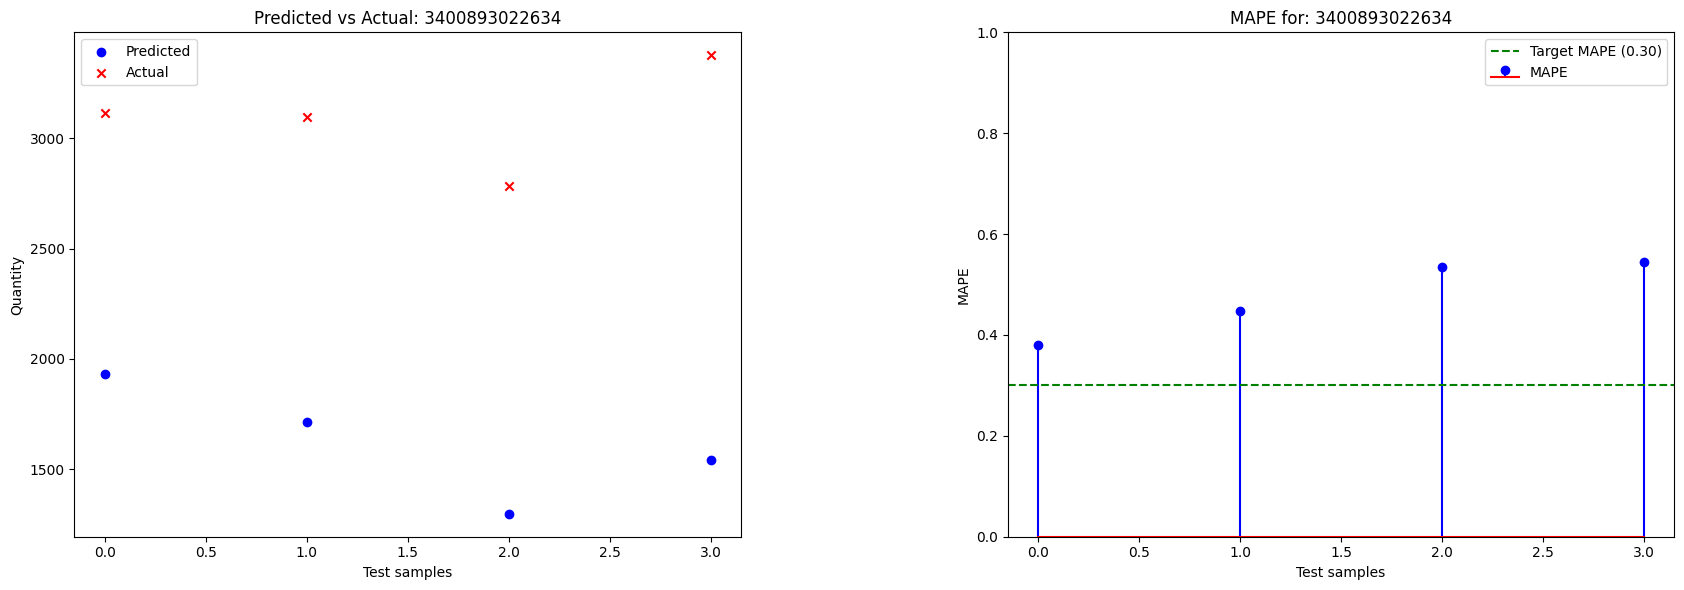



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -0.943
MAE: 1298.856
MAPE: 0.74
RMSE: 1322.352



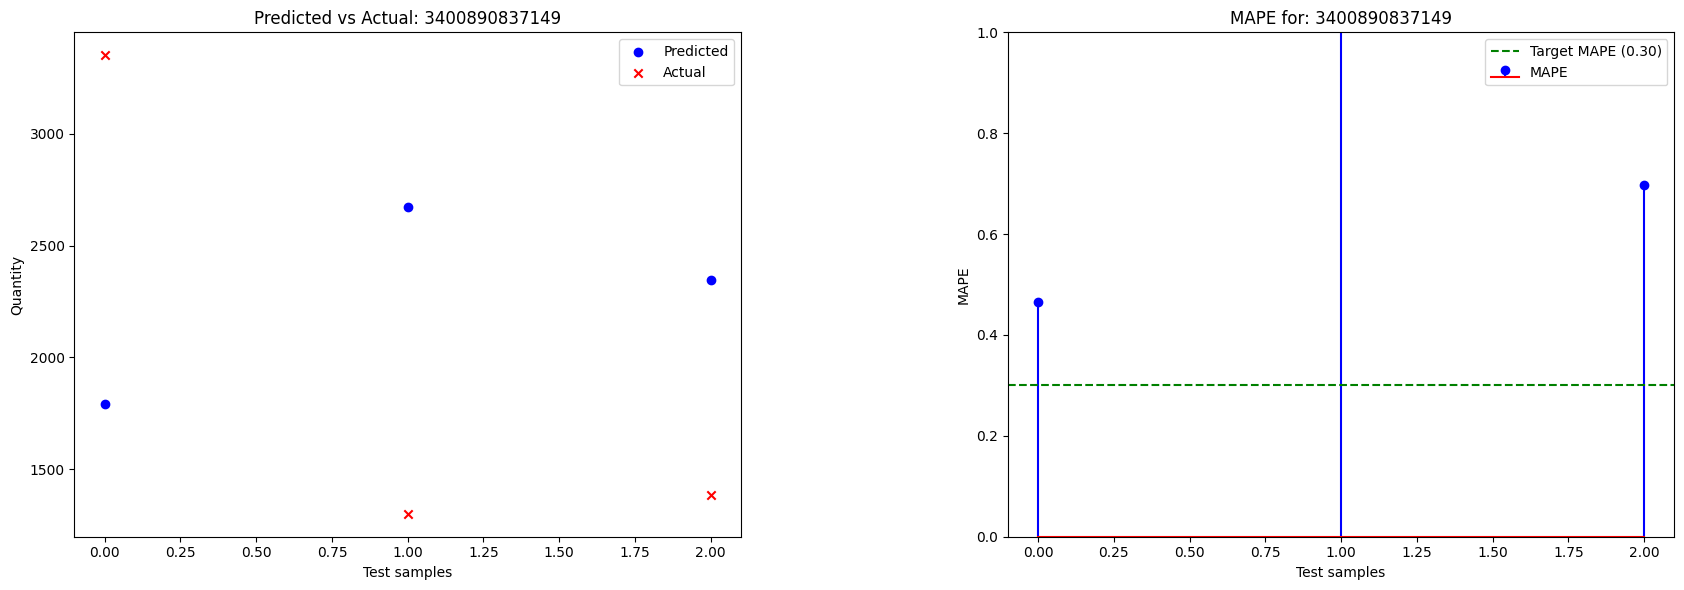



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -12.946
MAE: 902.237
MAPE: 0.319
RMSE: 1099.392



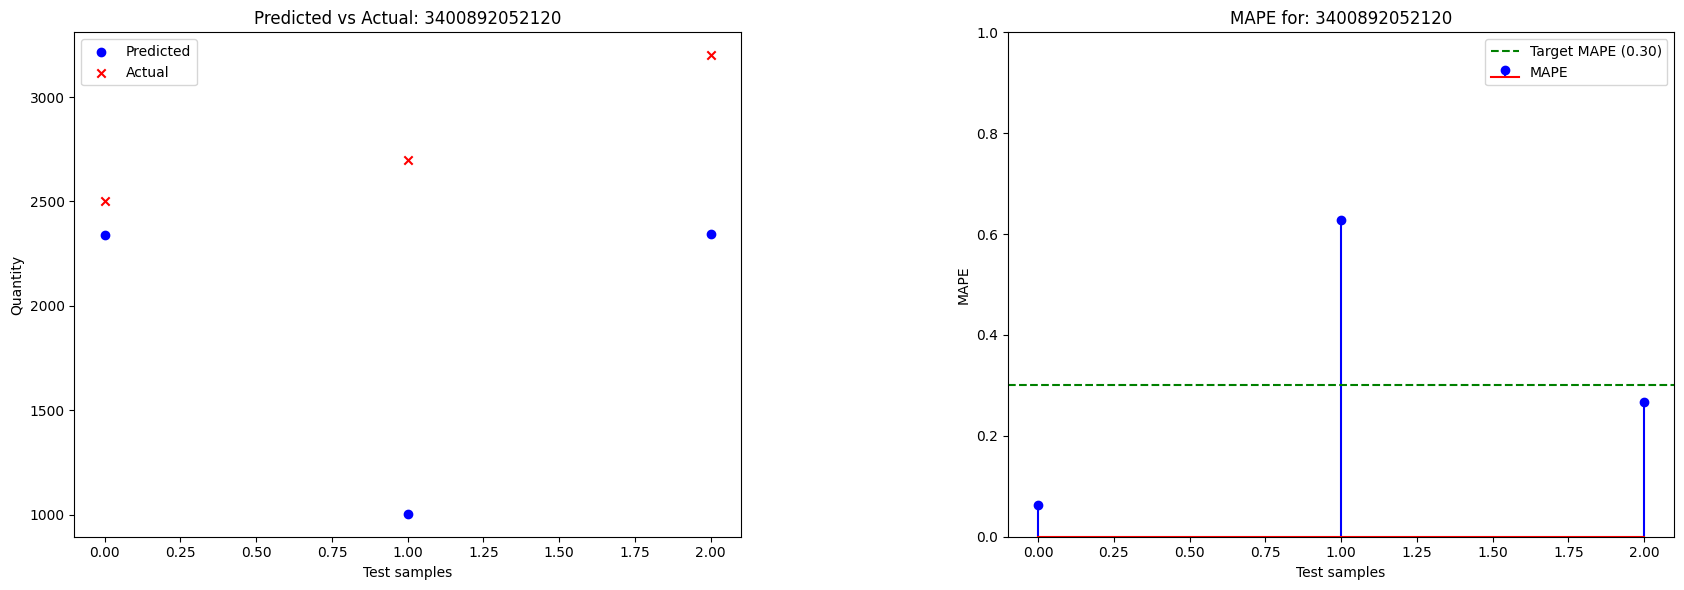



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -5.811
MAE: 2749.867
MAPE: 0.602
RMSE: 2911.962



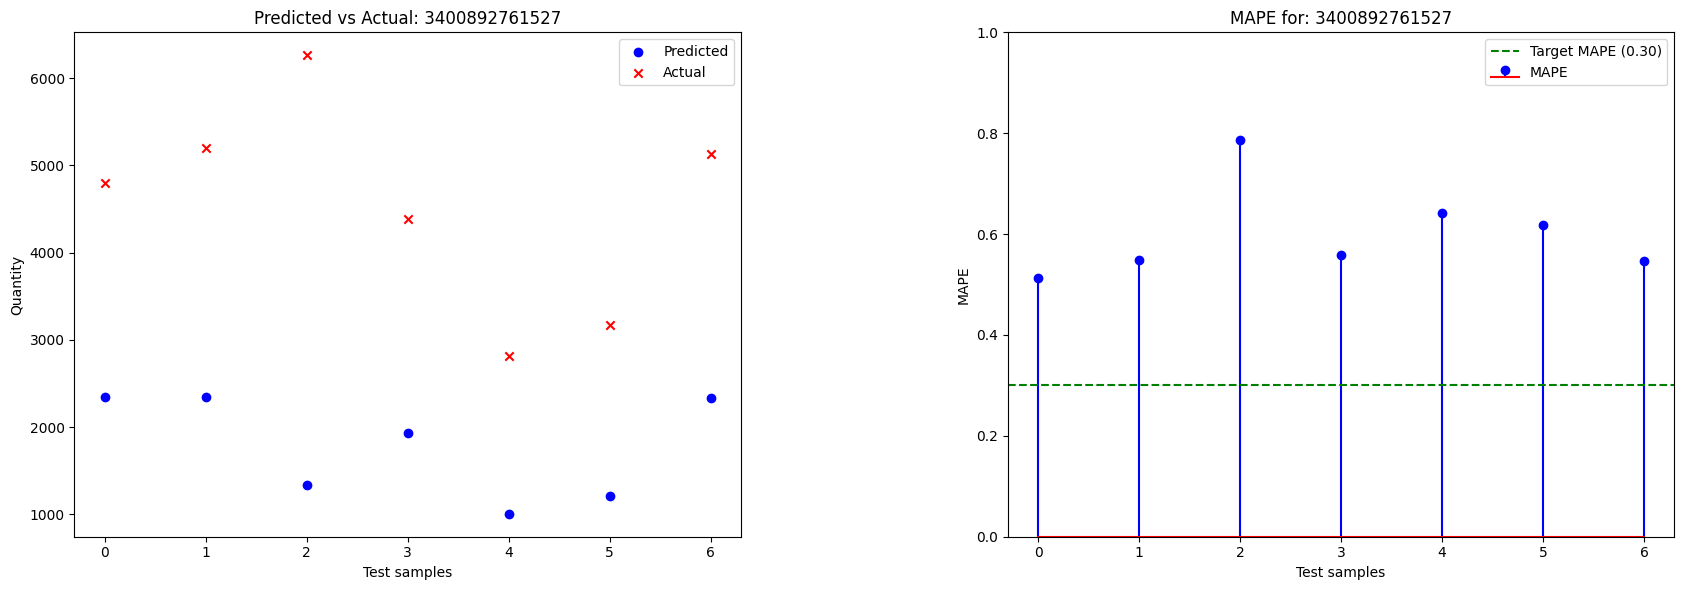



----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -223.749
MAE: 8453.374
MAPE: 0.865
RMSE: 8473.145



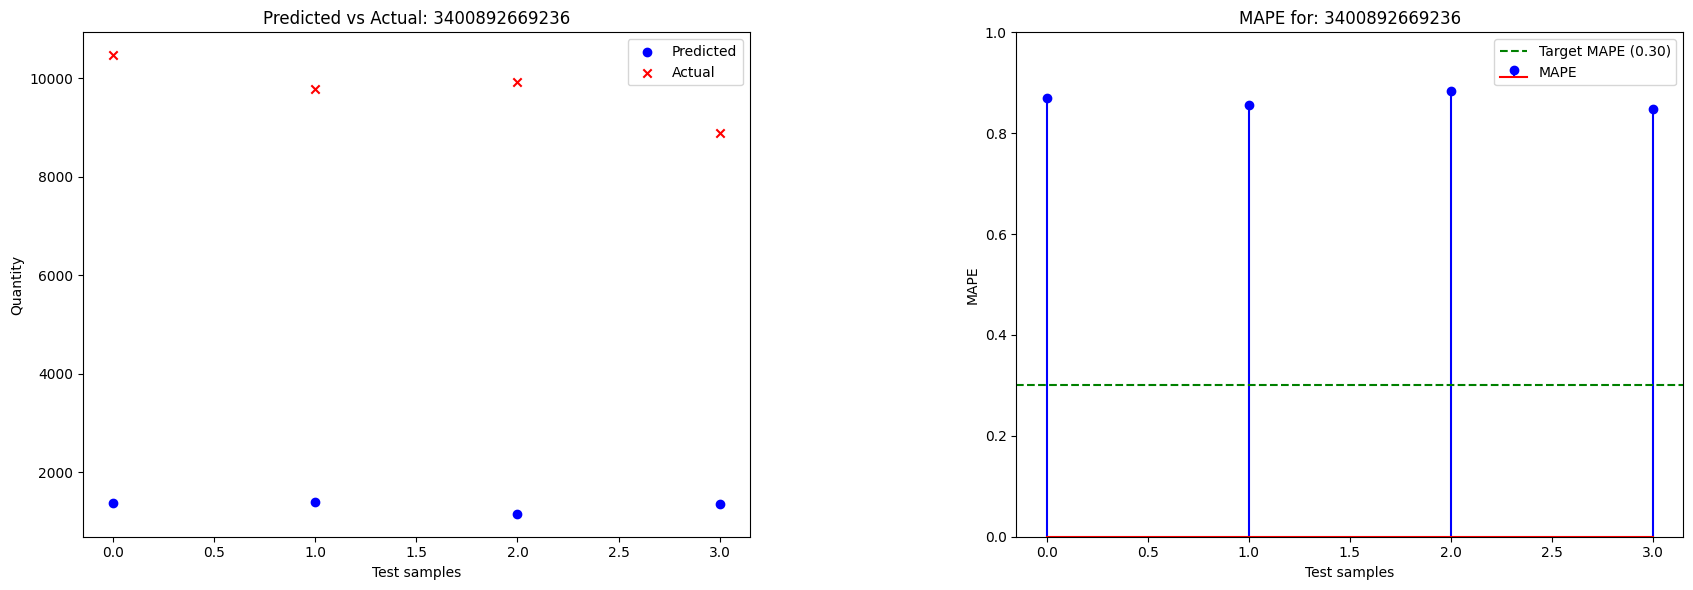



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 10}
Training Score (MAPE):  -23.057
----------Test scores----------
R^2 Score: -0.463
MAE: 312.581
MAPE: 0.153
RMSE: 412.51



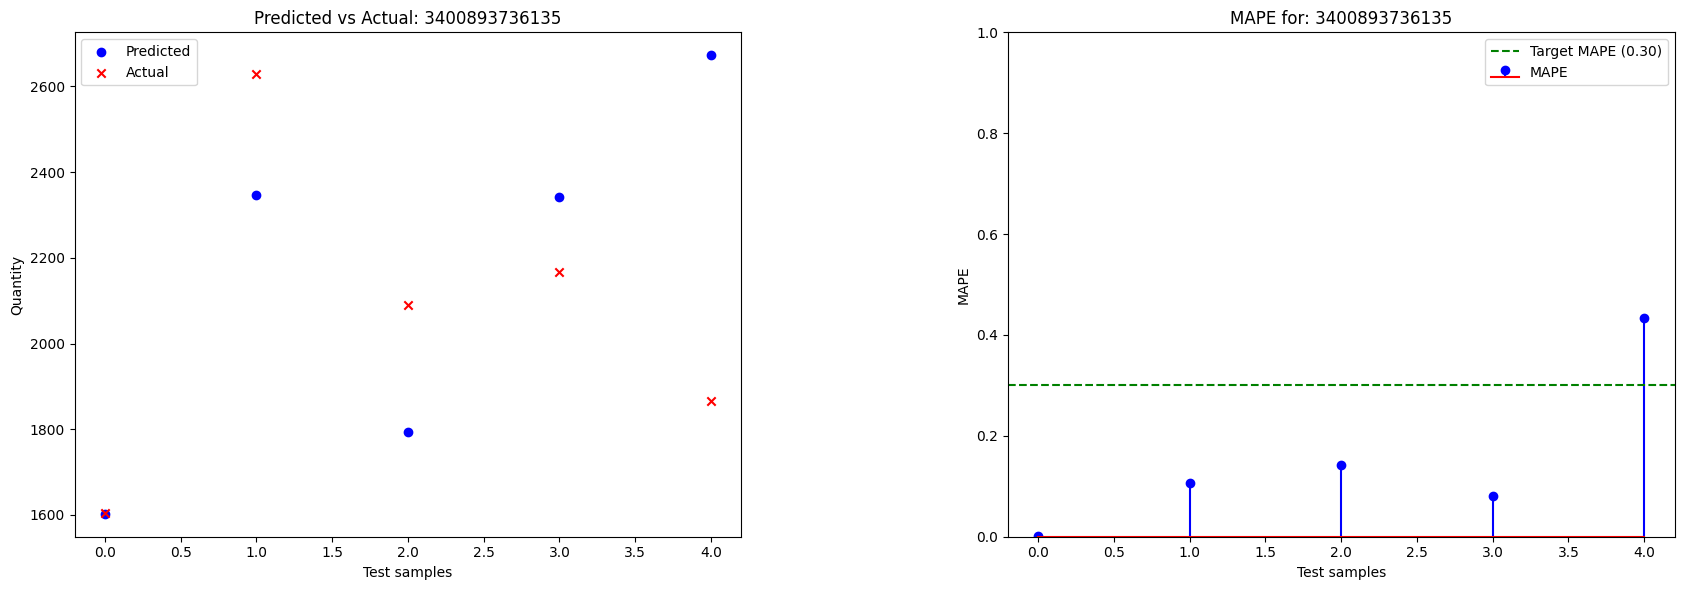



----------------------------------------------------------------------------------------------------
Cluster: 0
Size of data set: 760
Size of training set: 608
Size of test set: 152
Size of grid search: 354
Finished training

----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -148.181
MAE: 21590.167
MAPE: 0.845
RMSE: 21681.987



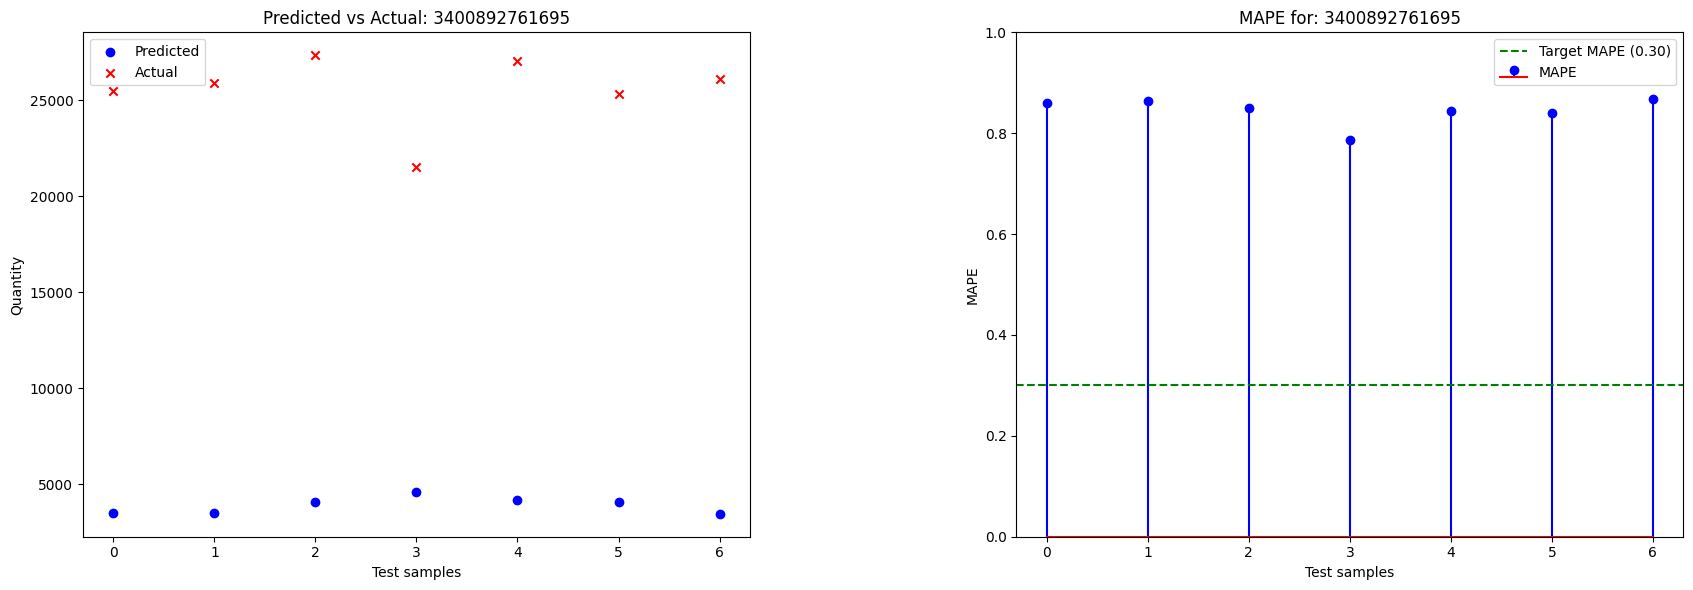



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -143.498
MAE: 2601.168
MAPE: 1.631
RMSE: 2641.721



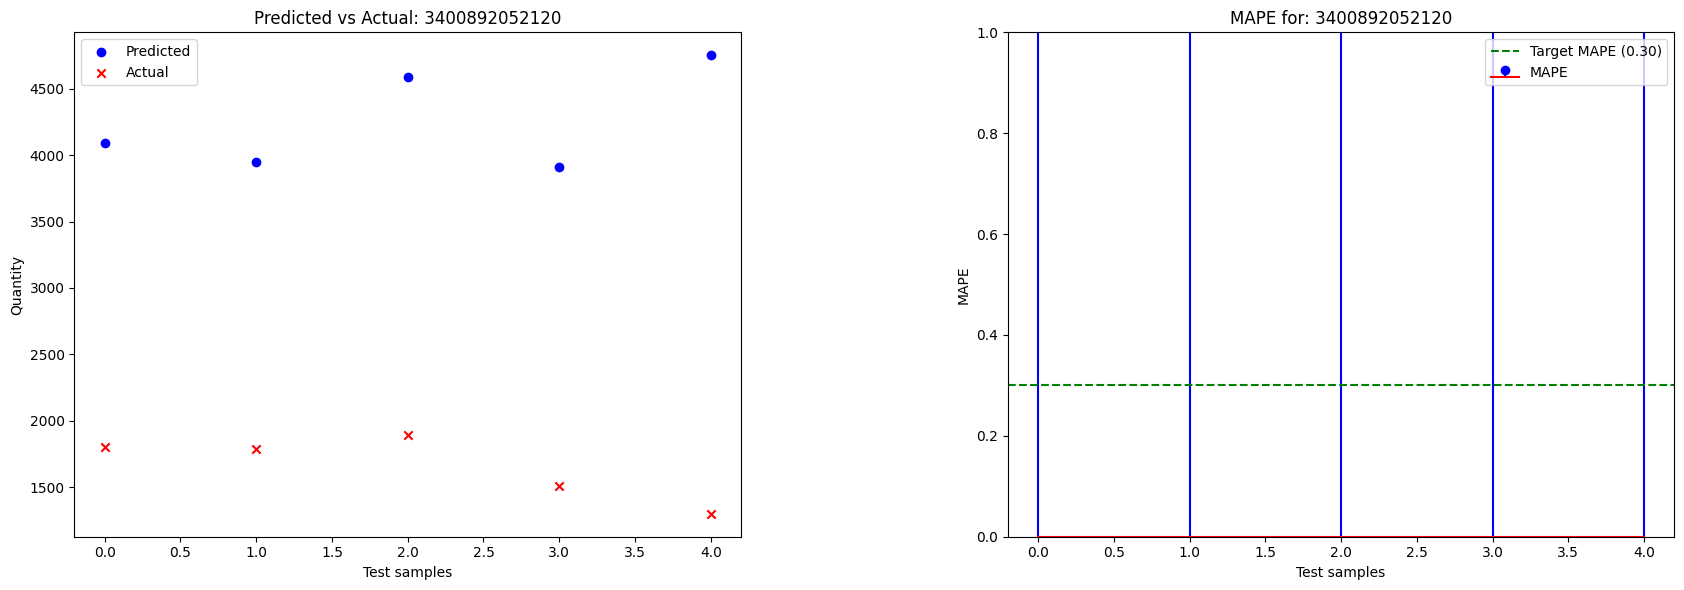



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -5.119
MAE: 1083.458
MAPE: 0.199
RMSE: 1330.683



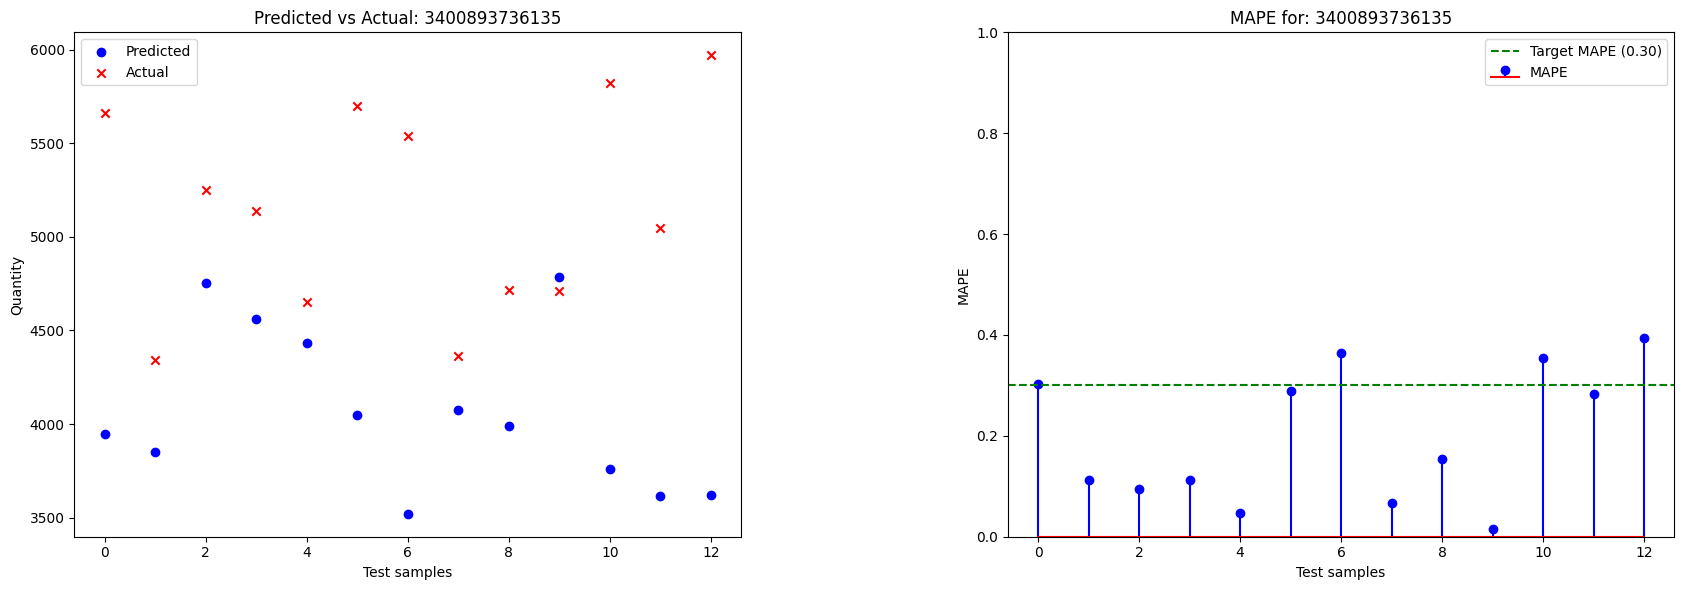



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -1.232
MAE: 443.815
MAPE: 0.095
RMSE: 643.788



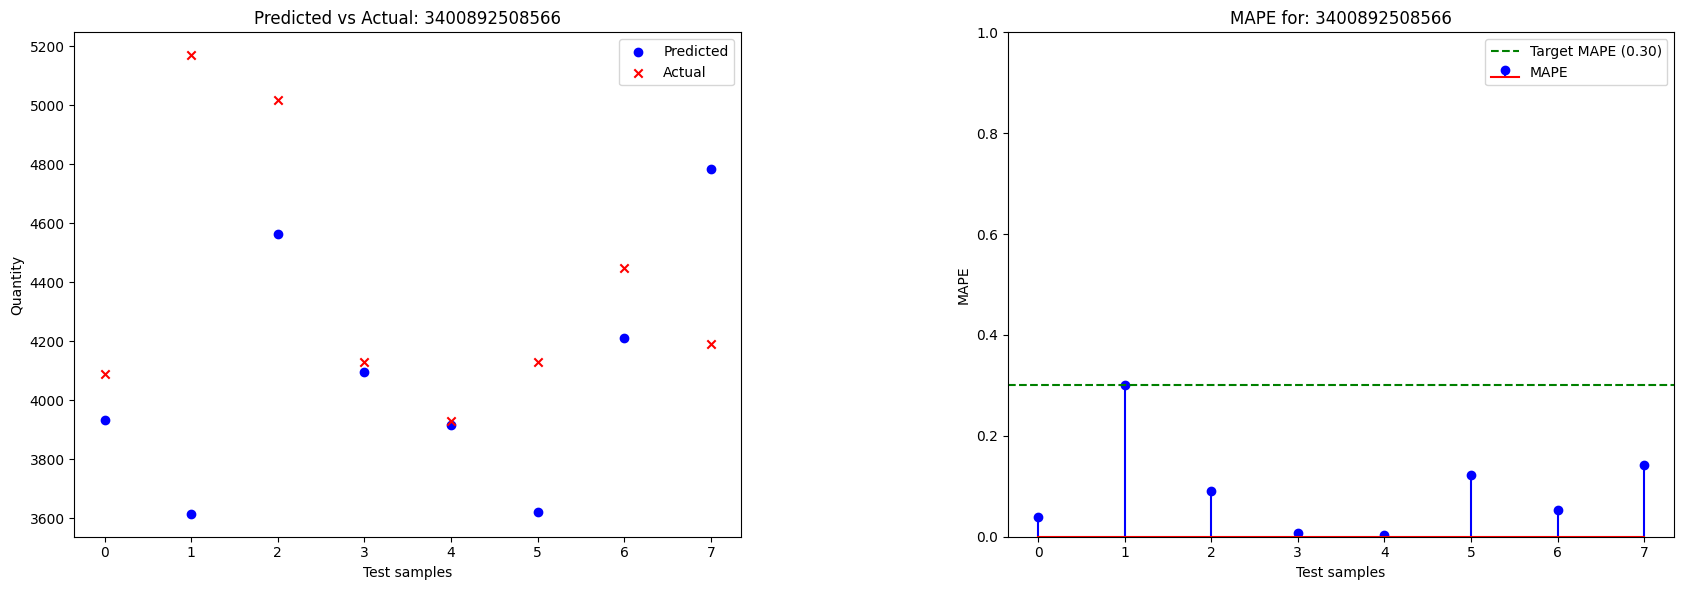



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -116.051
MAE: 10276.394
MAPE: 0.711
RMSE: 10329.213



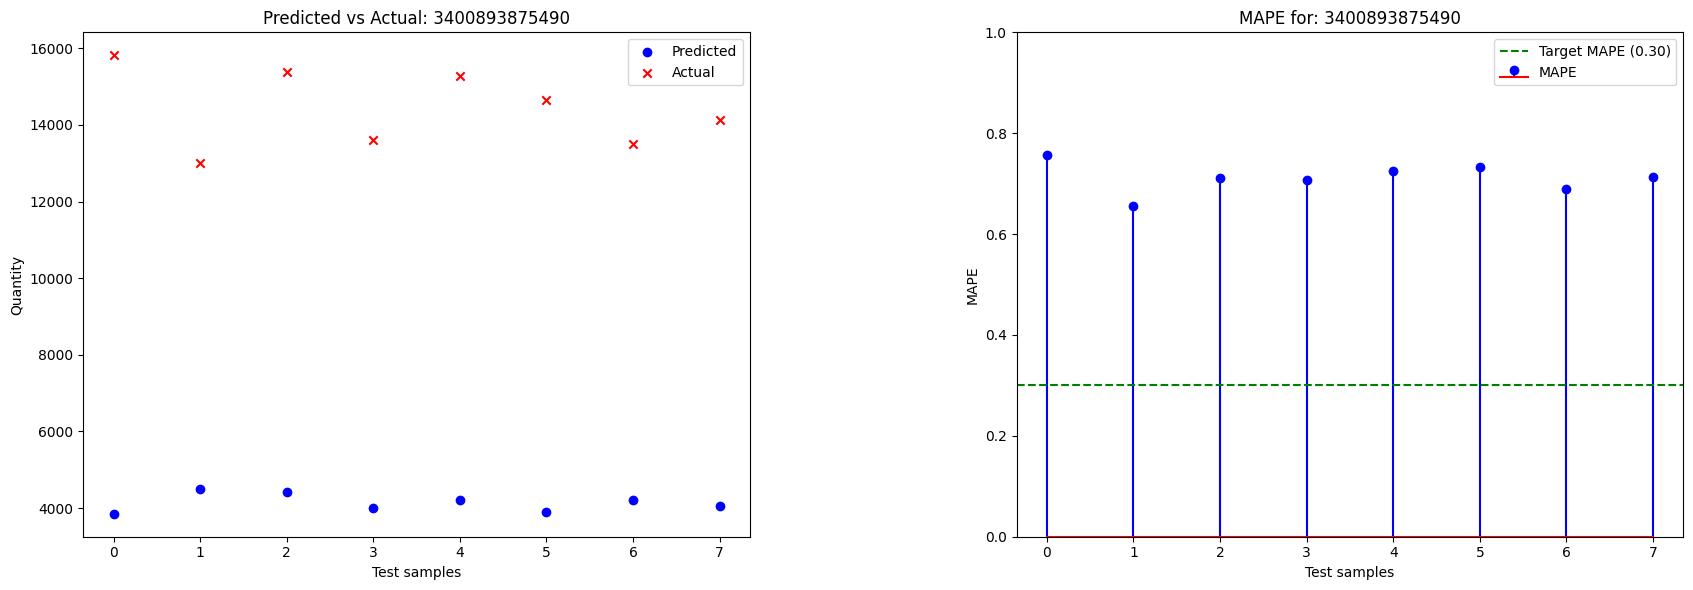



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -11.277
MAE: 1617.798
MAPE: 0.283
RMSE: 1724.025



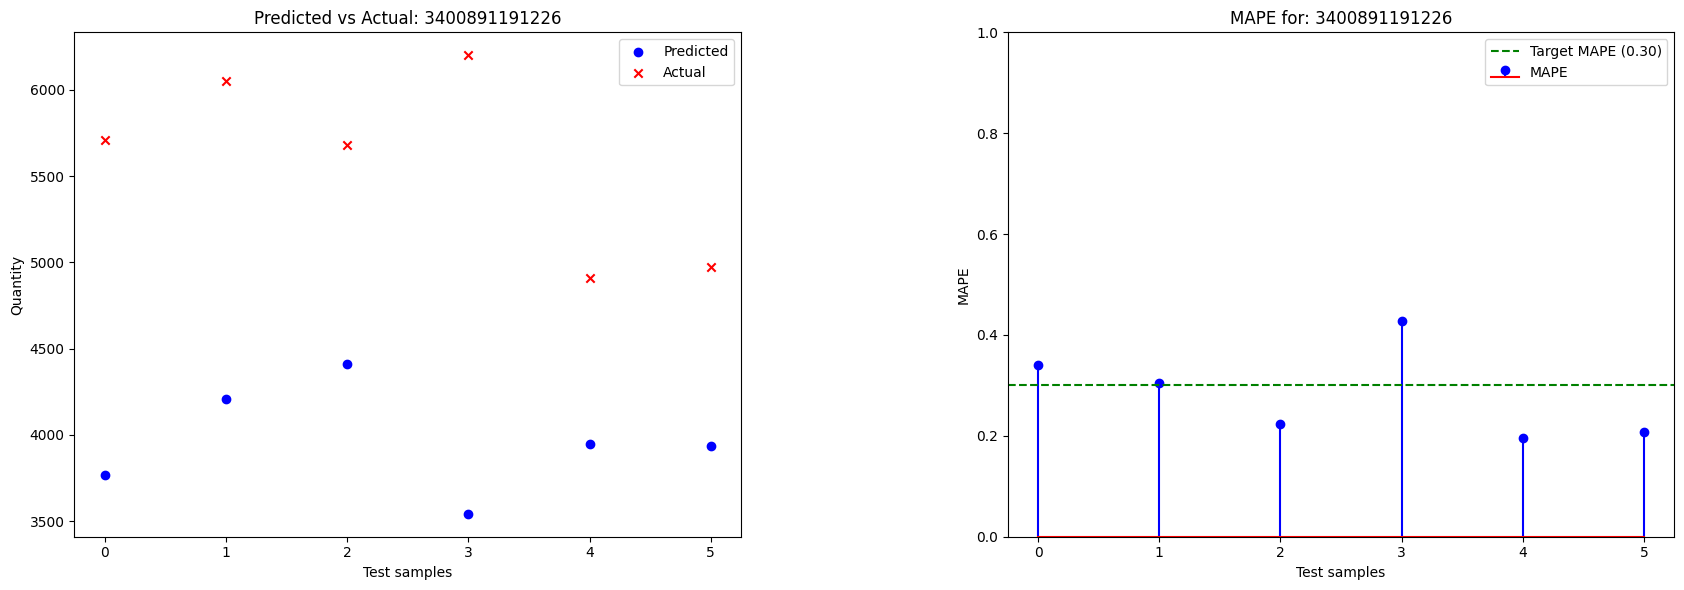



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -9.796
MAE: 2333.734
MAPE: 0.355
RMSE: 2499.41



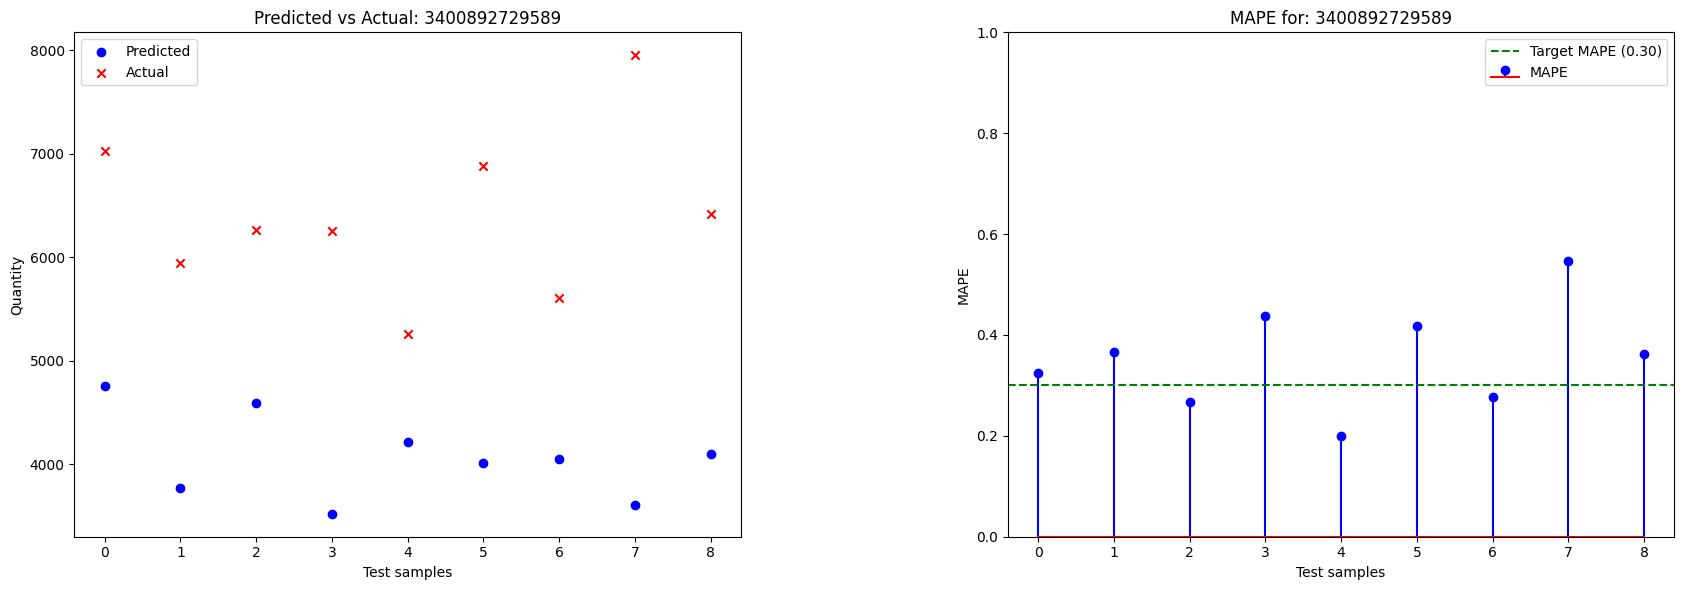



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -0.584
MAE: 701.138
MAPE: 0.198
RMSE: 871.546



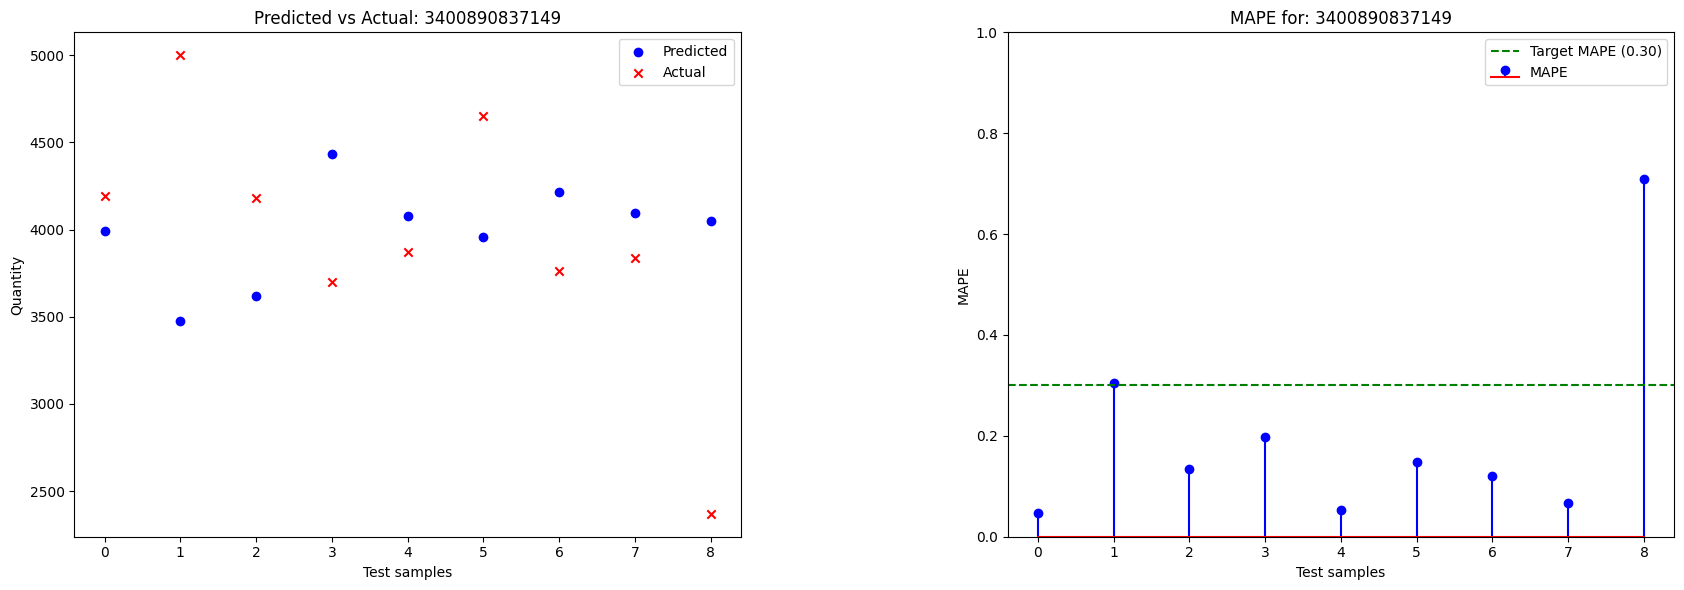



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -9.482
MAE: 3688.911
MAPE: 0.465
RMSE: 3922.353



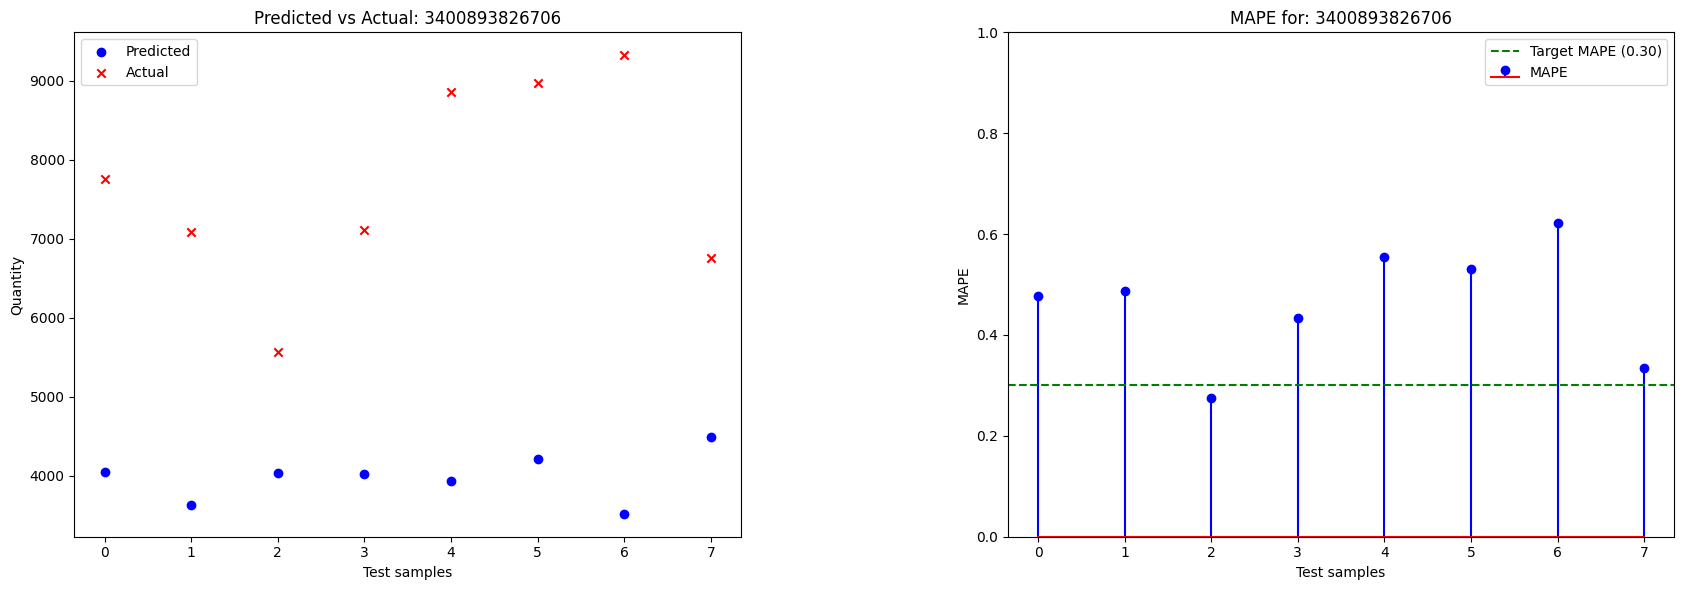



----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -186.839
MAE: 6690.001
MAPE: 0.625
RMSE: 6715.482



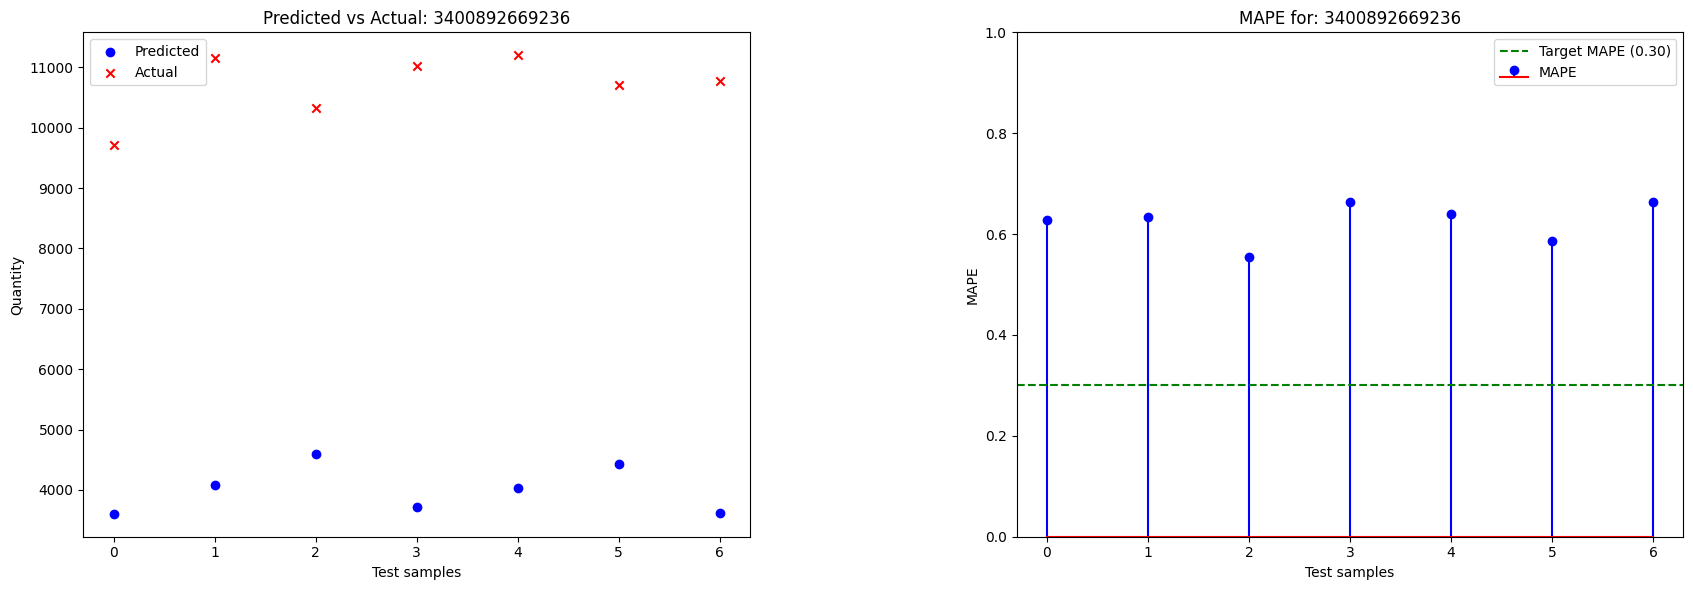



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -7.8
MAE: 1378.394
MAPE: 0.58
RMSE: 1524.874



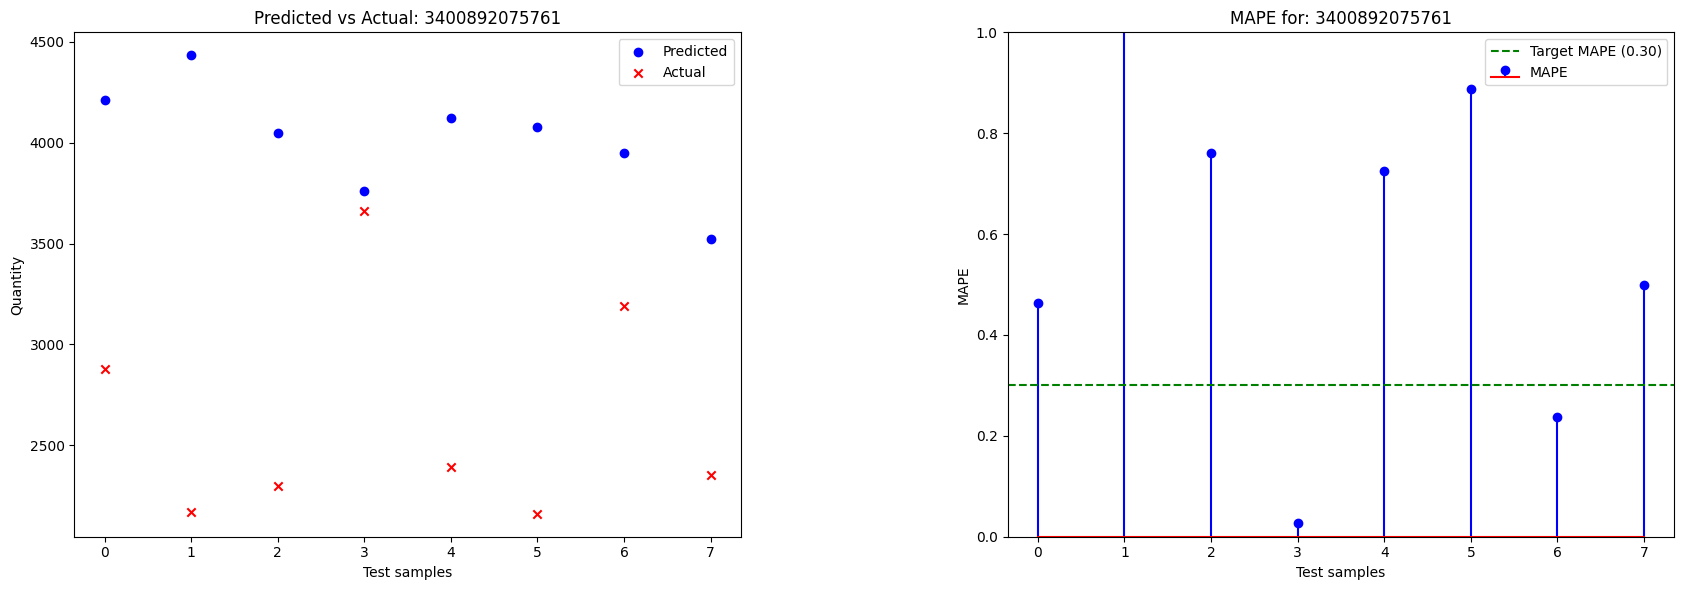



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -2.325
MAE: 1052.164
MAPE: 0.191
RMSE: 1354.629



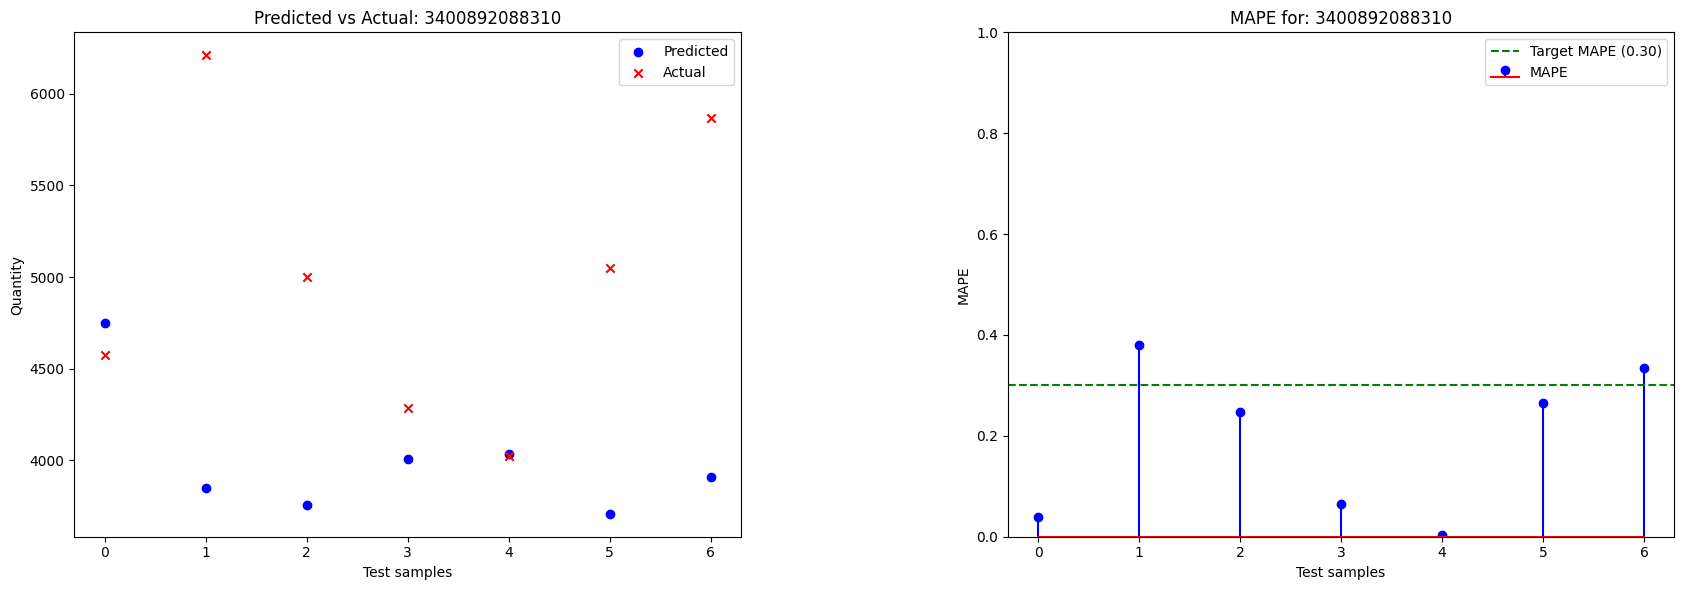



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -27.557
MAE: 6155.196
MAPE: 0.611
RMSE: 6287.019



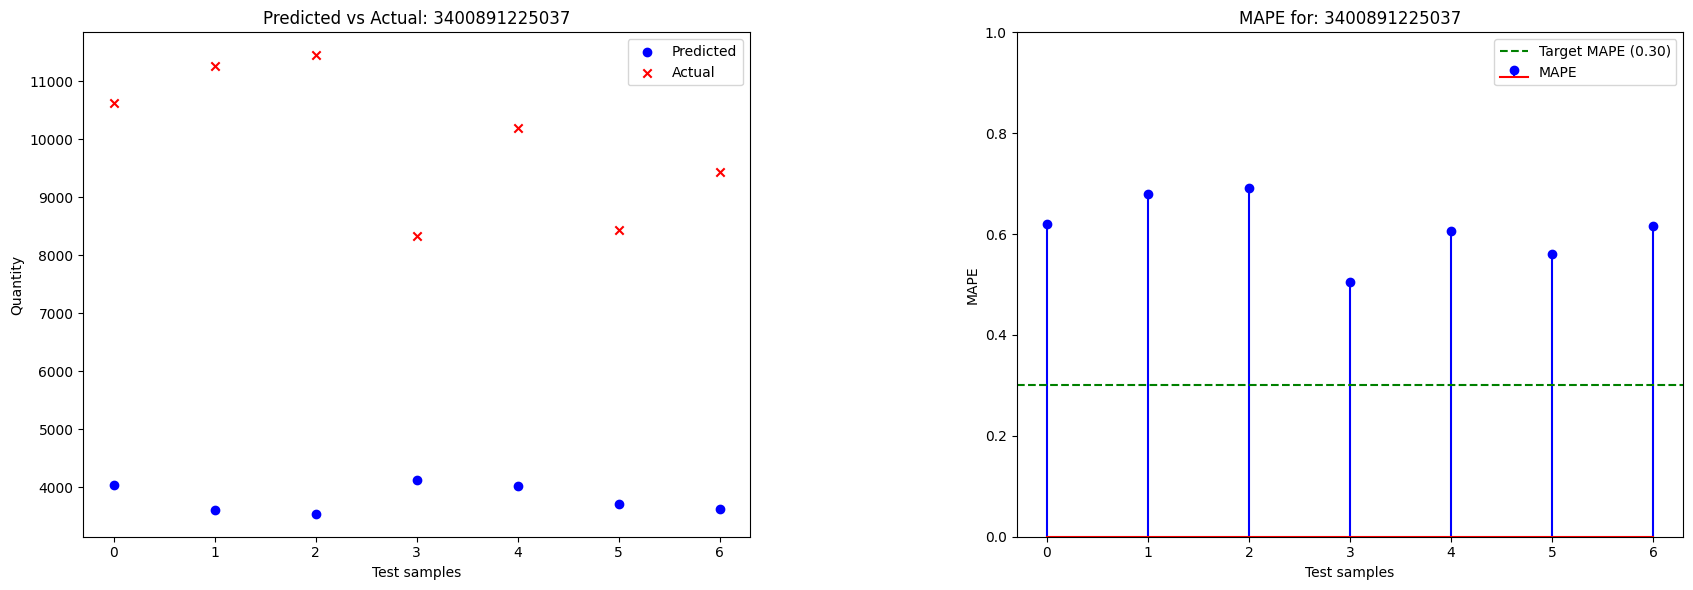



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -32.079
MAE: 2214.555
MAPE: 1.316
RMSE: 2297.684



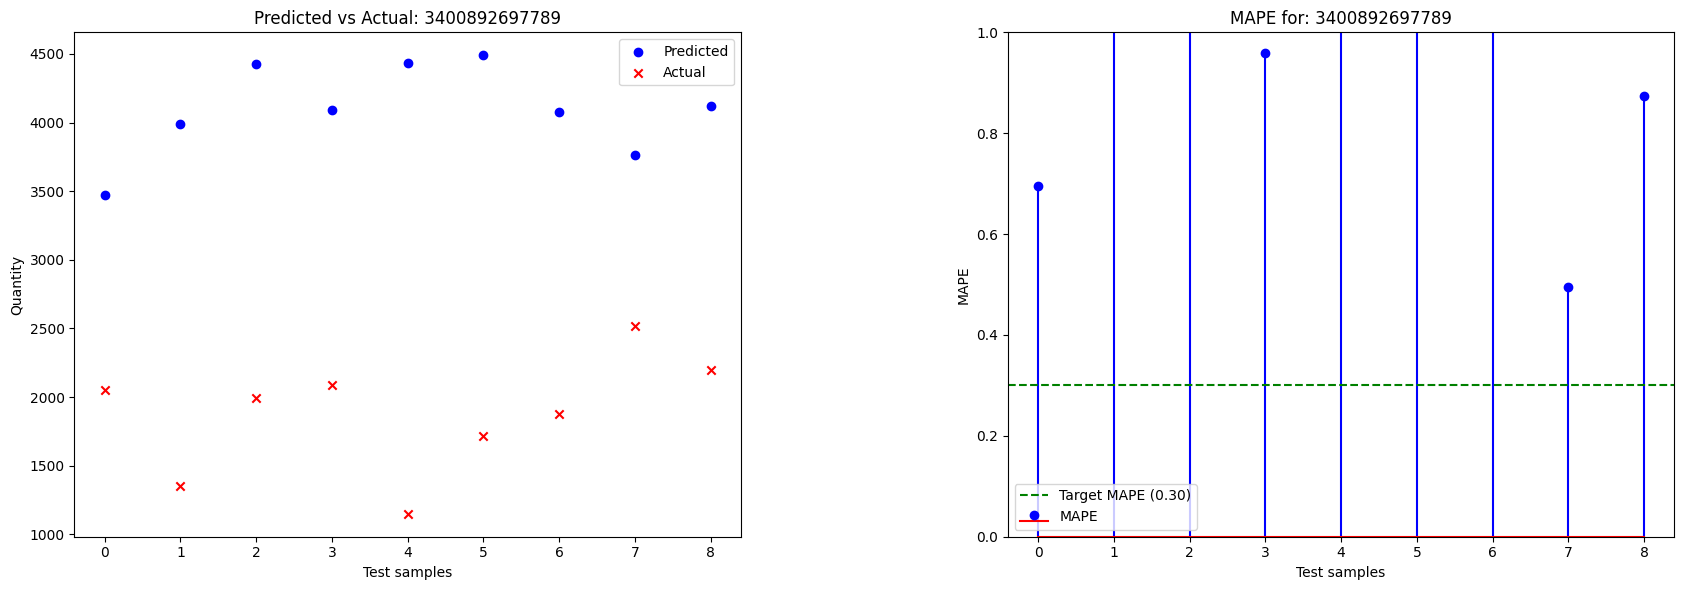



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -1.67
MAE: 2611.288
MAPE: 13.372
RMSE: 3190.016



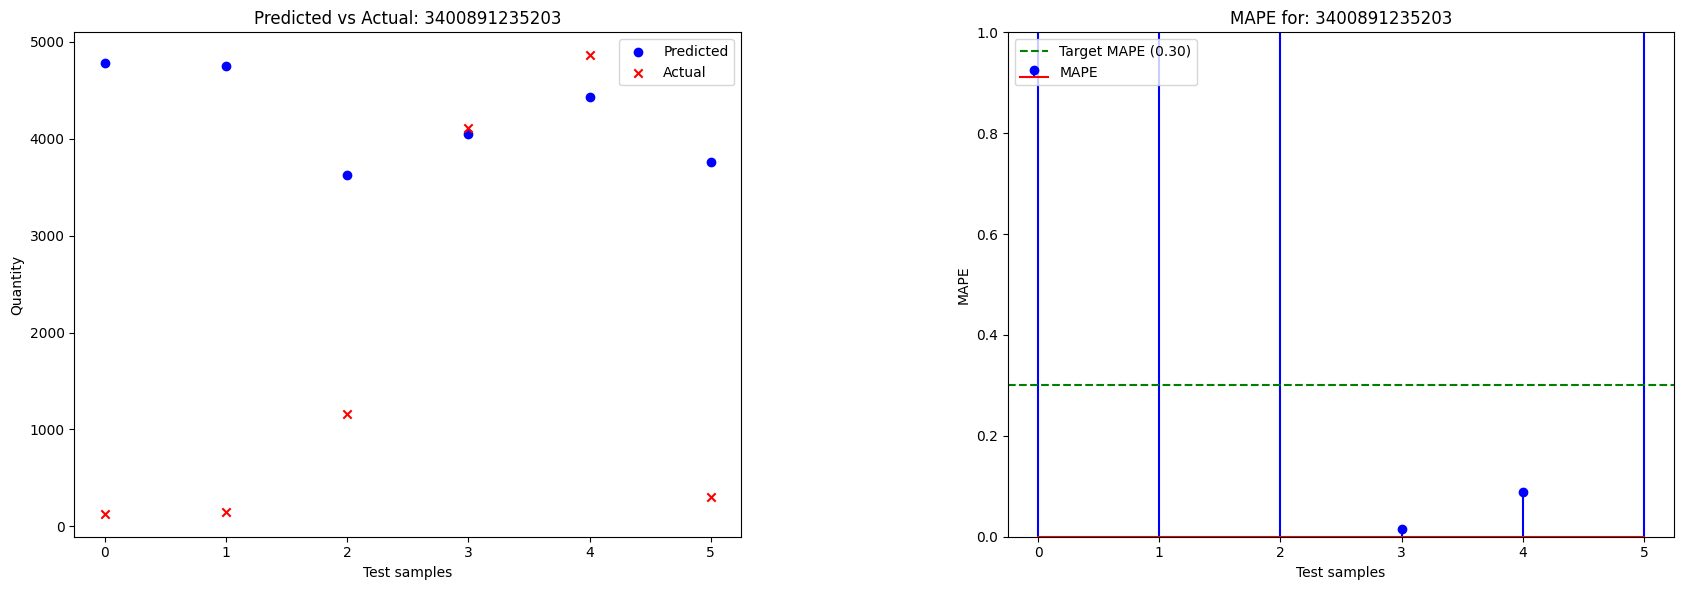



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -134.368
MAE: 25244.539
MAPE: 0.859
RMSE: 25362.987



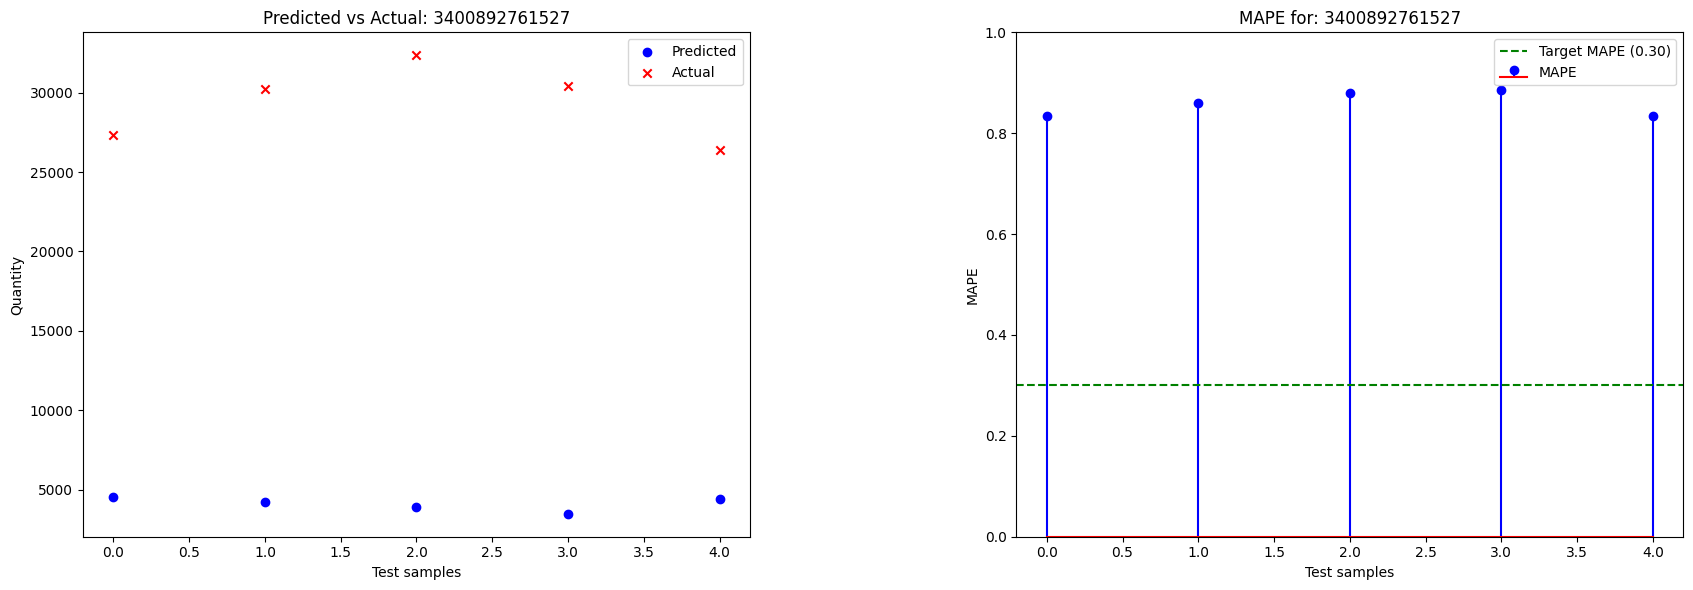



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -7.407
MAE: 1403.003
MAPE: 0.255
RMSE: 1482.752



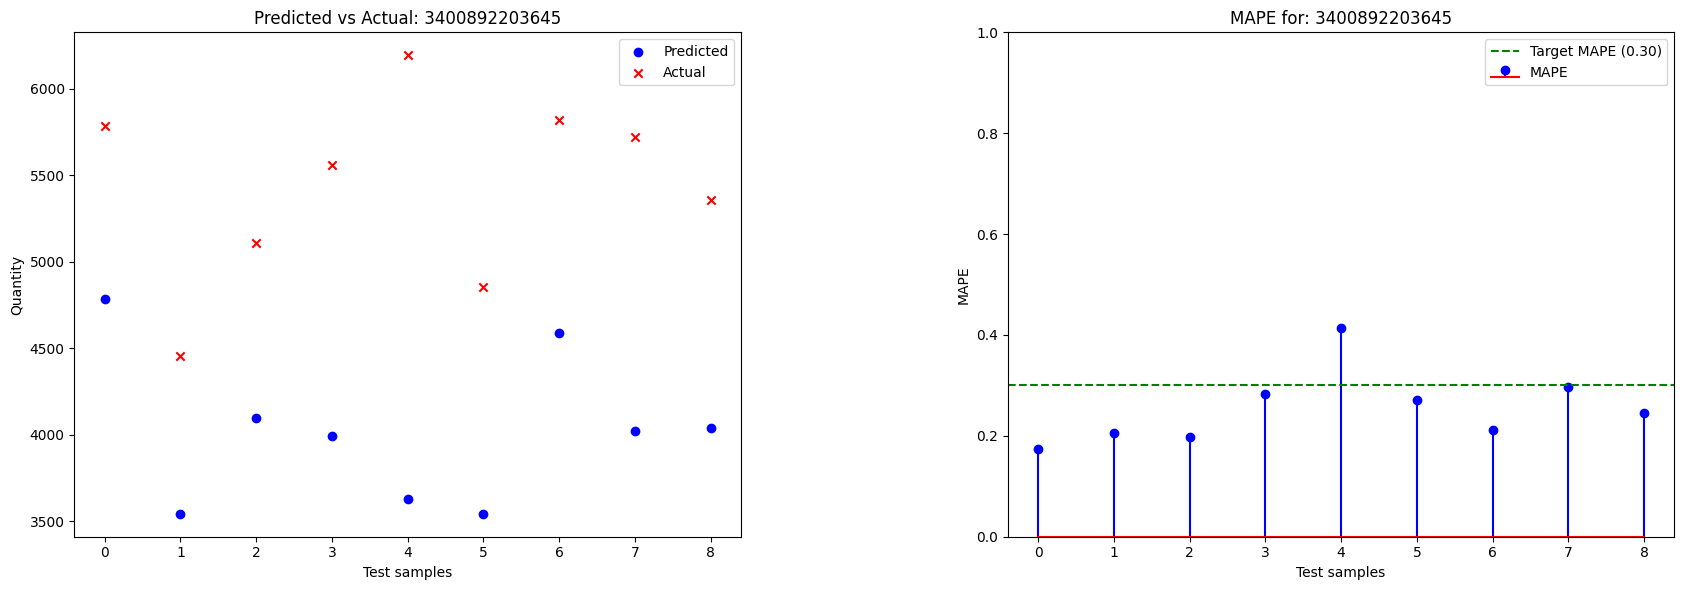



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -900.359
MAE: 3670.265
MAPE: 8.057
RMSE: 3685.911



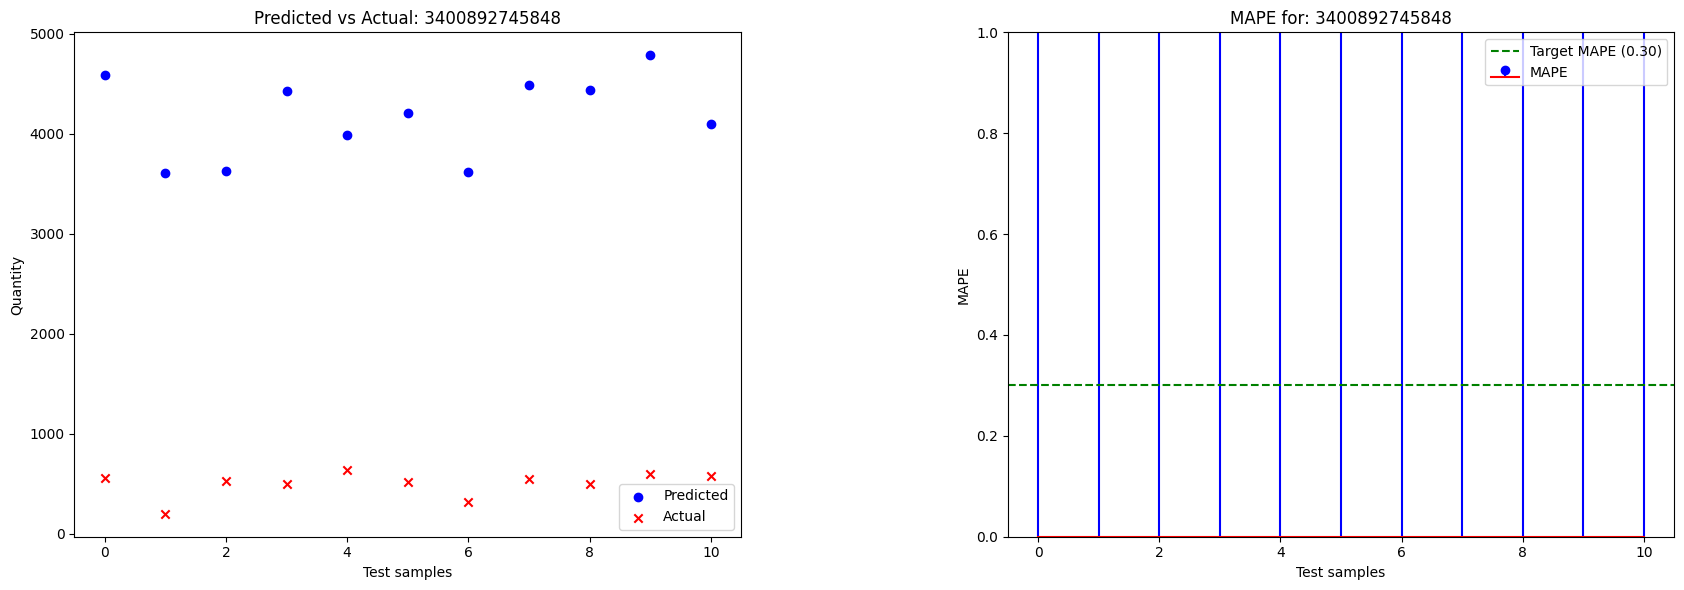



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -1.507
MAE: 697.697
MAPE: 0.194
RMSE: 779.003



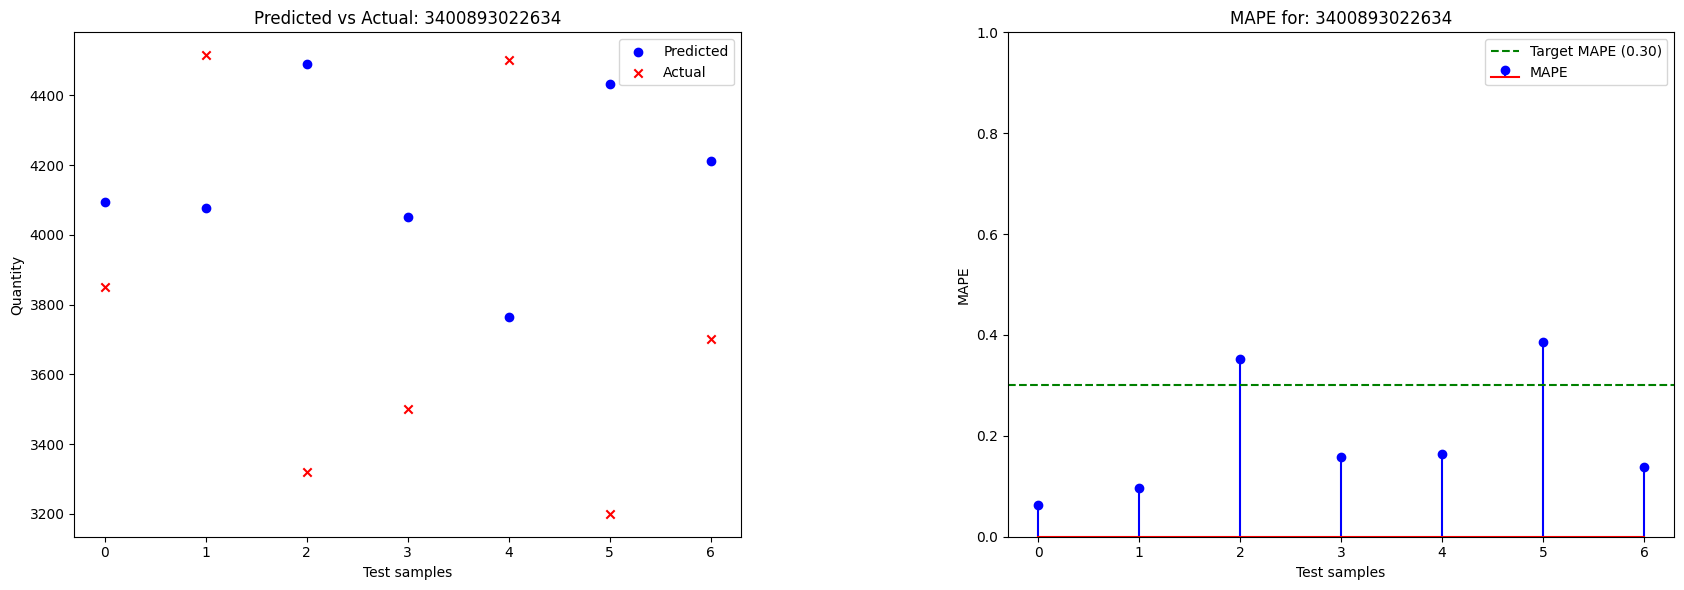



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 21}
Training Score (MAPE):  -1.049
----------Test scores----------
R^2 Score: -689.103
MAE: 3555.183
MAPE: 0.473
RMSE: 3565.561



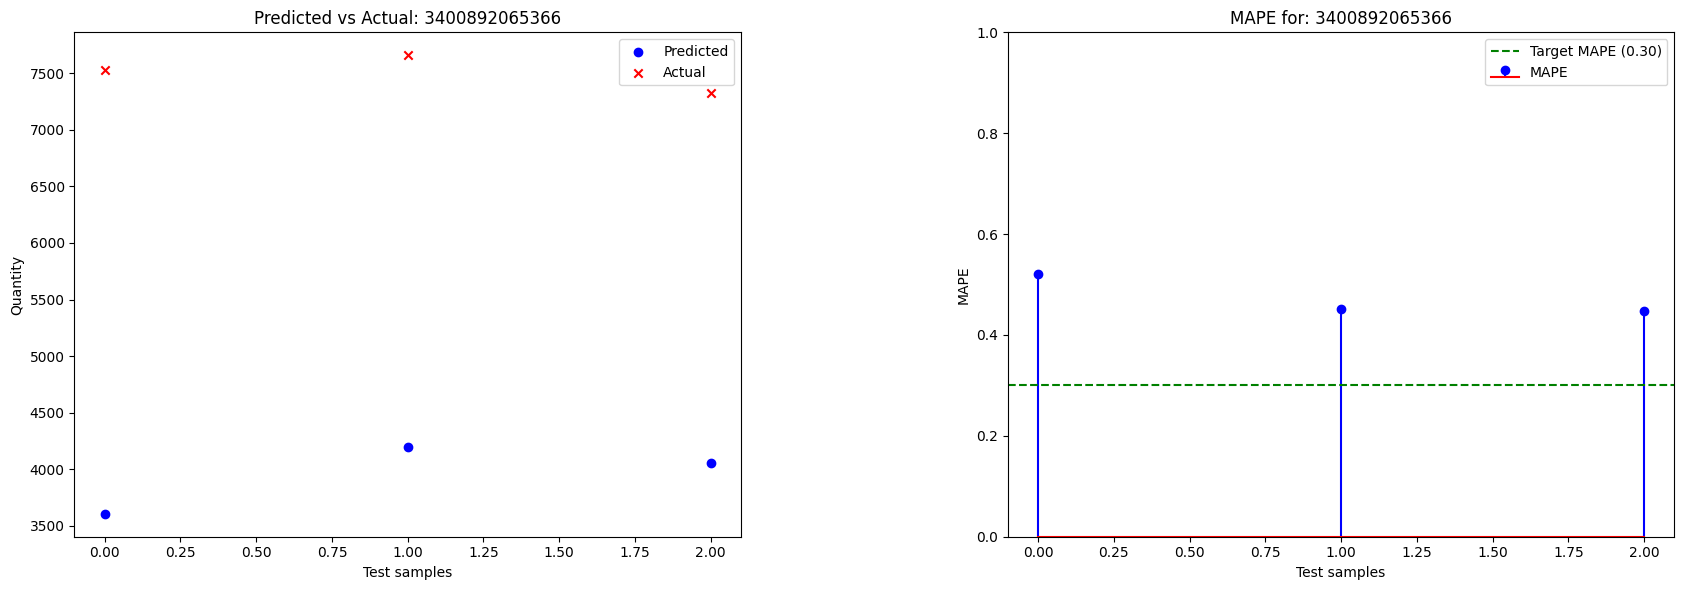



----------------------------------------------------------------------------------------------------
Cluster: 1
Size of data set: 712
Size of training set: 569
Size of test set: 143
Size of grid search: 330
Finished training

----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -4.74
MAE: 10653.003
MAPE: 0.485
RMSE: 11593.721



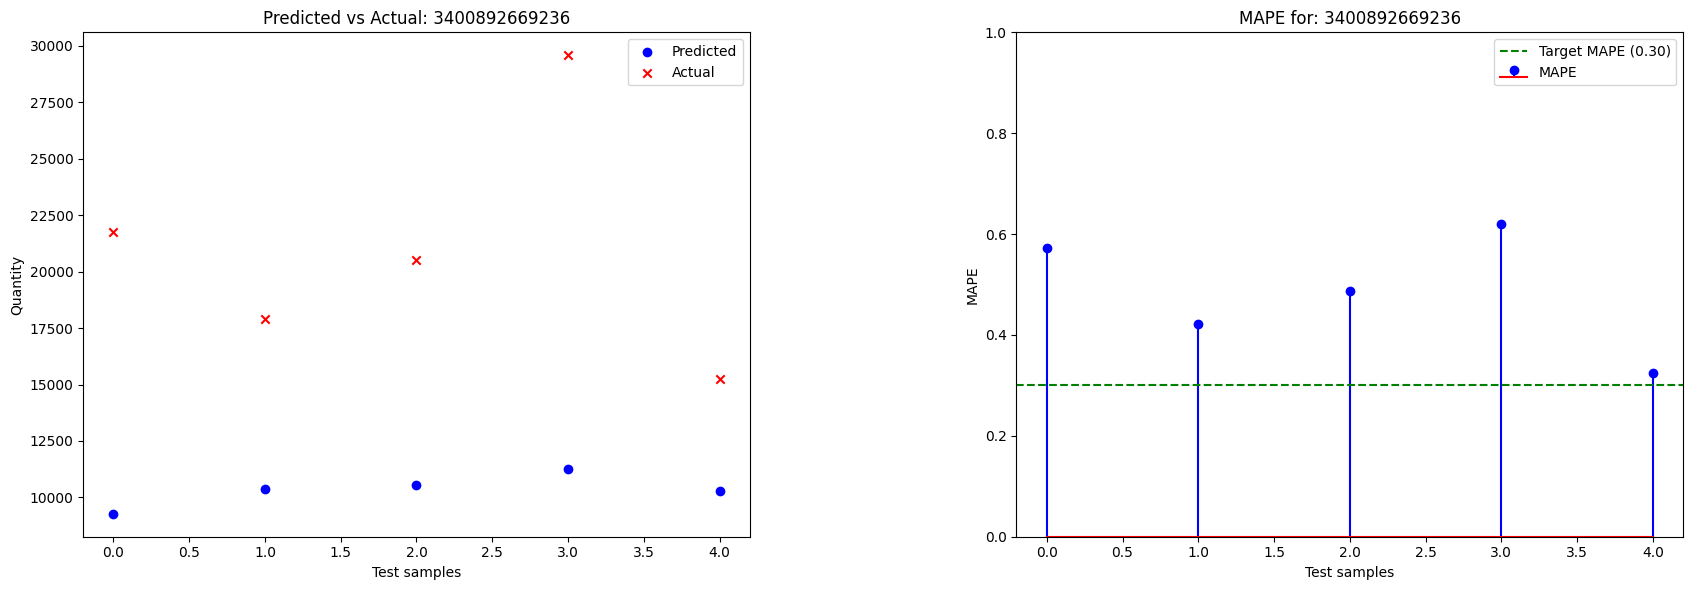



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -2.183
MAE: 4794.572
MAPE: 0.275
RMSE: 5589.614



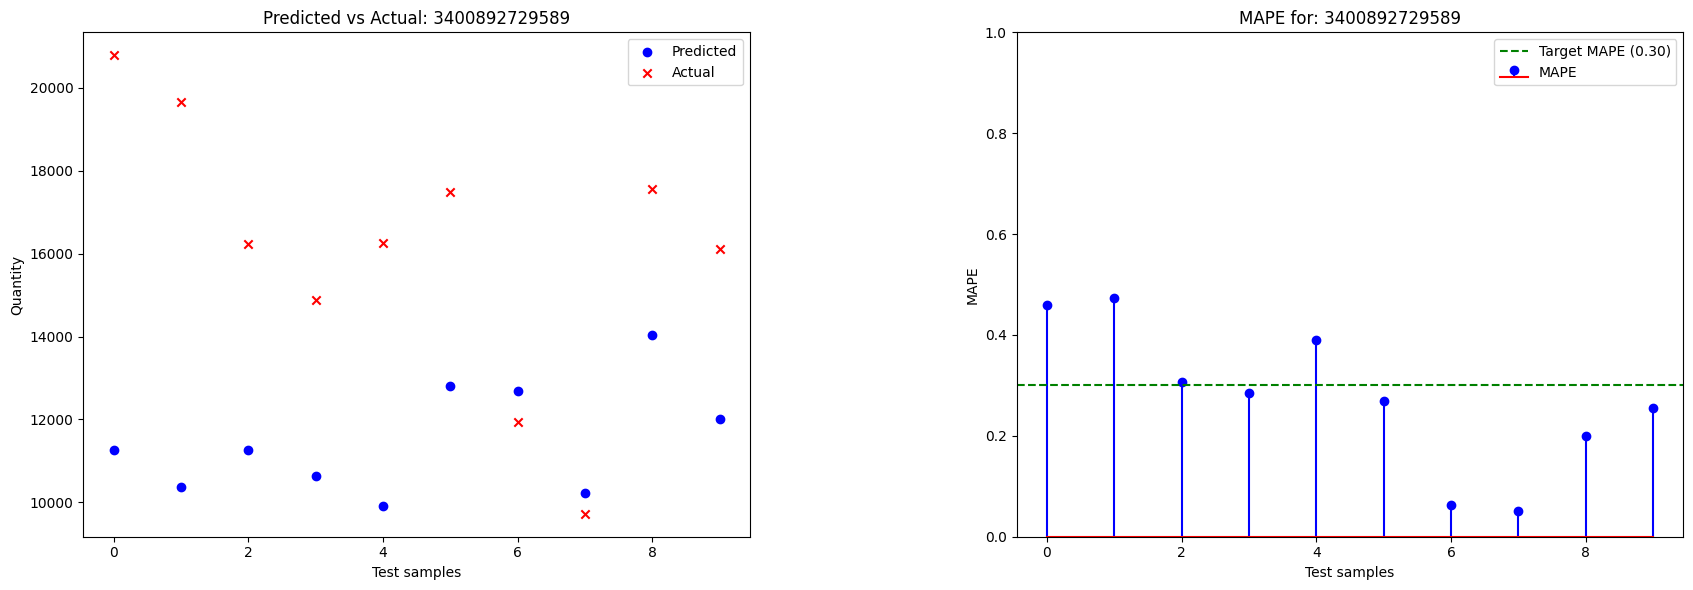



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: 0.363
MAE: 1809.188
MAPE: 0.159
RMSE: 2103.811



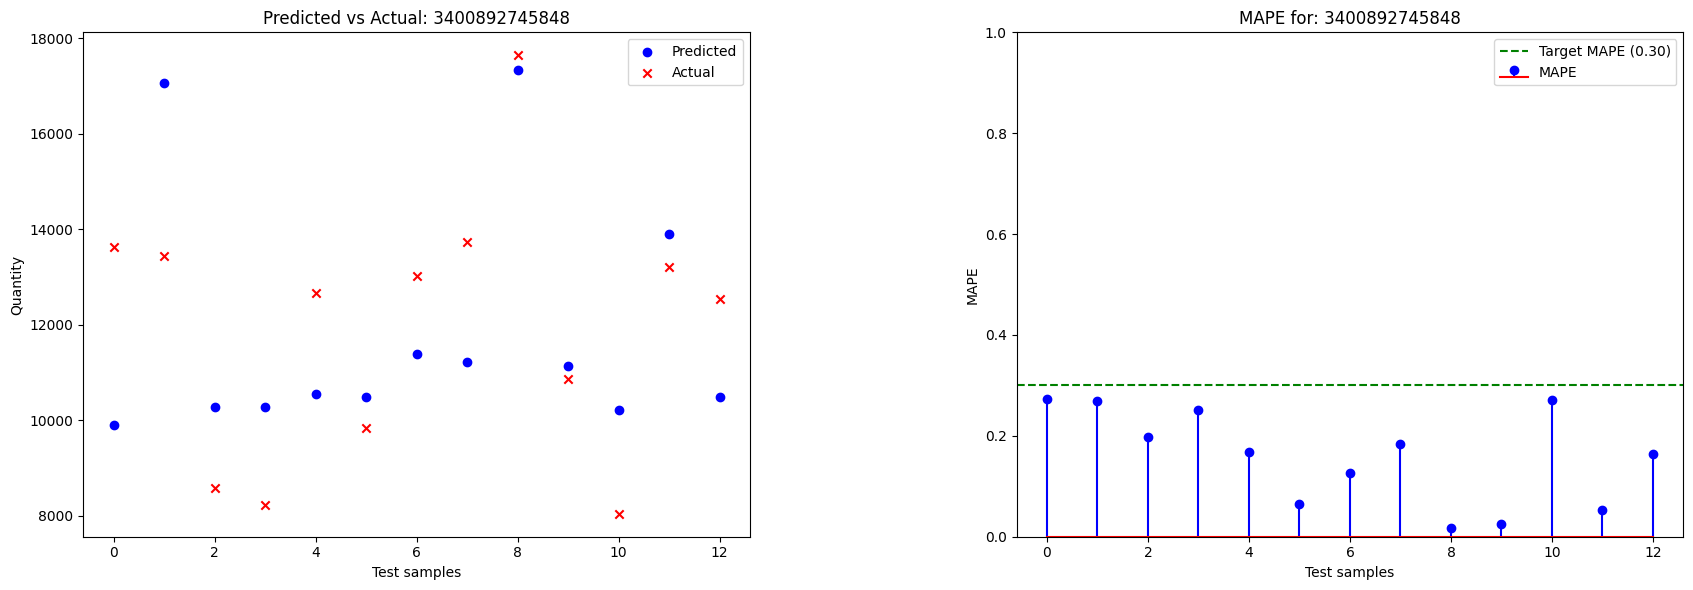



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -8.778
MAE: 4877.659
MAPE: 0.93
RMSE: 5260.698



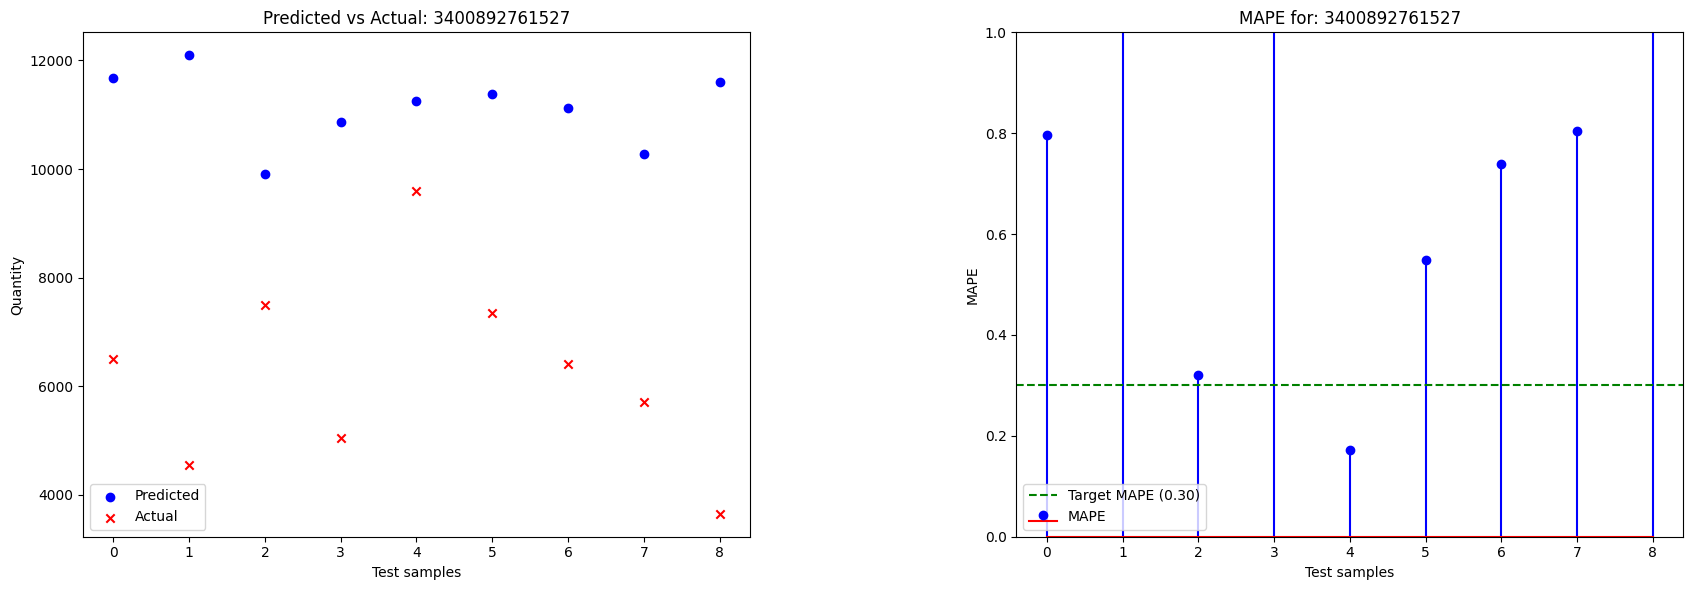



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -23.132
MAE: 5290.097
MAPE: 1.138
RMSE: 5426.904



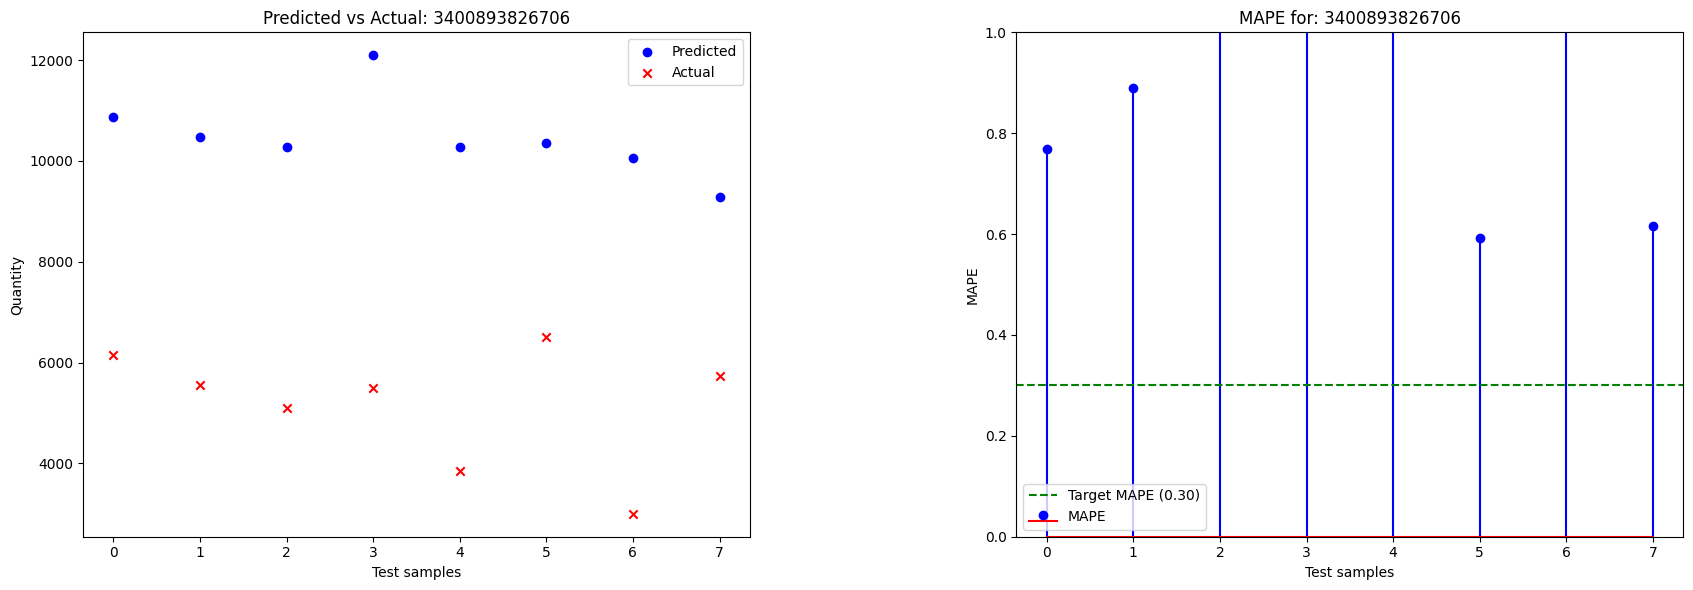



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -9.008
MAE: 3421.883
MAPE: 0.508
RMSE: 3855.77



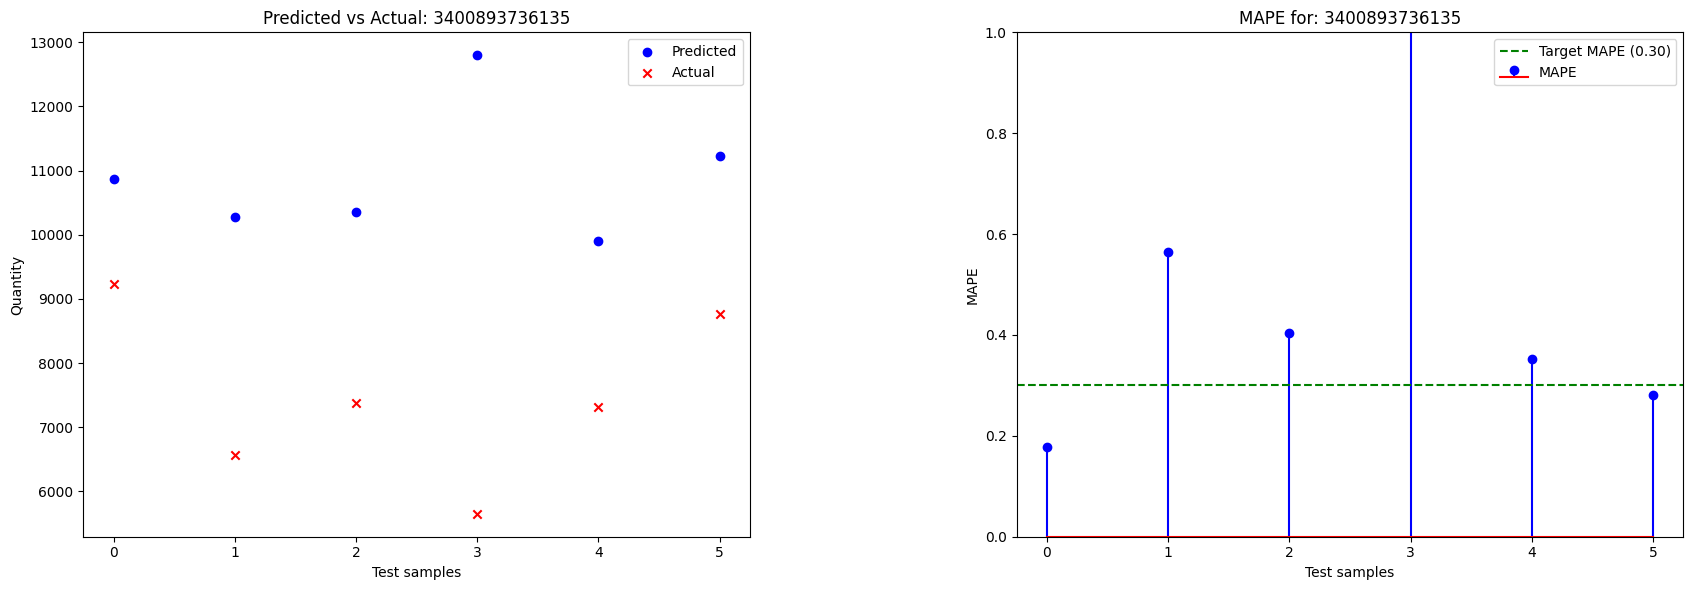



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -0.253
MAE: 1416.072
MAPE: 0.172
RMSE: 1783.691



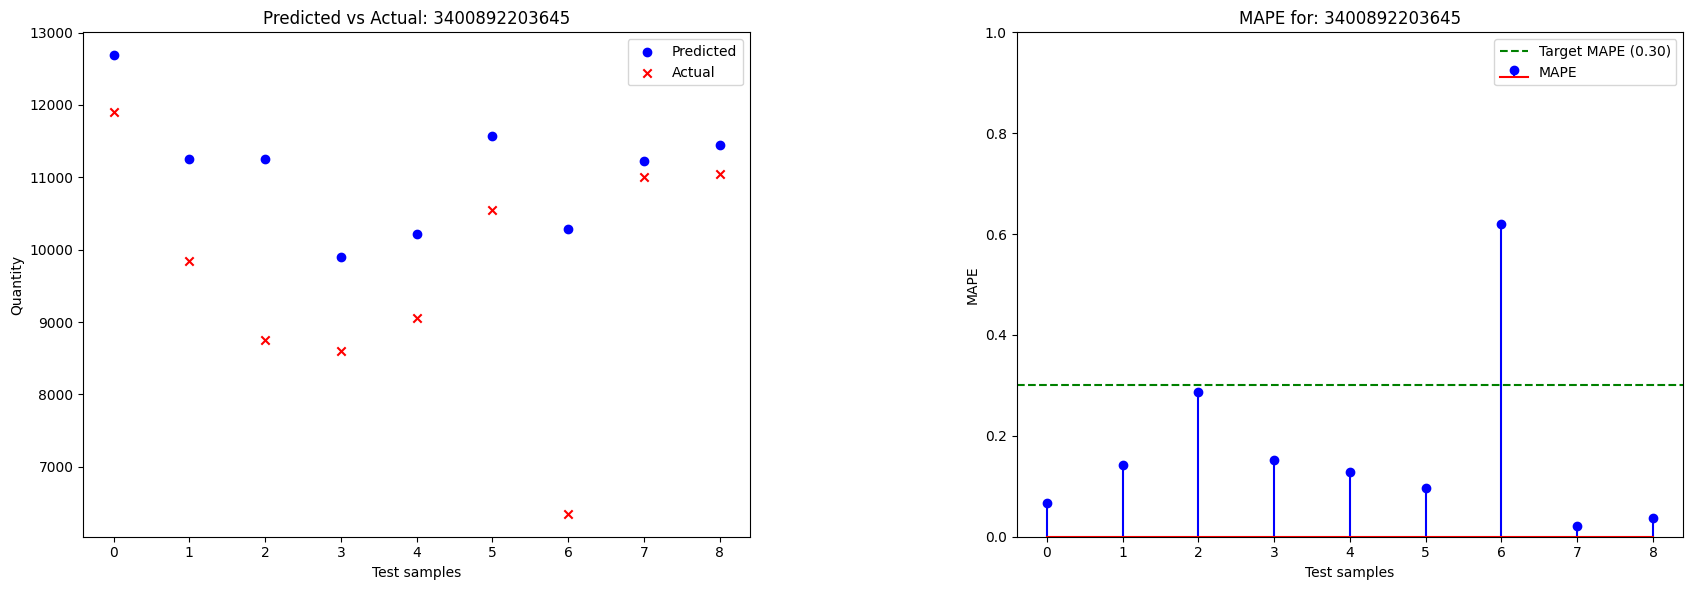



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -113.347
MAE: 10982.651
MAPE: 0.507
RMSE: 11035.627



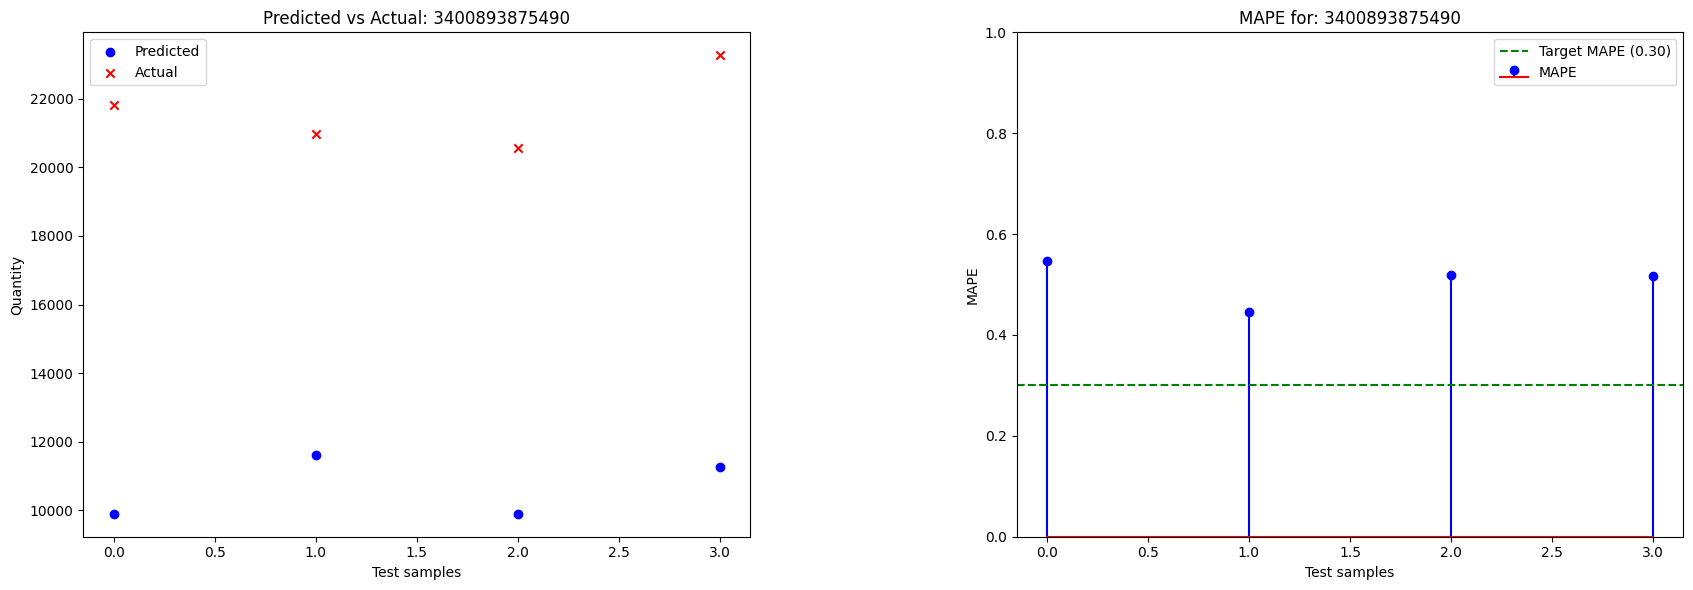



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -6.065
MAE: 5390.436
MAPE: 0.323
RMSE: 5796.897



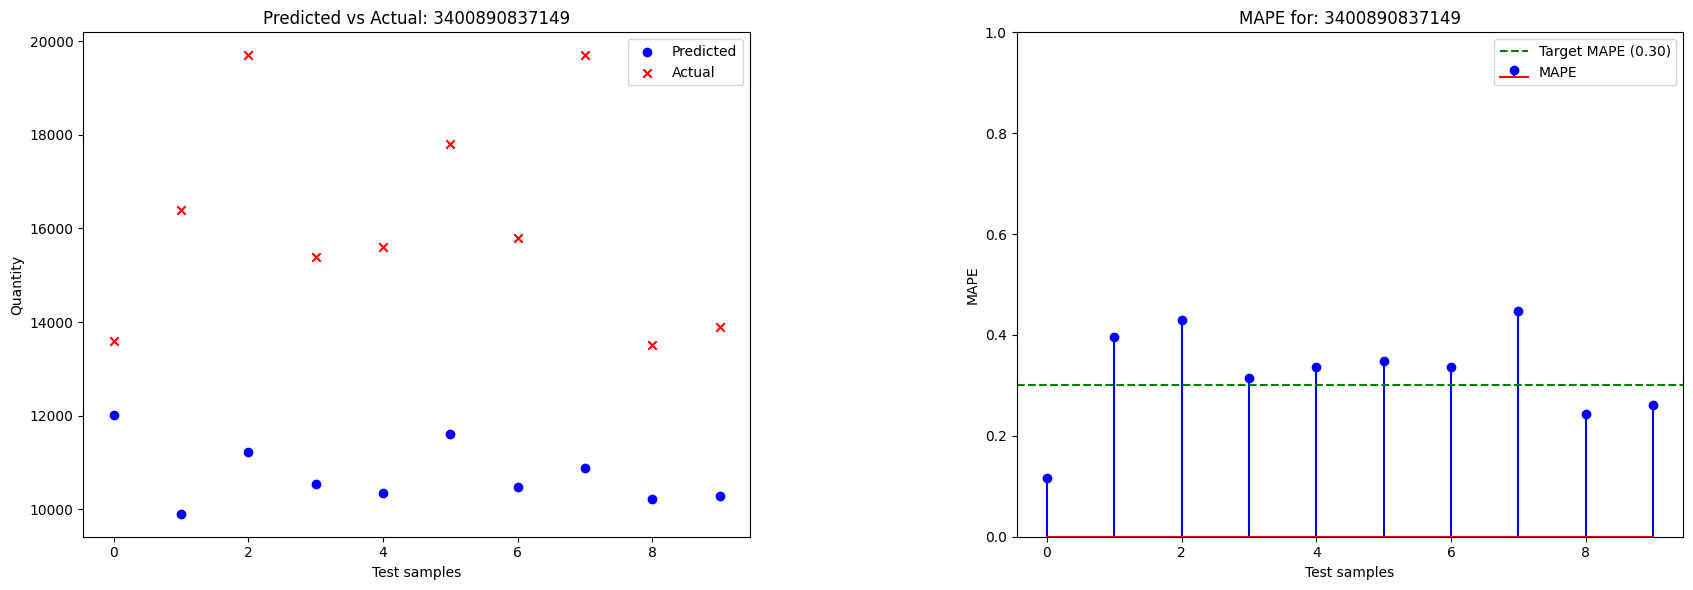



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -0.594
MAE: 1359.102
MAPE: 0.166
RMSE: 1727.118



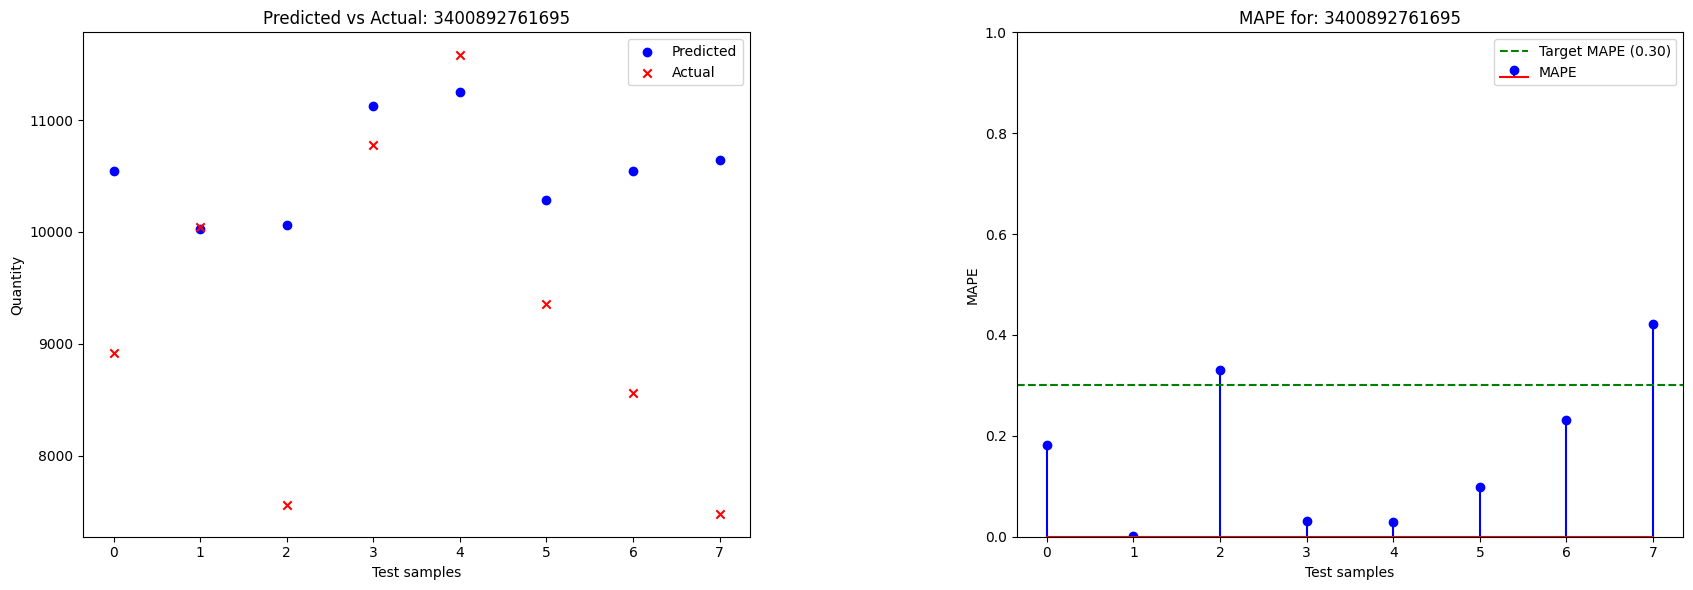



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -11.771
MAE: 11776.992
MAPE: 0.506
RMSE: 12192.86



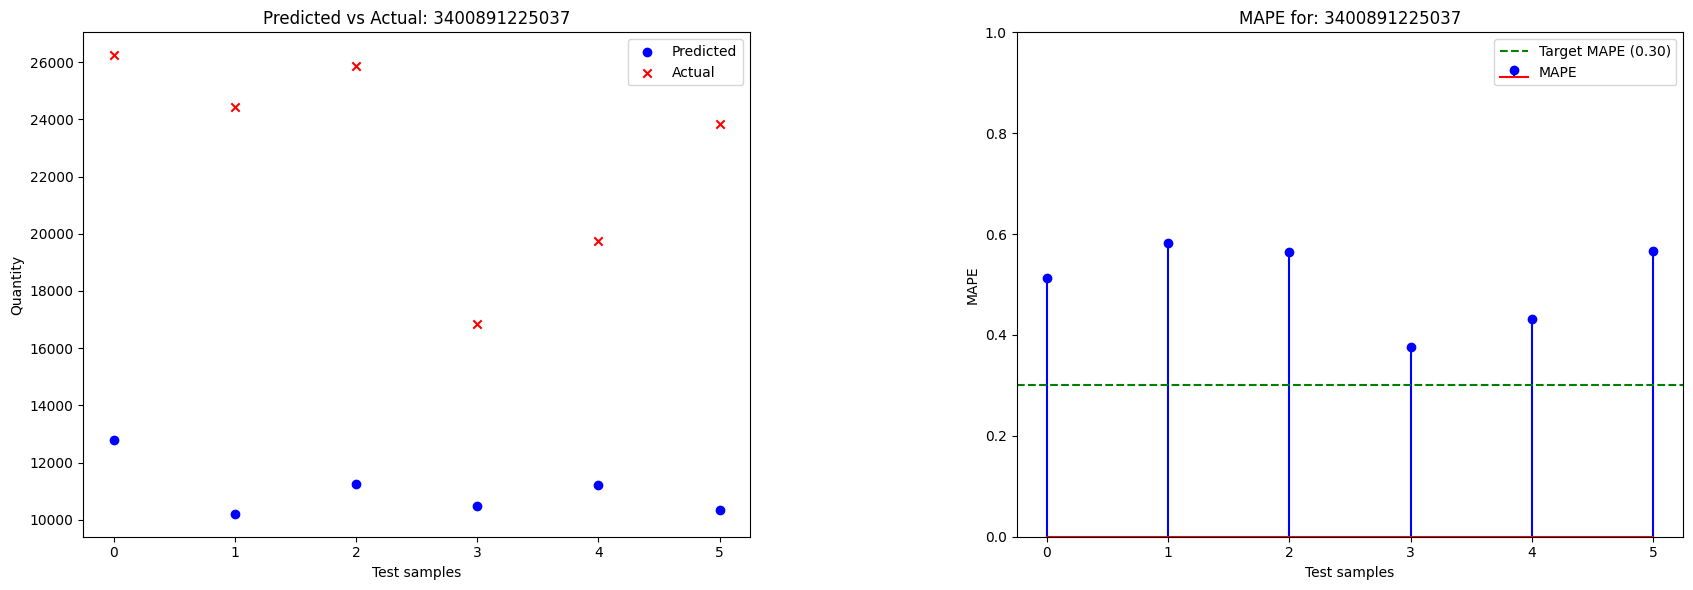



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -5.218
MAE: 4623.607
MAPE: 0.923
RMSE: 5054.763



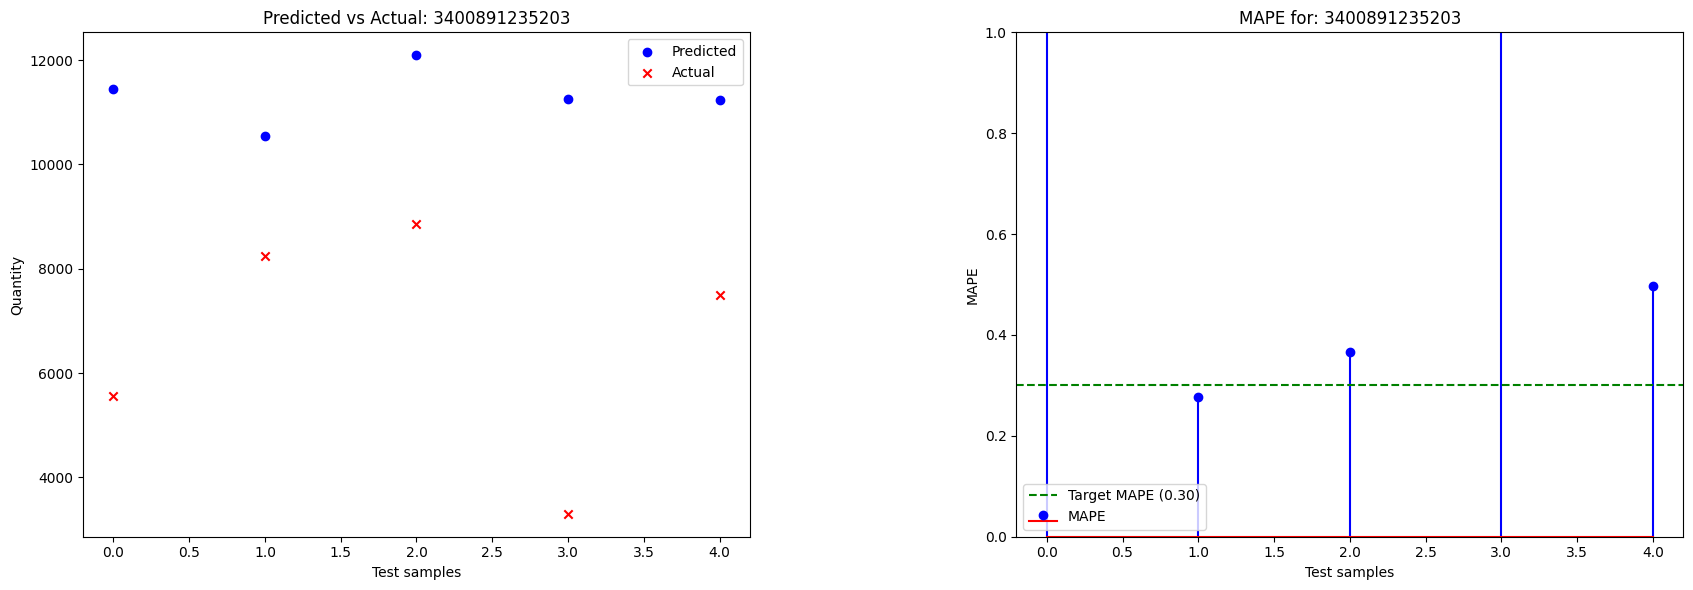



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -5.207
MAE: 3179.663
MAPE: 0.432
RMSE: 3487.901



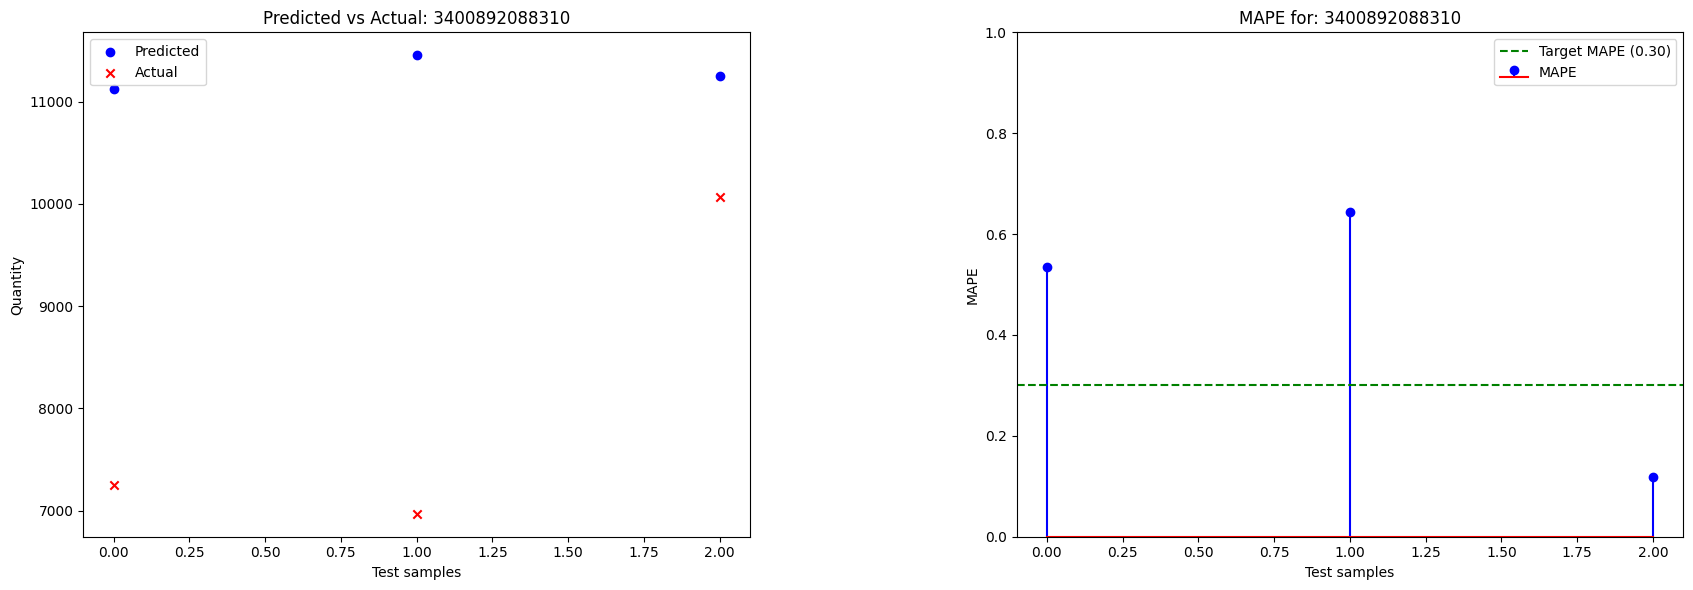



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -0.035
MAE: 2061.664
MAPE: 0.262
RMSE: 2363.124



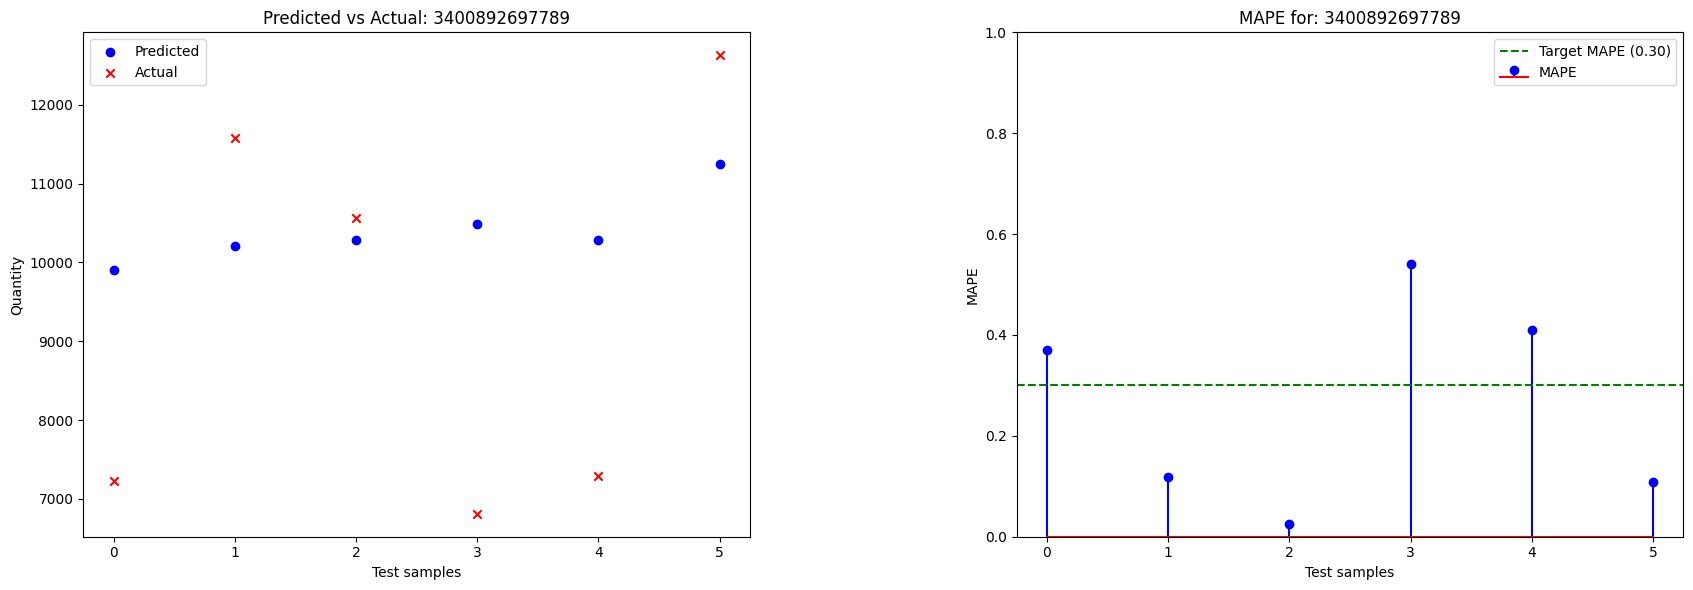



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -6.221
MAE: 3651.031
MAPE: 0.523
RMSE: 4863.061



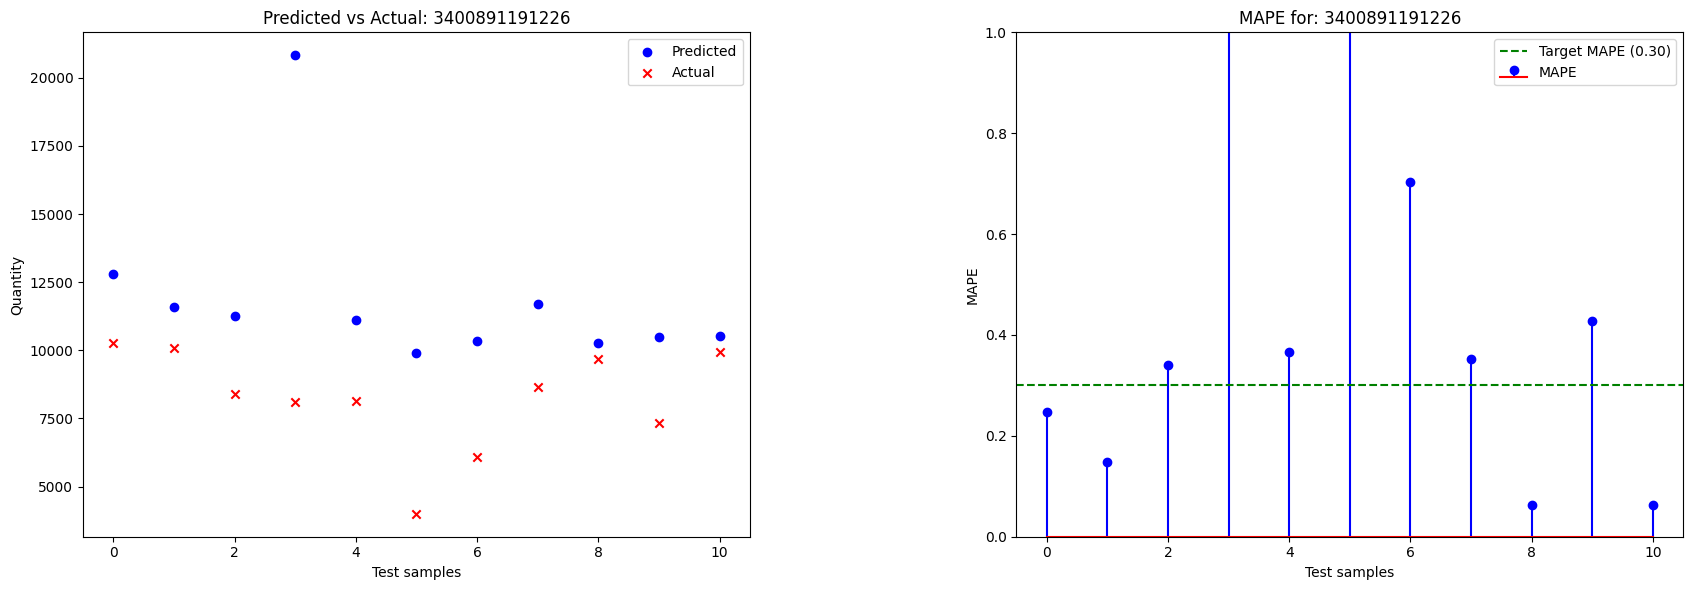



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -0.808
MAE: 1523.675
MAPE: 0.2
RMSE: 2101.451



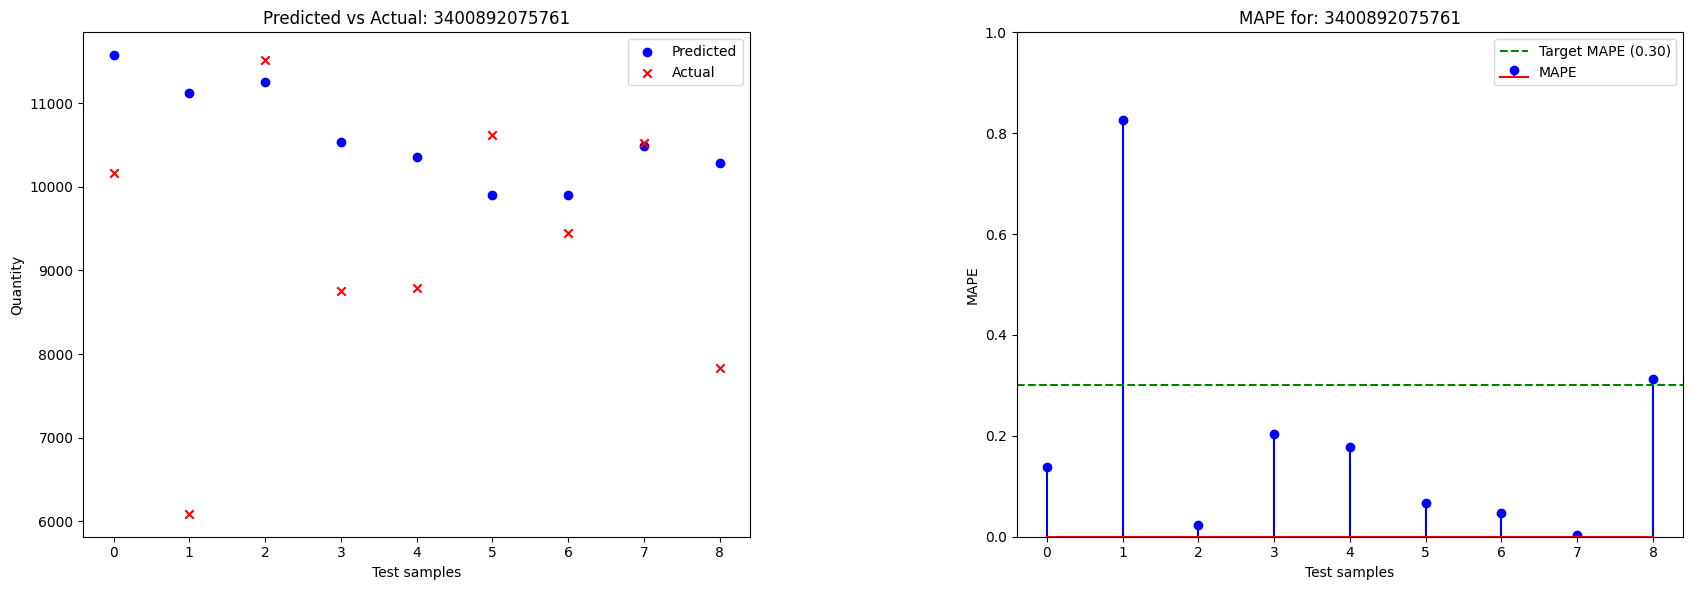



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -10.926
MAE: 4190.813
MAPE: 0.52
RMSE: 4803.152



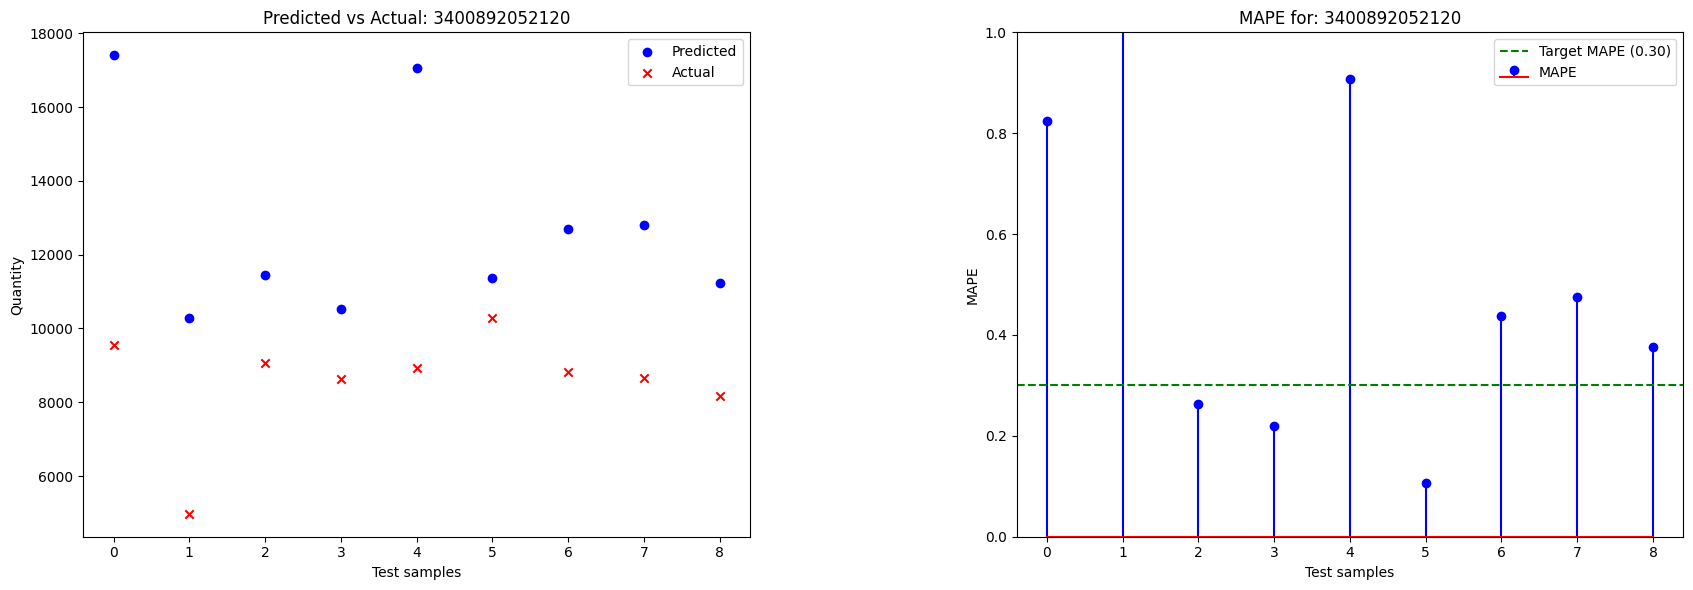



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -5.293
MAE: 7296.872
MAPE: 0.375
RMSE: 7763.038



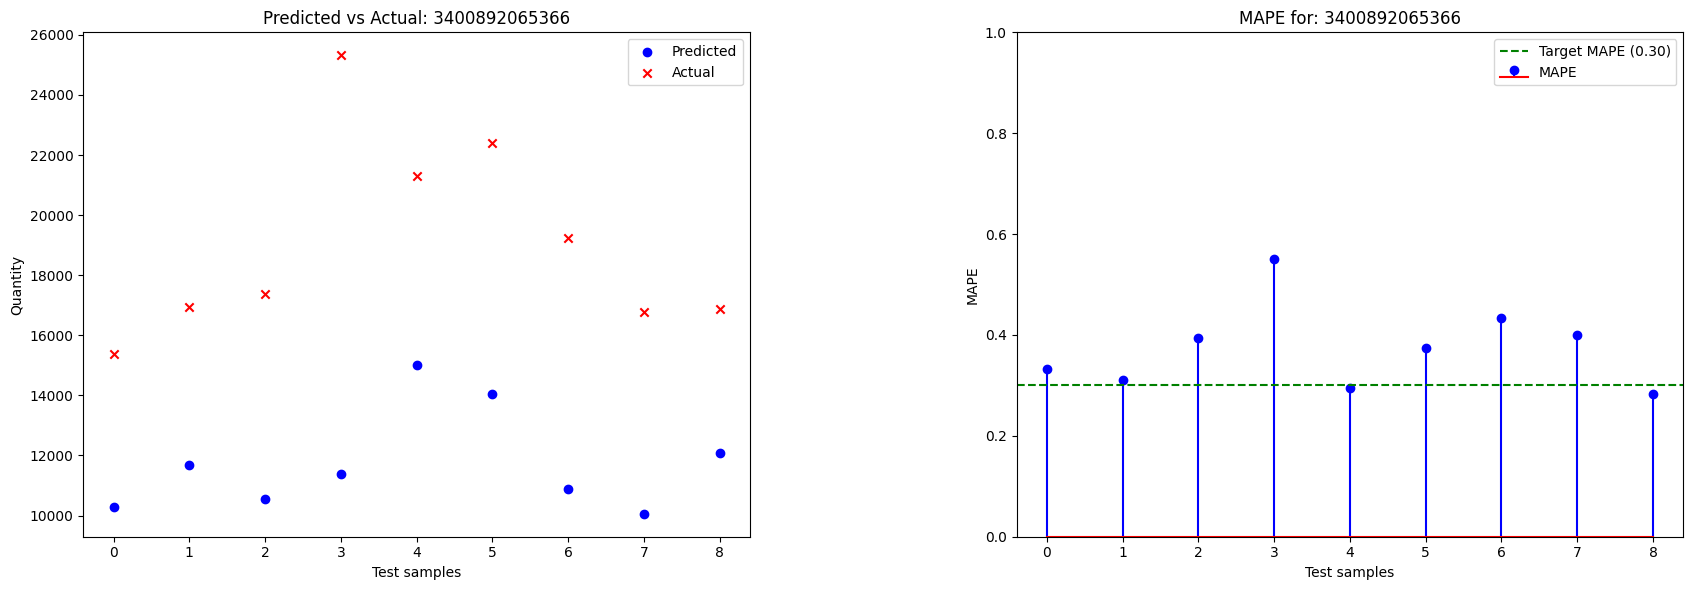



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: -13.166
MAE: 2914.027
MAPE: 0.354
RMSE: 2916.956



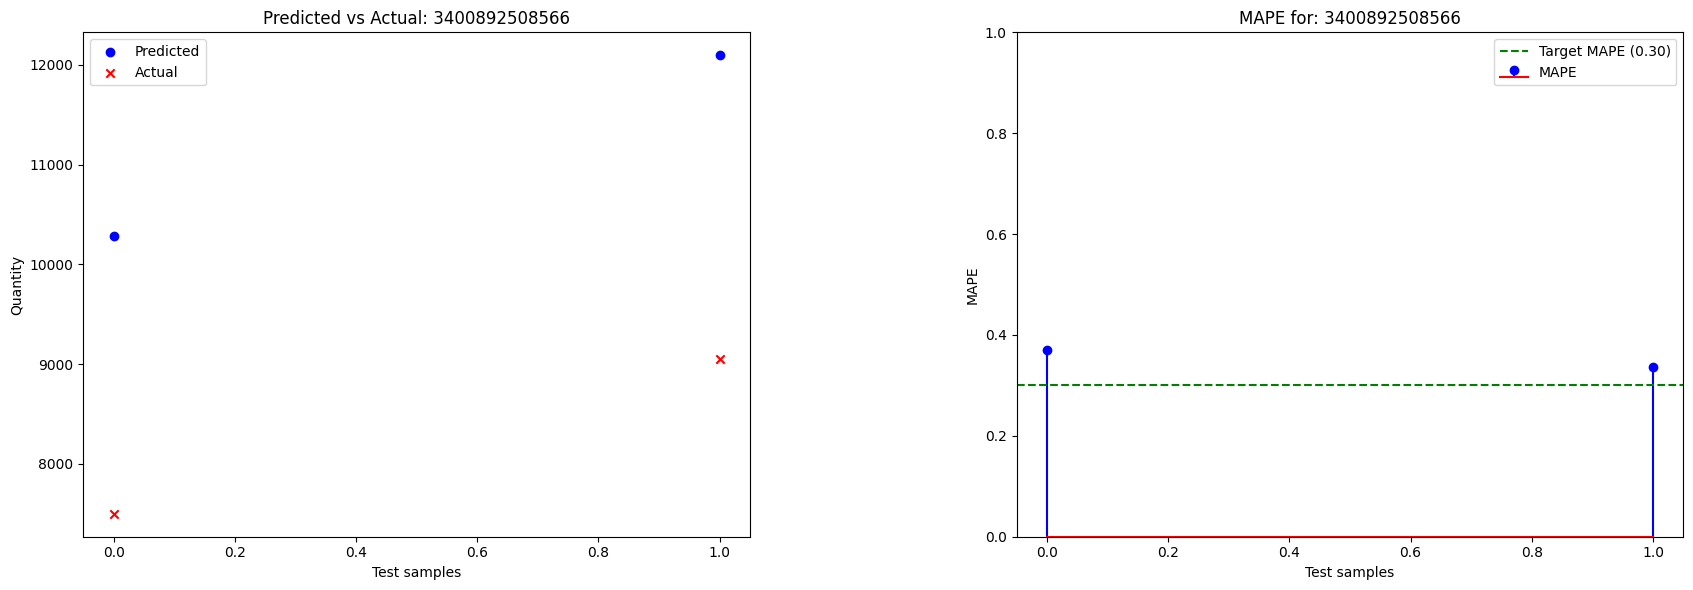



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -0.607
----------Test scores----------
R^2 Score: nan
MAE: 4523.327
MAPE: 0.785
RMSE: 4523.327



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


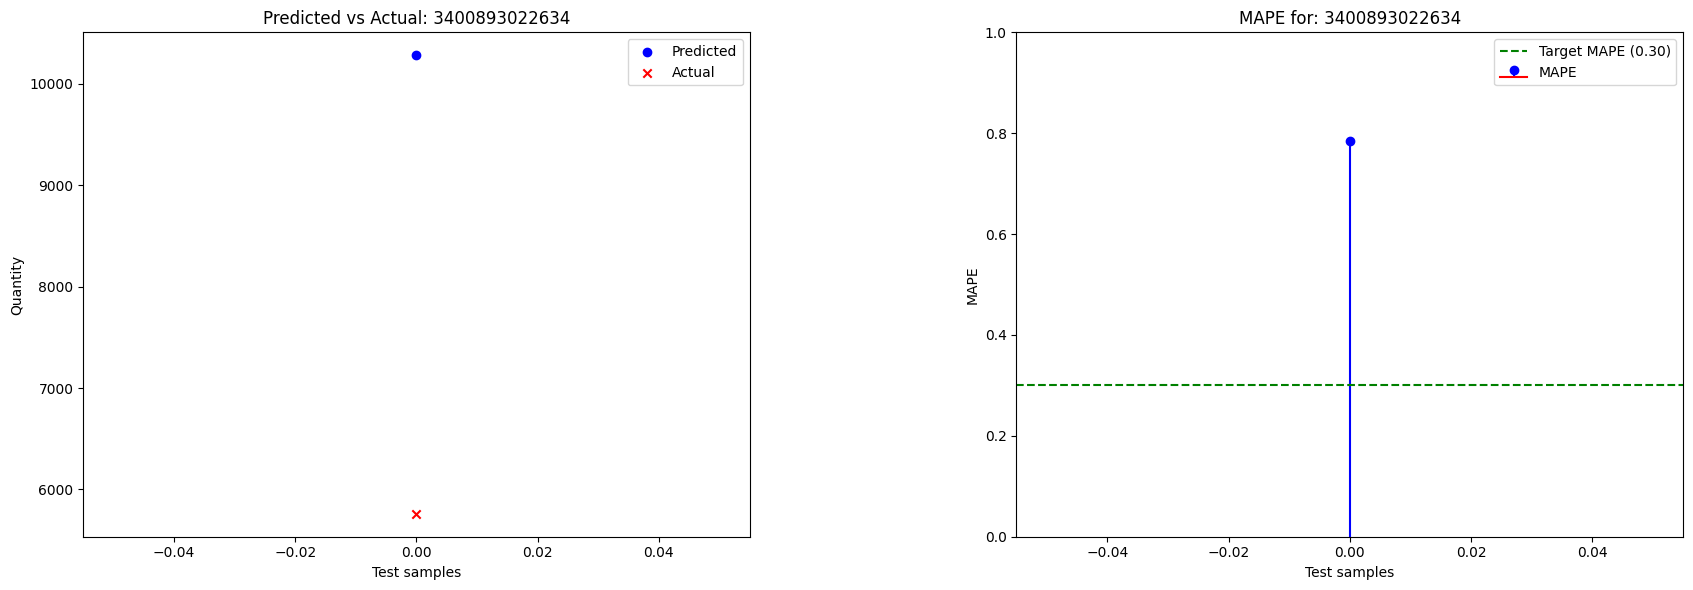



----------------------------------------------------------------------------------------------------
Cluster: 2
Size of data set: 464
Size of training set: 371
Size of test set: 93
Size of grid search: 216
Finished training

----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -1.777
MAE: 5545.449
MAPE: 8.167
RMSE: 6005.014



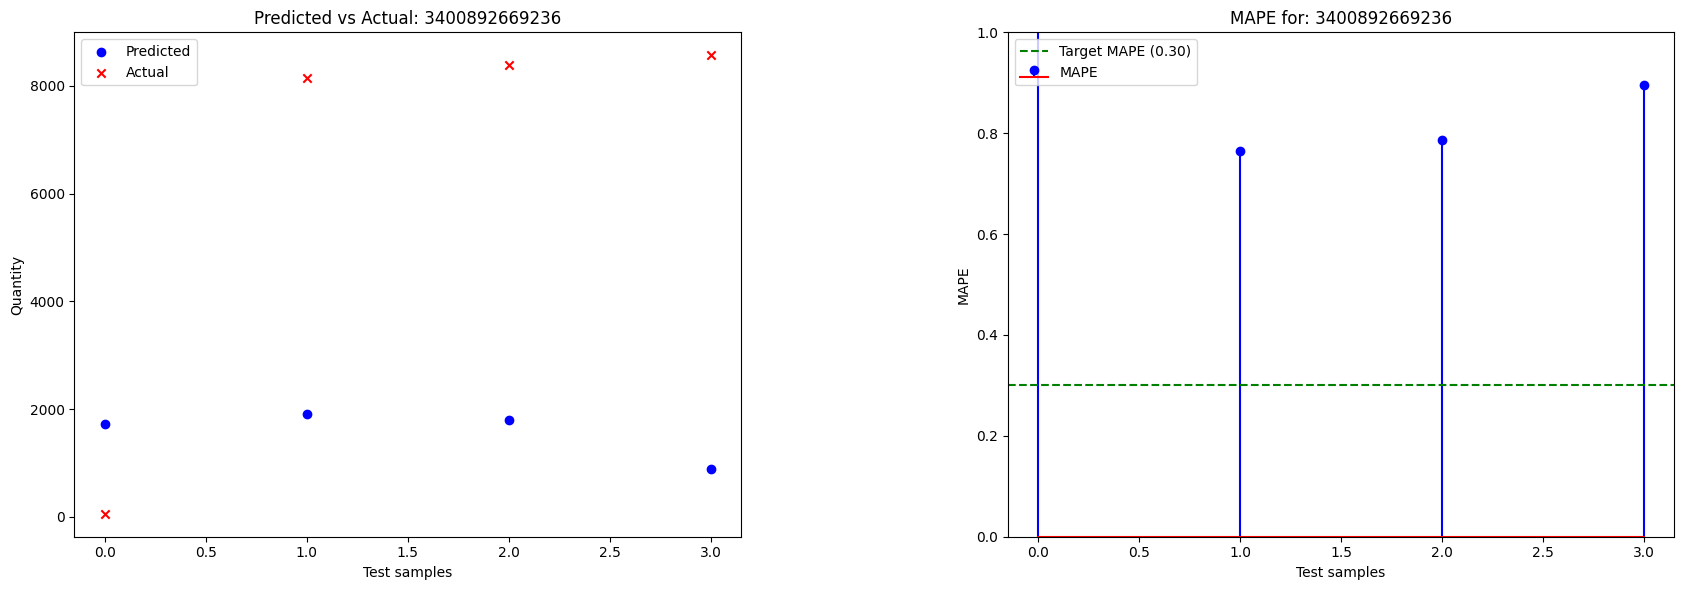



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -220.976
MAE: 10142.78
MAPE: 0.846
RMSE: 10178.416



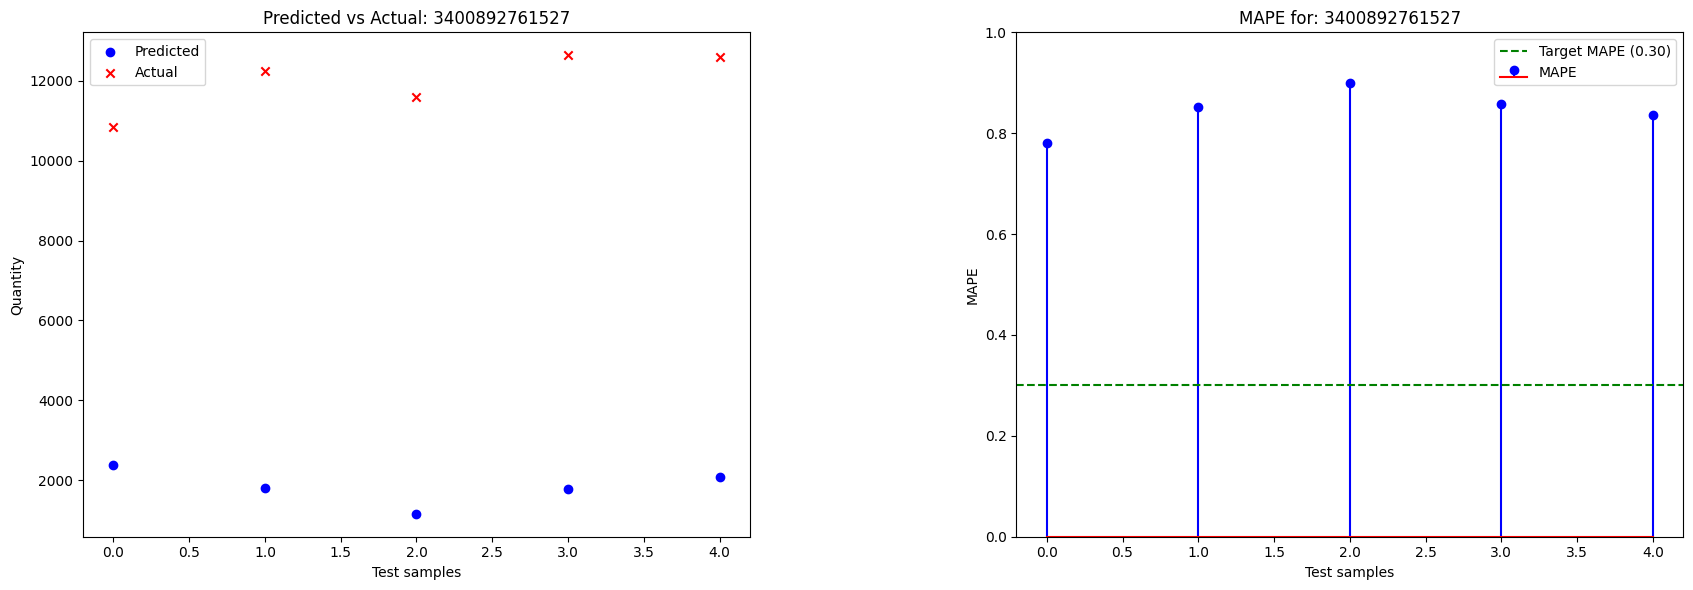



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: 0.239
MAE: 278.193
MAPE: 0.127
RMSE: 377.318



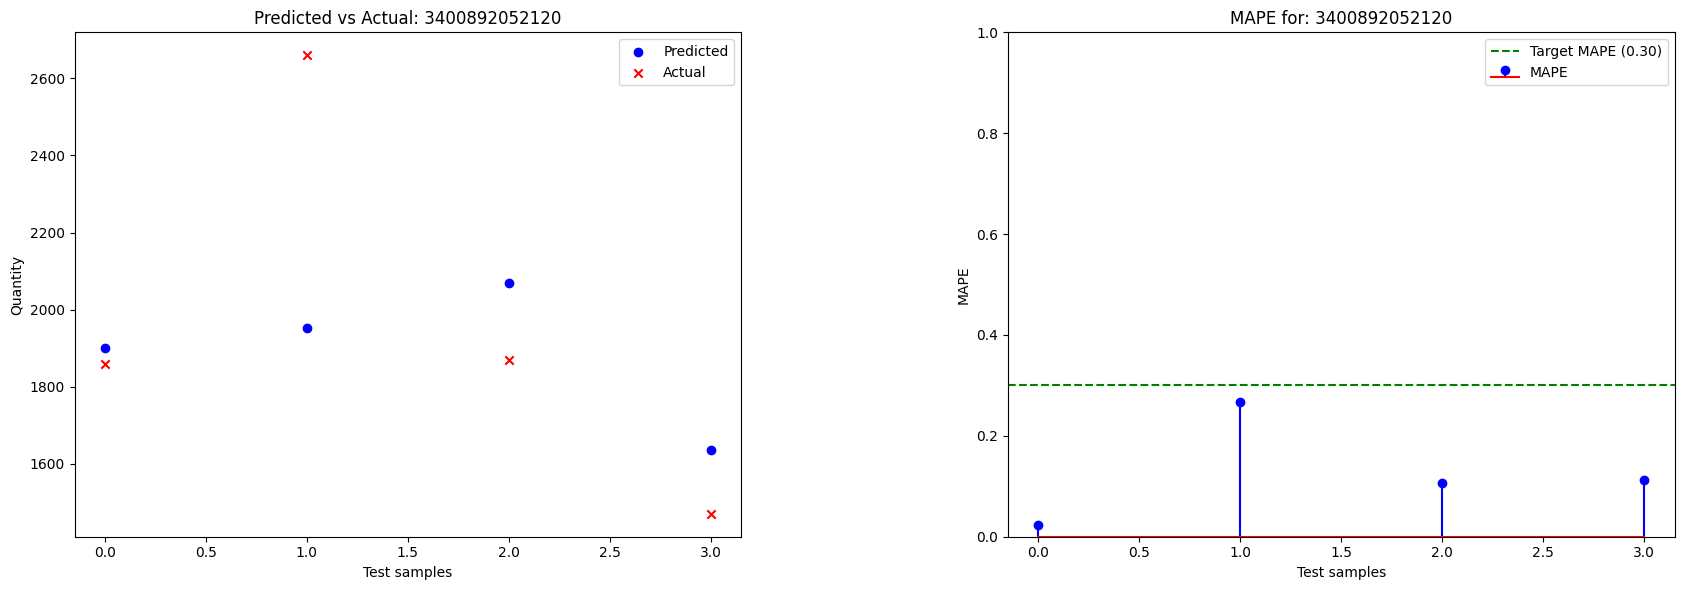



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -264.08
MAE: 6934.072
MAPE: 0.79
RMSE: 6968.854



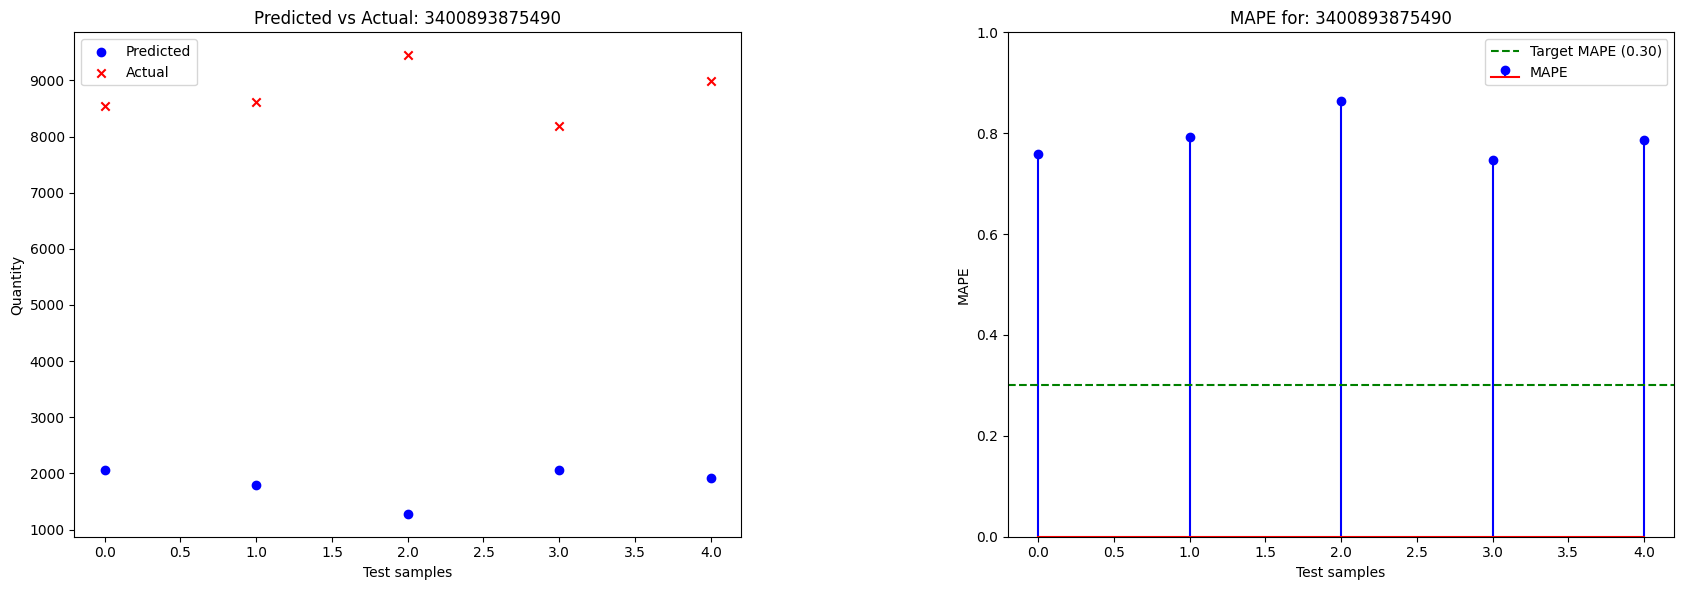



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -26.302
MAE: 13092.748
MAPE: 0.88
RMSE: 13408.775



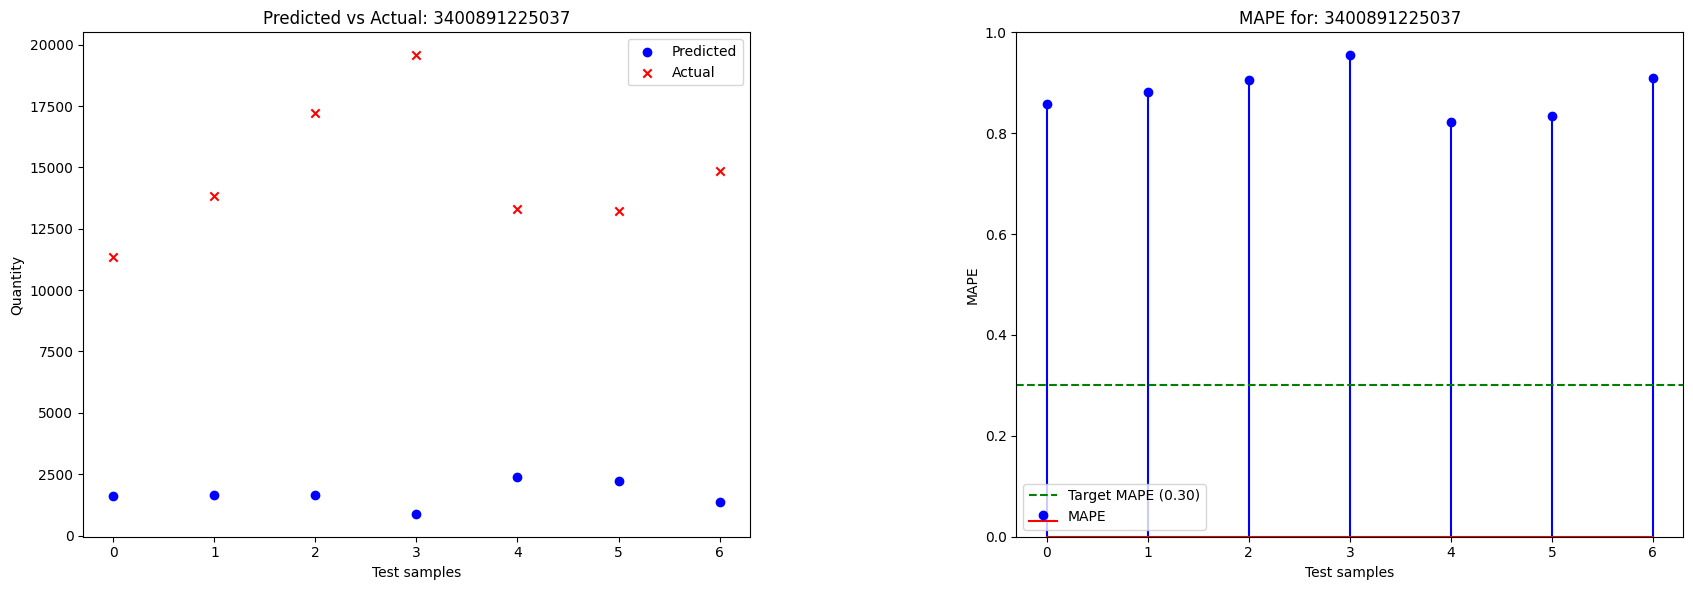



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -8.614
MAE: 4697.544
MAPE: 0.677
RMSE: 5032.945



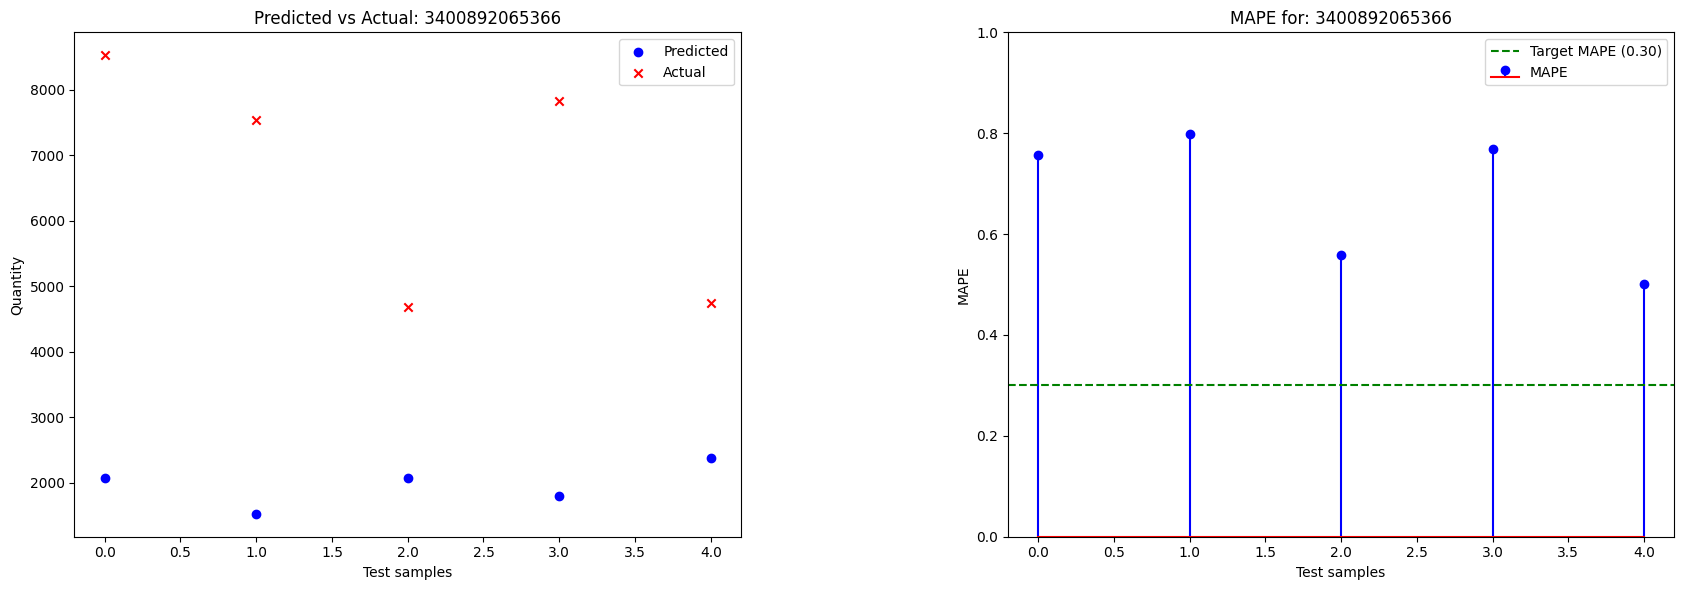



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -9521.941
MAE: 1798.44
MAPE: 40.877
RMSE: 1825.659



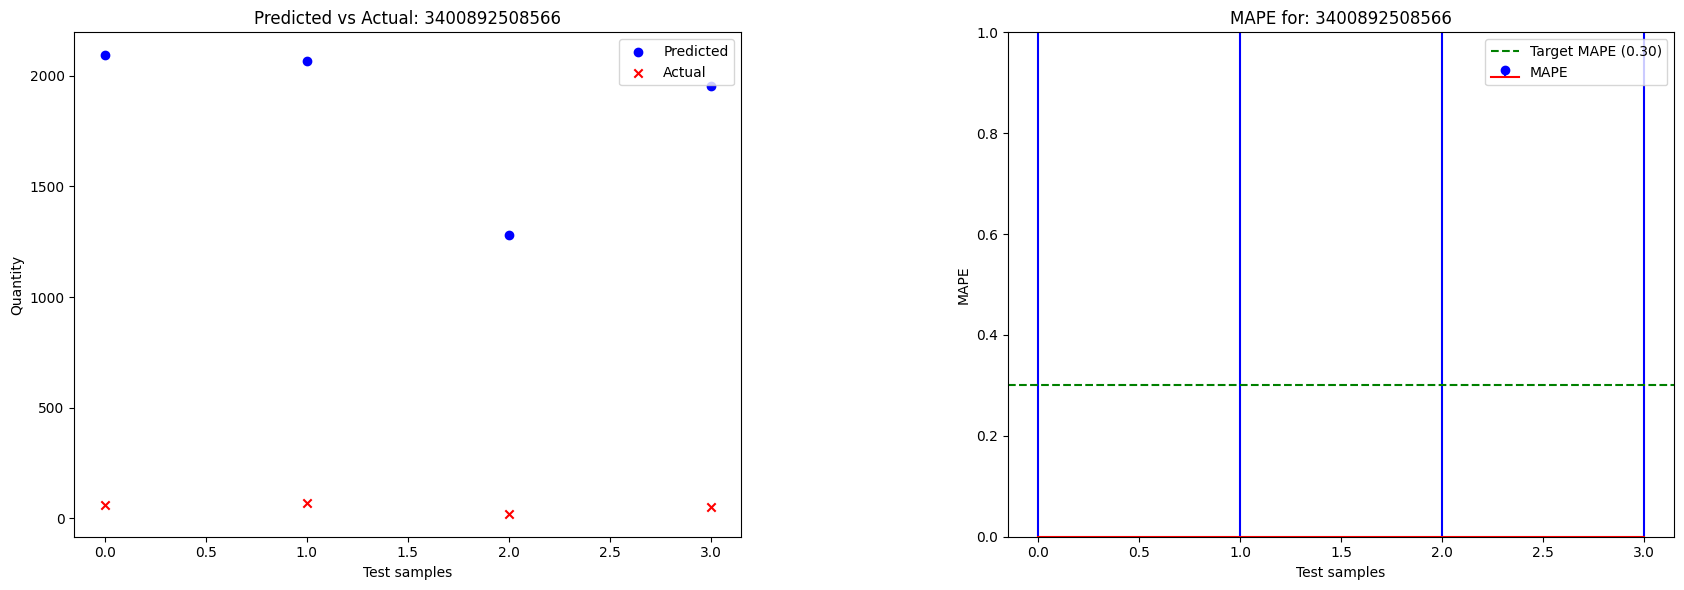



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: 0.051
MAE: 901.012
MAPE: 28.408
RMSE: 1122.851



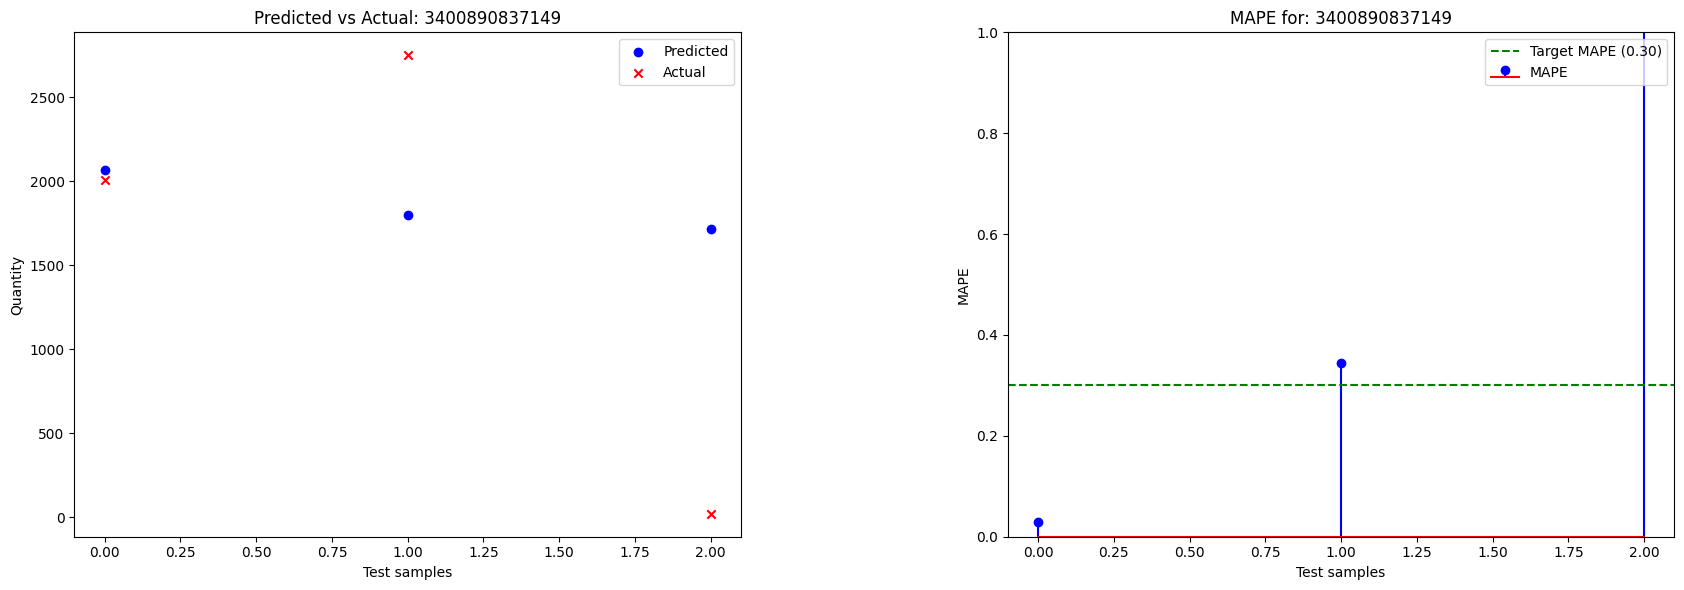



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -30.459
MAE: 1716.229
MAPE: 0.475
RMSE: 1800.874



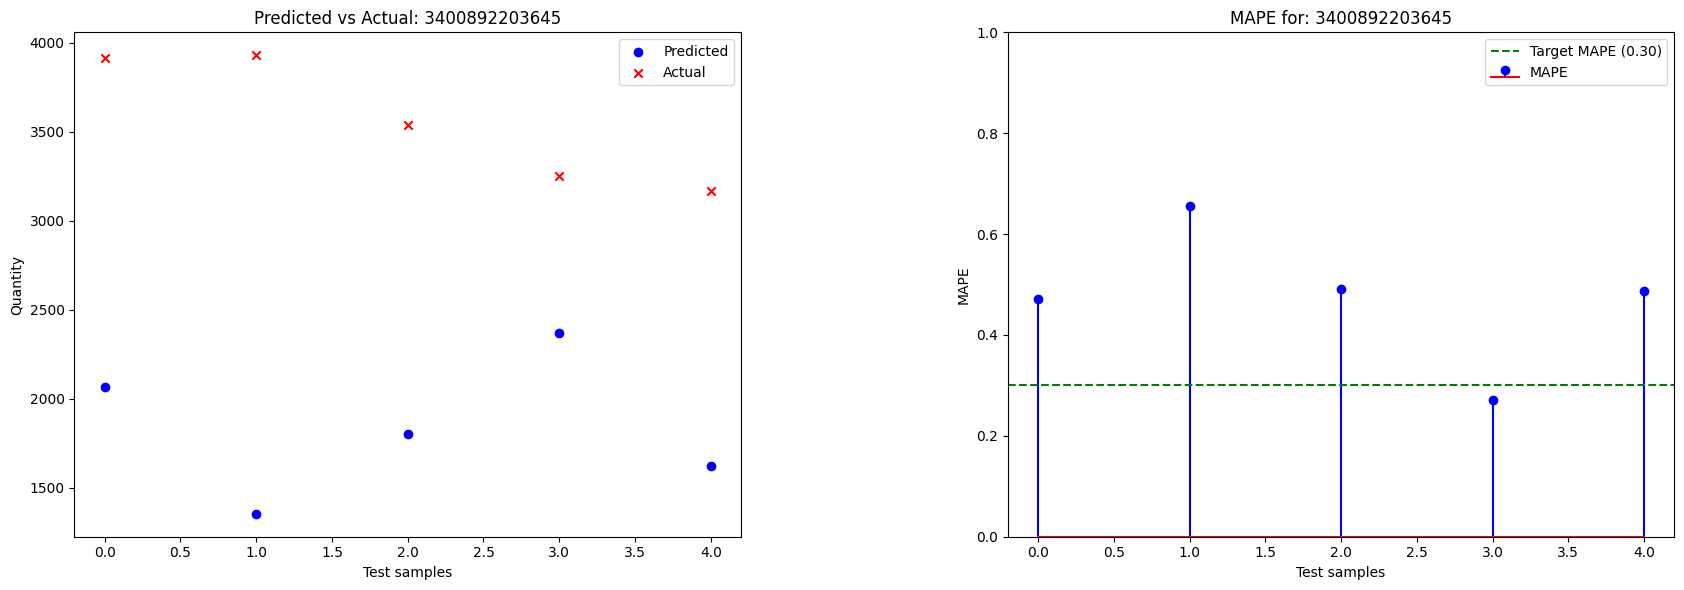



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -9.531
MAE: 879.776
MAPE: 0.296
RMSE: 1014.526



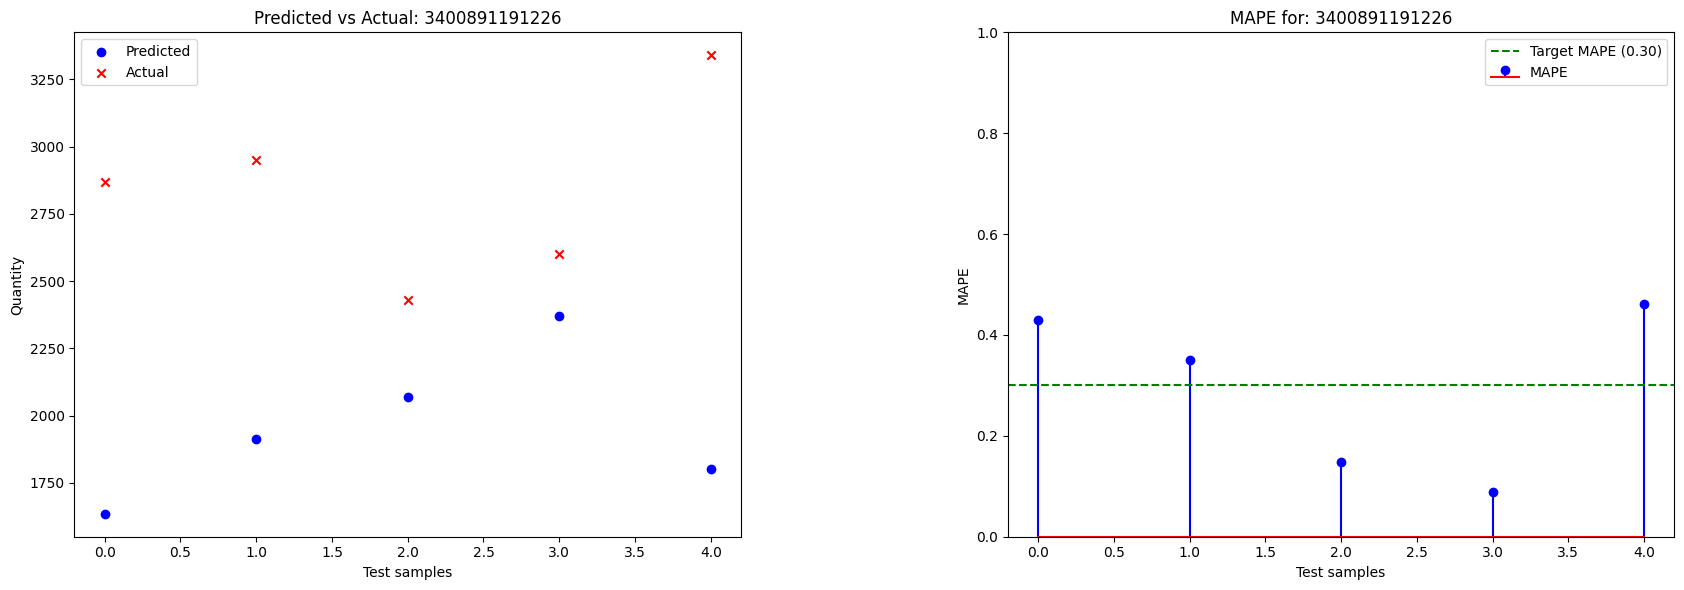



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -0.72
MAE: 679.504
MAPE: 7.795
RMSE: 877.438



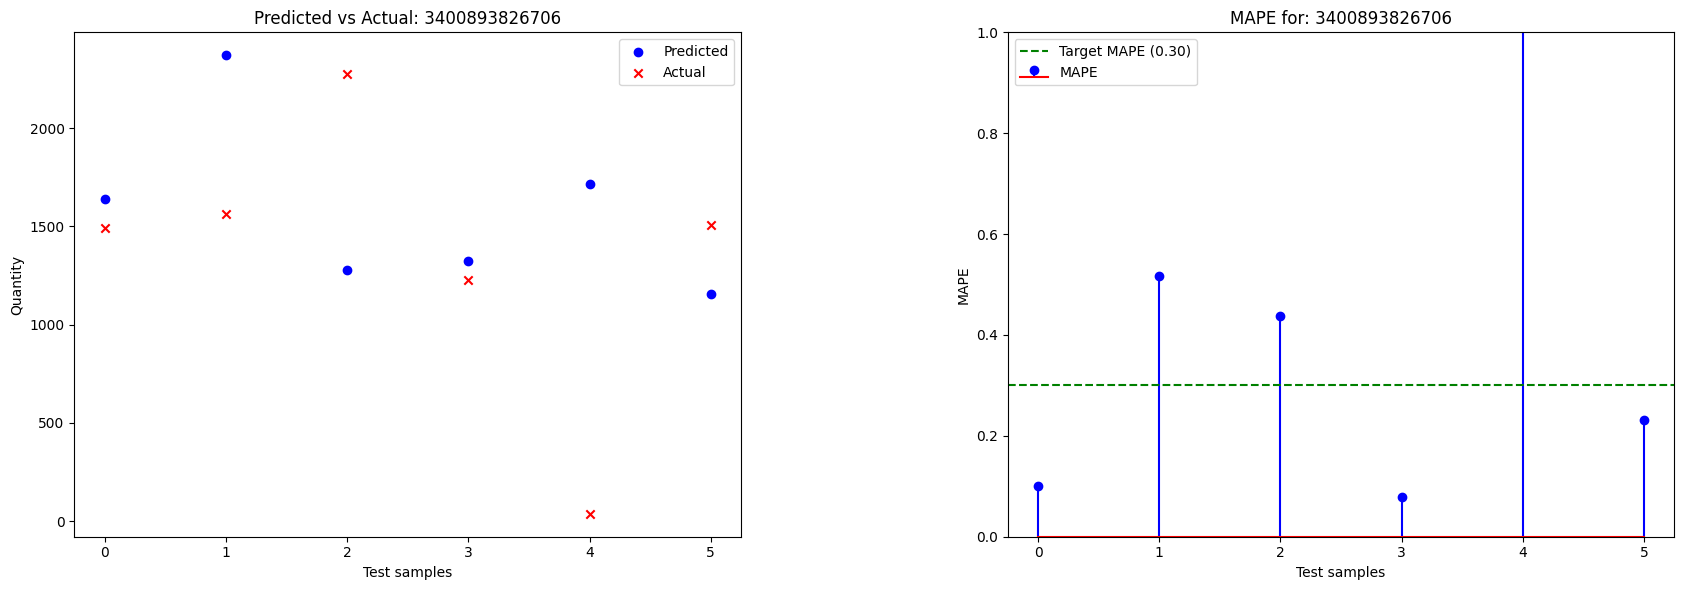



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -40.414
MAE: 3543.051
MAPE: 0.681
RMSE: 3552.463



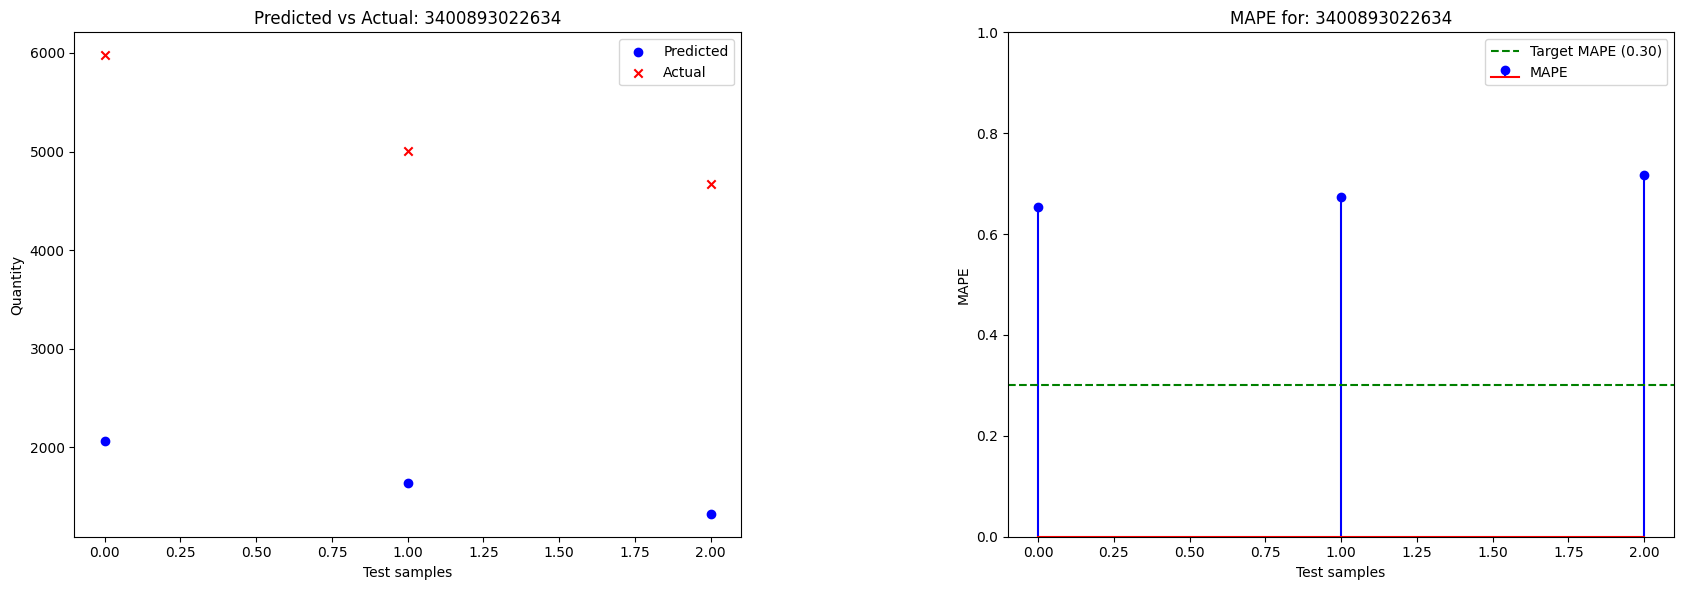



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -113.491
MAE: 13535.368
MAPE: 0.896
RMSE: 13614.681



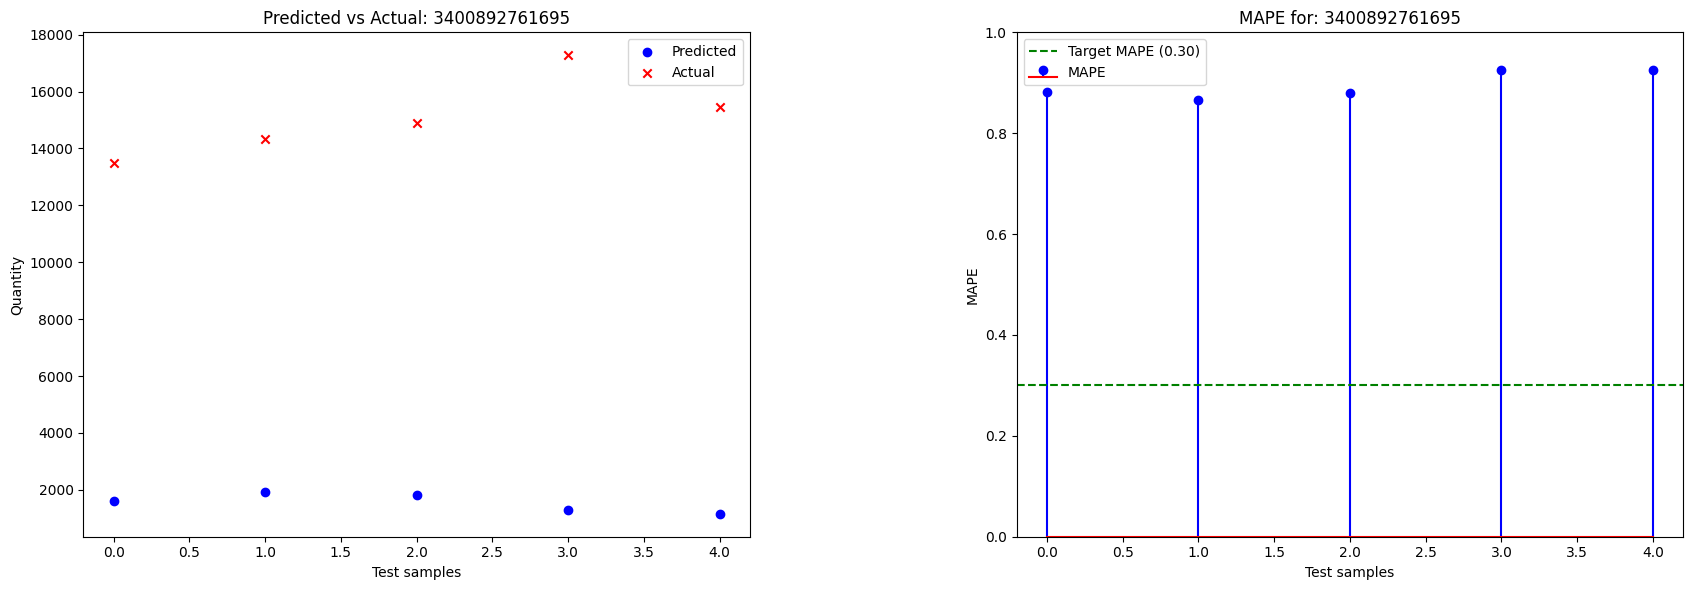



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -21.877
MAE: 2980.616
MAPE: 0.633
RMSE: 3008.424



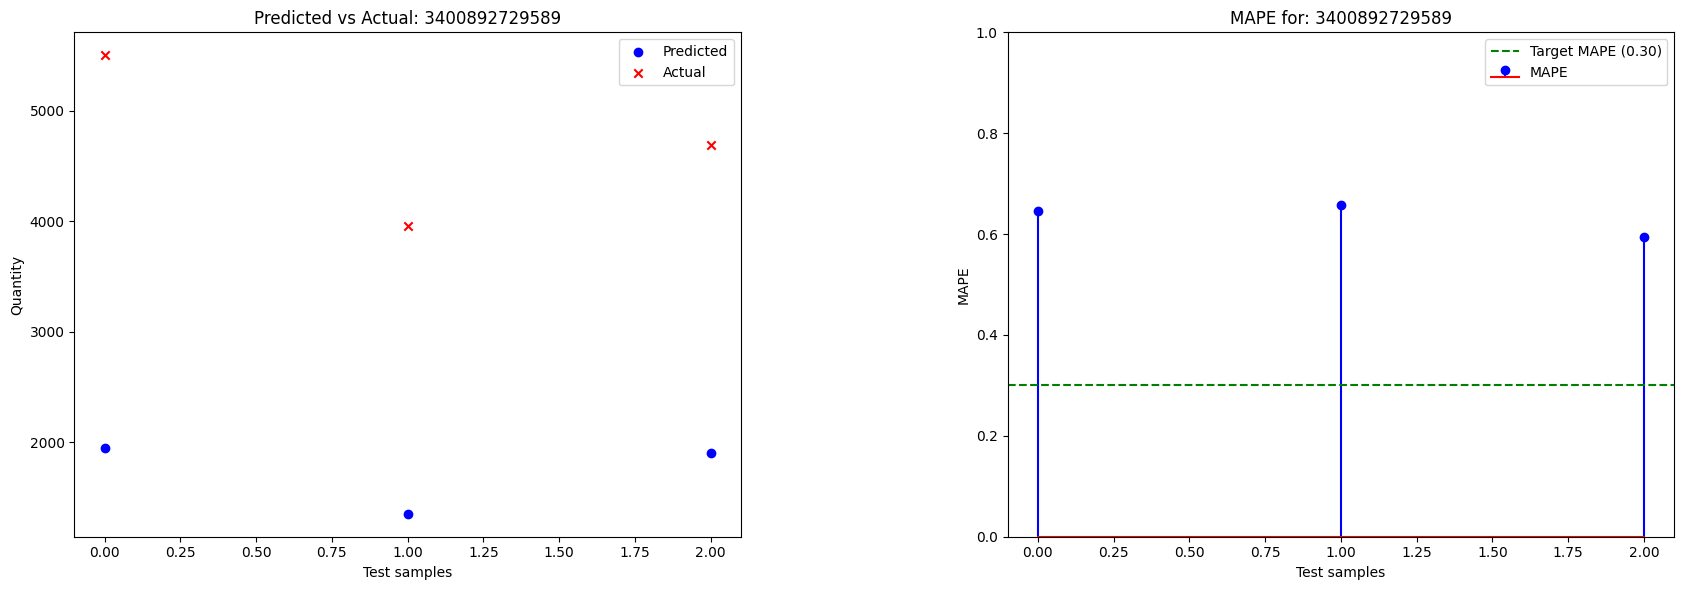



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -35.94
MAE: 956.907
MAPE: 1.631
RMSE: 1076.994



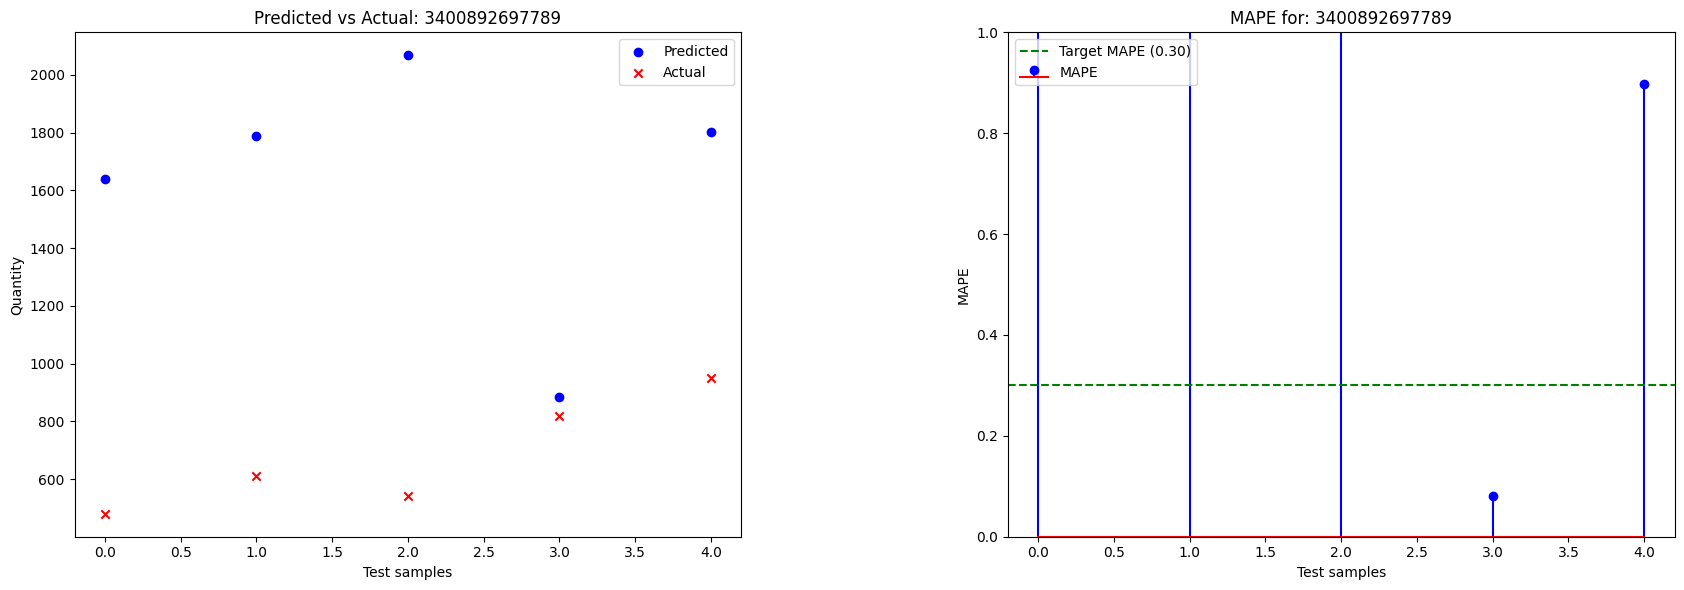



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -7.837
MAE: 1250.258
MAPE: 0.428
RMSE: 1386.948



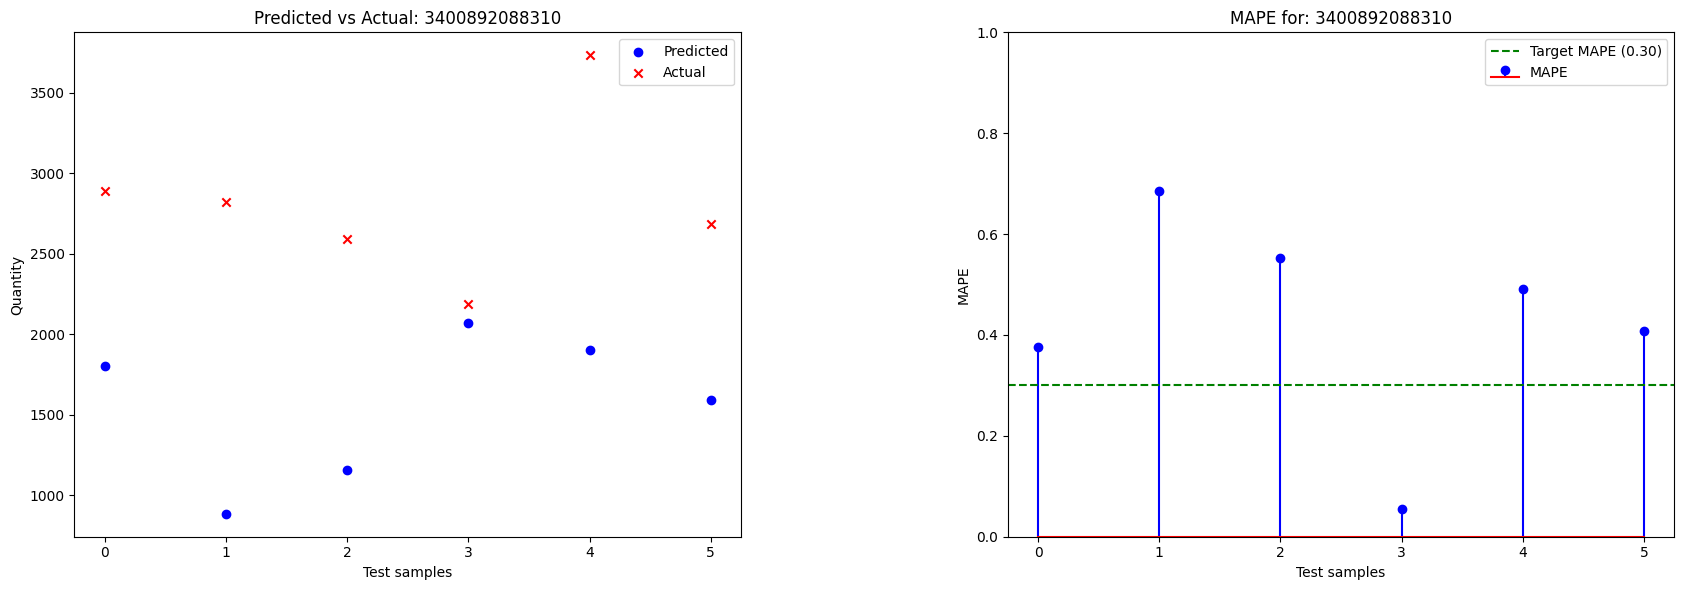



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -3.626
MAE: 519.93
MAPE: 0.202
RMSE: 716.16



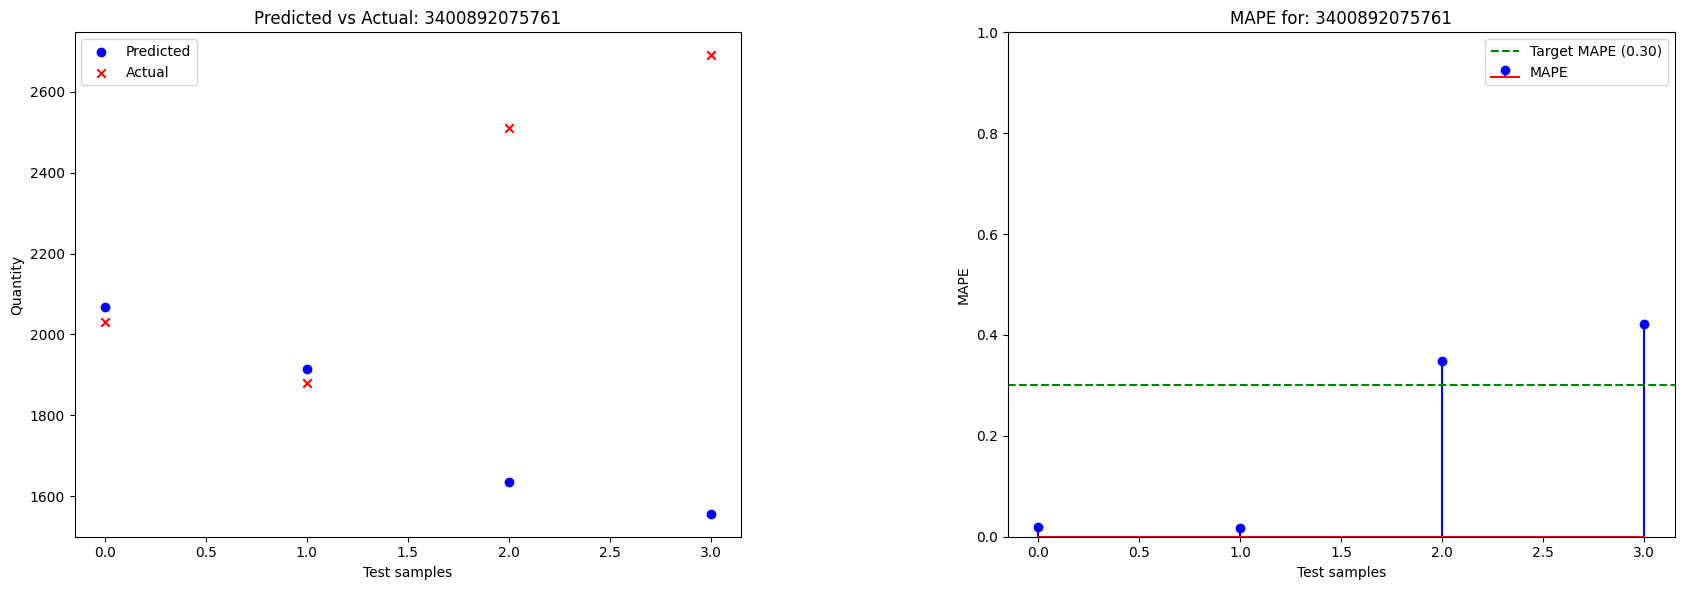



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -4.196
MAE: 395.827
MAPE: 0.314
RMSE: 509.664



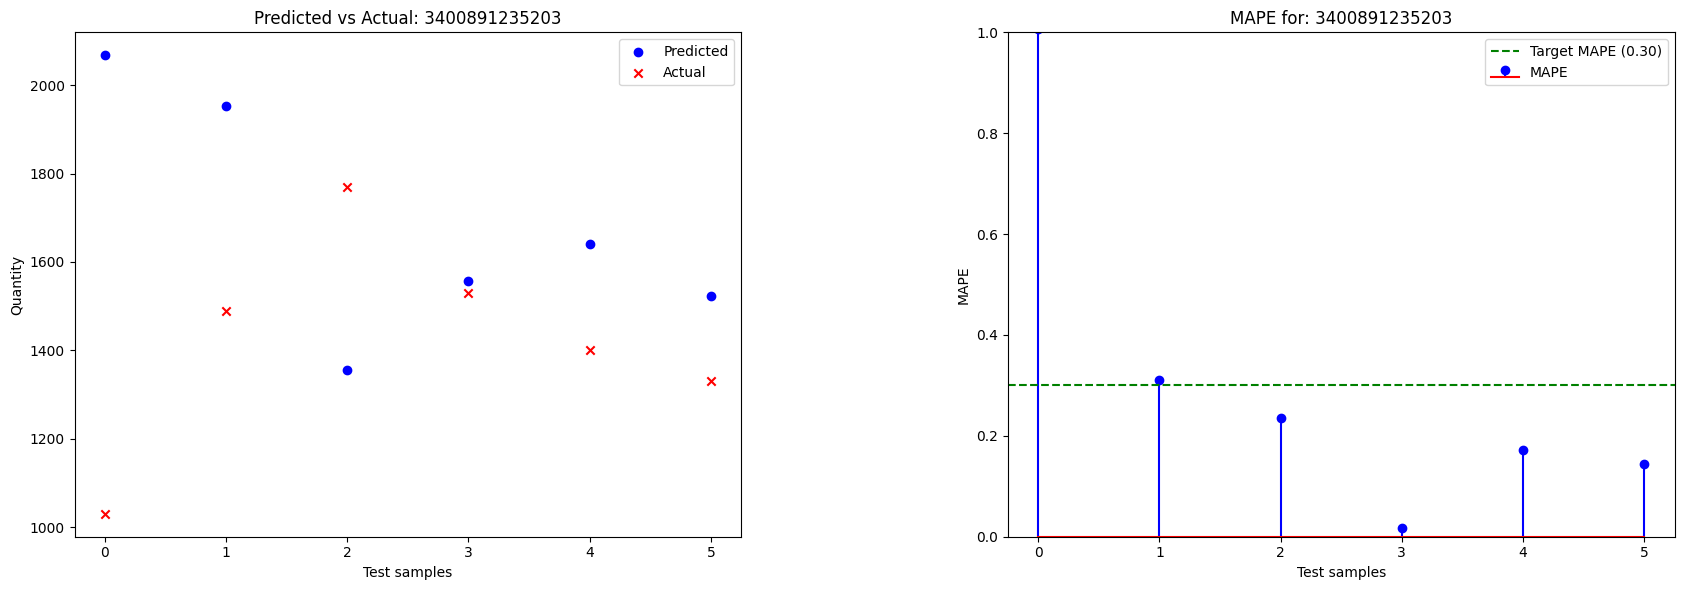



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -0.833
MAE: 2145.312
MAPE: 17.427
RMSE: 2239.107



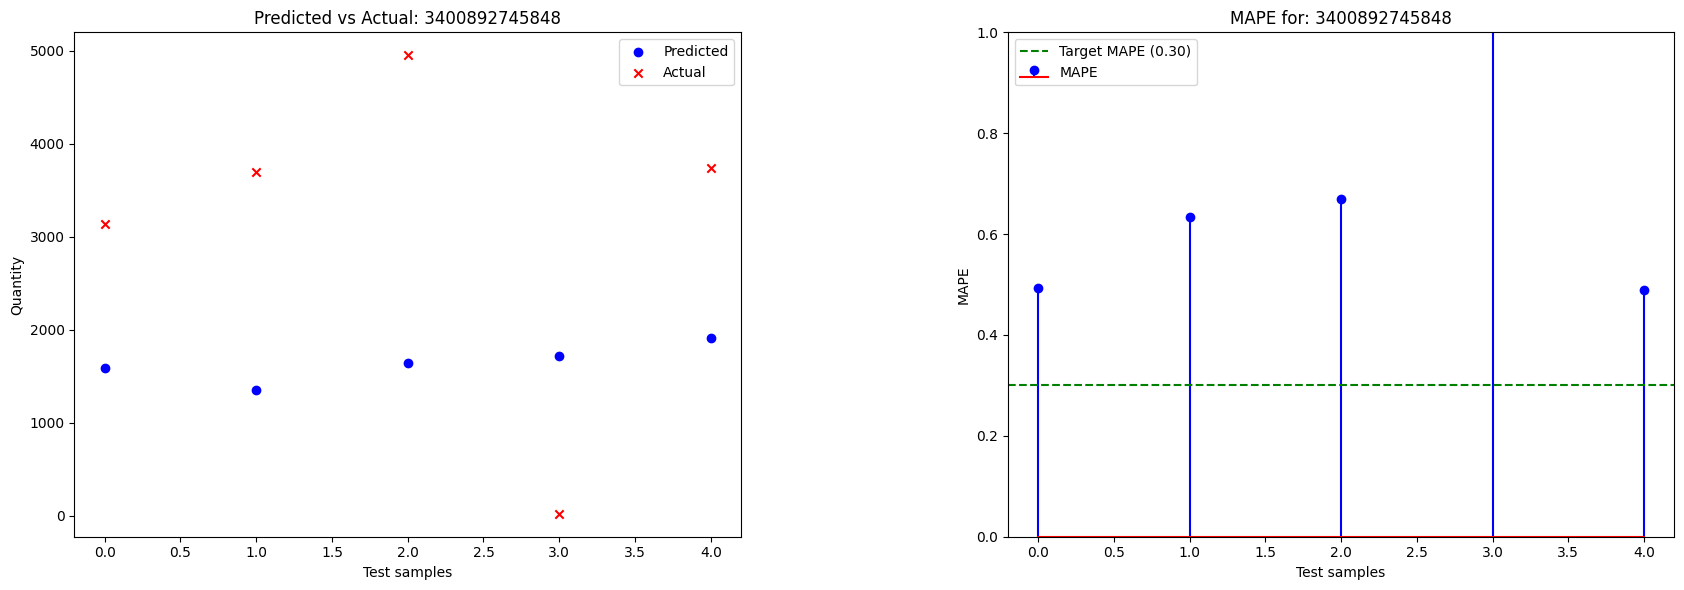



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -2.84
----------Test scores----------
R^2 Score: -63.206
MAE: 2273.666
MAPE: 0.586
RMSE: 2290.747



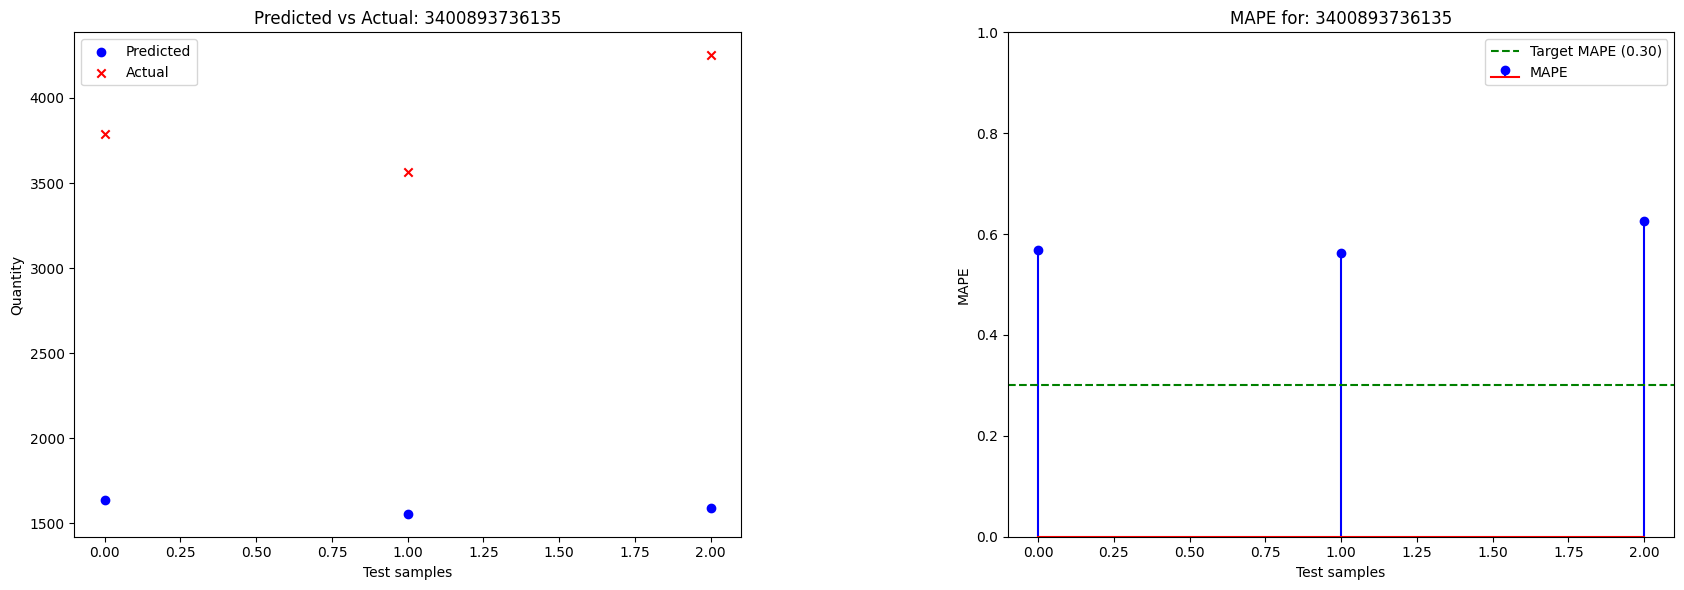

HOSPI_CODE_UCD CLUSTER         R2         RMSE          MAE  \
0   CODE_UCD_3400892088310       3 -12.356119  1015.064201   951.994361   
1   CODE_UCD_3400892761695       3  -1.706371   248.587705   213.172815   
2   CODE_UCD_3400892697789       3 -14.918543  1009.787655   860.273441   
3   CODE_UCD_3400892203645       3  -1.628255   314.061161   253.243585   
4   CODE_UCD_3400893875490       3 -94.209567  8285.874584  8242.309684   
..                     ...     ...        ...          ...          ...   
75  CODE_UCD_3400892088310       2  -7.837029  1386.948154  1250.258274   
76  CODE_UCD_3400892075761       2  -3.626051   716.159581   519.930451   
77  CODE_UCD_3400891235203       2  -4.196024   509.664473   395.827294   
78  CODE_UCD_3400892745848       2  -0.832510  2239.107165  2145.311571   
79  CODE_UCD_3400893736135       2 -63.205911  2290.746720  2273.666088   

         MAPE  
0    0.386327  
1    0.129036  
2    0.908646  
3    0.200450  
4    0.832537  
..        ...  
75   0.428122  
76   0.201623  
77   0.314393  
78  17.427127  
79   0.585743  

[80 rows x 6 columns]

In [9]:
df_prediction_scores_agg = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_agg = test_2_clustering(df_agg_clusters_4, df_prediction_scores_agg, medicines)

df_prediction_scores_agg

In [ ]:
'''df_prediction_scores_pca = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_pca = test_2_clustering(df_clustered_pca, df_prediction_scores_pca, medicines)

df_prediction_scores_pca'''